# IMPORTS

## Bibliotecas

In [141]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import xgboost as xgb

import datetime
import inflection
import math
import random
import warnings
import joblib

from scipy import stats
from sklearn.preprocessing import RobustScaler, MinMaxScaler, LabelEncoder
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error, mean_squared_error
from sklearn.linear_model import LinearRegression, Lasso
from boruta import BorutaPy

warnings.filterwarnings('ignore')

## Funções Auxiliares

In [142]:
# Função do V de cramer para correlação de variáveis categóricas
def cramer_v(x, y):
    confusion_matrix = pd.crosstab(x, y).to_numpy()
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape

    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    chi2_corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    k_corr = k - (k-1)**2/(n-1)
    r_corr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2_corr/n) / (min(k_corr-1, r_corr-1)))
    

In [143]:
# Funçao para calcular a performance do Modelos de Machine Learning
def ml_error(model_name, y, y_hat):
    mae = mean_absolute_error(y, y_hat)
    mape = mean_absolute_percentage_error(y, y_hat)
    rmse = np.sqrt(mean_squared_error(y, y_hat))
    
    return pd.DataFrame({
        'Model Name': model_name,
        'MAE': mae,
        'MAPE': mape,
        'RMSE': rmse
    }, index=[0])

In [144]:
# MPE
def mean_percentage_error(y, y_hat):
    return np.mean((y - y_hat) / y)

In [145]:
# Função de Cross-Validation (Fiz para exercitar)
def cross_validation(x_training, kfold, model_name, model, verbose=False):
    mae_list = []
    mape_list = []
    rmse_list = []

    for k in reversed(range(1, kfold+1)):
        if verbose:
            print('\nK-fold Number: {}'.format(k))
        # inicio e fim das datas de validação
        validation_start_date = x_training['date'].max() - datetime.timedelta(days=k*6*7)
        validation_end_date = x_training['date'].max() - datetime.timedelta(days=(k-1)*6*7)

        # Filtrando dataset
        training = x_training[x_training['date'] < validation_start_date]
        validation = x_training[(x_training['date'] >= validation_start_date) & (x_training['date'] <= validation_end_date)]

        # dataset de treino e validação
        # Treinamento
        xtraining = training.drop(['date', 'sales'], axis=1)
        ytraining = training['sales']

        # Validação
        xvalidation = validation.drop(['date', 'sales'], axis=1)
        yvalidation = validation['sales']

        # Model
        m = model.fit(xtraining, ytraining)

        # Prediction
        y_hat_m = m.predict(xvalidation)

        # Performance
        m_result = ml_error(model_name, np.expm1(yvalidation), np.expm1(y_hat_m))
        
        # histórico de performance por k-fold iteração
        mae_list.append(m_result['MAE'])
        mape_list.append(m_result['MAPE'])
        rmse_list.append(m_result['RMSE'])

    return pd.DataFrame({'Model Name': model_name,
        'MAE CV': np.round(np.mean(mae_list), 2).astype(str) + ' +/- ' + np.round(np.std(mae_list), 2).astype(str),
        'MAPE CV': np.round(np.mean(mape_list), 2).astype(str) + ' +/- ' + np.round(np.std(mape_list), 2).astype(str),
        'RMSE CV': np.round(np.mean(rmse_list), 2).astype(str) + ' +/- ' + np.round(np.std(rmse_list), 2).astype(str)
    }, index=[0])

## Carregando Dados

In [146]:
df_sales_raw = pd.read_csv('dataset/train.csv', low_memory=False)
df_store_raw = pd.read_csv('dataset/store.csv', low_memory=False)

# merge dos df
df_raw = pd.merge(df_sales_raw, df_store_raw, how='left', on='Store')

In [147]:
df_raw.sample()

,Store,DayOfWeek,Date,Sales,Customers,Open,Promo,StateHoliday,SchoolHoliday,StoreType,Assortment,CompetitionDistance,CompetitionOpenSinceMonth,CompetitionOpenSinceYear,Promo2,Promo2SinceWeek,Promo2SinceYear,PromoInterval
788460,941,4,2013-07-25,3965,528,1,0,0,0,a,a,1200.0,12.0,2011.0,1,31.0,2013.0,"Jan,Apr,Jul,Oct"


# PASSO 01 - DESCRIÇÃO DOS DADOS

In [148]:
# Fazendo cópia do DataFrame para essa sessão.
df_1 = df_raw.copy()

## 1.1 - Renomear colunas

In [149]:
df_1.columns

Index(['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo',
       'StateHoliday', 'SchoolHoliday', 'StoreType', 'Assortment',
       'CompetitionDistance', 'CompetitionOpenSinceMonth',
       'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
       'Promo2SinceYear', 'PromoInterval'],
      dtype='object')

In [150]:
cols_old = ['Store', 'DayOfWeek', 'Date', 'Sales', 'Customers', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
'Promo2SinceYear', 'PromoInterval']

# Mudar o estilo das colunas para snake case.
snake_case = lambda x: inflection.underscore(x) # O método underscore() aplica o formato snake case.

cols_new = list(map(snake_case, cols_old))

# rename.
df_1.columns = cols_new

# Colunas no estilo snake case.
df_1.columns

Index(['store', 'day_of_week', 'date', 'sales', 'customers', 'open', 'promo',
       'state_holiday', 'school_holiday', 'store_type', 'assortment',
       'competition_distance', 'competition_open_since_month',
       'competition_open_since_year', 'promo2', 'promo2_since_week',
       'promo2_since_year', 'promo_interval'],
      dtype='object')

## 1.2 - Dimensão dos Dados

In [151]:
print(f'Número de Linhas: {df_1.shape[0]}')
print(f'Número de Colunas: {df_1.shape[1]}')

Número de Linhas: 1017209
Número de Colunas: 18


## 1.3 - Tipo dos Dados

In [152]:
df_1.dtypes

store                             int64
day_of_week                       int64
date                             object
sales                             int64
customers                         int64
open                              int64
promo                             int64
state_holiday                    object
school_holiday                    int64
store_type                       object
assortment                       object
competition_distance            float64
competition_open_since_month    float64
competition_open_since_year     float64
promo2                            int64
promo2_since_week               float64
promo2_since_year               float64
promo_interval                   object
dtype: object

In [153]:
# Mudar o tipo da variável 'date' para data 'datetime64[ns]'.
df_1['date'] = pd.to_datetime(df_1['date'])

df_1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
dtype: object

## 1.4 - Verificar/Tratar os NA

In [154]:
# Mostrar a soma de linhas NA por coluna.
df_1.isna().sum()

store                                0
day_of_week                          0
date                                 0
sales                                0
customers                            0
open                                 0
promo                                0
state_holiday                        0
school_holiday                       0
store_type                           0
assortment                           0
competition_distance              2642
competition_open_since_month    323348
competition_open_since_year     323348
promo2                               0
promo2_since_week               508031
promo2_since_year               508031
promo_interval                  508031
dtype: int64

### 1.4.1 - Preencher os NA

#### competition_distance

**competition_distance** - distância em metros até a loja concorrente mais próxima.

Se está NA significa que eu não tenho loja concorrente próxima, ou seja, podemos dizer que está tão longe que não é considerado uma loja concorrente.

Dito isso, se eu preencher esses NA com um distância muito grande, maior que o máximo que tenho no meu df da no mesmo que dizer que não tem loja concorrente. 

In [155]:
df_1['competition_distance'].max()

75860.0

In [156]:
# Substituindo os NA pela distância de 200000.0 metros.
df_1['competition_distance'] = df_1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

# Agora a distância máxima é 200000.0 metros
df_1['competition_distance'].max()

200000.0

#### competition_open_since_month

**competition_open_since_month** - fornece o mês aproximado do momento em que o concorrente mais próximo foi aberto.

As linhas com NA pode significar que não tem loja concorrente próxima, logo não tem o mês de abertura da loja. Ou a podemos ter uma loja concorrente próxima mas não sabemos quando ela abriu, porque a loja abriu muito antes ou alguém esqueceu de anotar.

Como o comportamento de ter uma loja concorrente próxima influencia nas vendas de uma loja com o tempo, ou seja, assim que abre um concorrente a tendência é as vendas da loja decairem um pouco e após um tempo, quando os clientes já se acostumam com a concorrência das duas lojas a tendência é as vendas voltarem a aumentarem um pouco, mas sem atingir o patamar de vendas que tinha antes da concorrência.

Devido a esse comportamento de influência da concorrências nas vendas vou fazer o seguinte: Vou extrair o mês da coluna 'date' que refere-se as vendas que a loja fez em um determinado dia e substituir o NA na coluna 'competition_open_since_month' por esse mês.

In [157]:
df_1['competition_open_since_month'].isna().sum()


323348

In [158]:
# Sobreescrever os NA pelo mês da coluna 'date' referente as últimas vendas.
df_1['competition_open_since_month'] = df_1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

df_1['competition_open_since_month'].isna().sum()

0

#### competition_open_since_year

**competition_open_since_year** - fornece o ano aproximado do momento em que o concorrente mais próximo foi aberto.

Aqui vou aplicar a mesma lógica feita para a variável/coluna 'competition_open_since_month' .

In [159]:
# Sobreescrever os NA pelo ano da coluna 'date' referente as últimas vendas.
df_1['competition_open_since_year'] = df_1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)

df_1['competition_open_since_year'].isna().sum()

0

#### promo2_since_week

**promo2_since_week** - descreve a semana do calendário em que a loja começou a participar da Promo2 (que é uma promoção continua para algumas lojas). Se estiver NA nessa coluna significa que a loja não participou da 'promo2'.

Na coluna 'promo2' diz de a loja participou ou não da promoção.
- 0 = a loja não participou da promoção promo2.
- 1 = a loja participou da promoção promo2.

Fazer a mesma lógica do 'competition_since_mounth' usar a 'date' daquela linha.

In [160]:
# Se na linha que estou analisando tiver um NA na coluna 'promo2_since_week' sobrescrever pela semana referente na coluna 'date'
df_1['promo2_since_week'] = df_1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)

df_1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
955633,864,1,2013-02-25,3997,614,1,0,0,0,a,a,1020.0,10.0,2012.0,1,45.0,2009.0,"Feb,May,Aug,Nov"


#### promo2_since_year

**promo2_since_year** - descreve o ano do calendário em que a loja começou a participar da Promo2 (que é uma promoção continua para algumas lojas).

Vou aplicar a mesma lógica do 'promo2_since_wee'.

In [161]:
# Se na linha que estou analisando tiver um NA na coluna 'promo2_since_yers' sobrescrever pelo ano referente na coluna 'date'
df_1['promo2_since_year'] = df_1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

df_1.sample()

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
166745,611,3,2015-03-04,6034,458,1,1,0,0,a,a,8080.0,12.0,2002.0,1,40.0,2014.0,"Jan,Apr,Jul,Oct"


#### promo_interval

**promo_interval** - descreve os intervalos consecutivos em que a Promo2 é iniciada, nomeando os meses em que a promoção é iniciada novamente. Por exemplo, "fevereiro, maio, agosto, novembro" significa que cada rodada começa em fevereiro, maio, agosto, novembro de qualquer ano para essa loja.

In [162]:
# Se a coluna 'promo_interval' for NA vou substituir ela por zero.
# inplace=True para aplicar a modificação em toda a coluna se retornar nada.
df_1['promo_interval'].fillna(0, inplace=True)

df_1.sample(5)

,store,day_of_week,date,sales,customers,open,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,promo_interval
279839,536,6,2014-11-15,5130,556,1,0,0,0,a,c,4700.0,9.0,2002.0,1,31.0,2013.0,"Feb,May,Aug,Nov"
939390,231,1,2013-03-11,3822,331,1,0,0,0,d,c,3840.0,10.0,2008.0,1,39.0,2010.0,"Feb,May,Aug,Nov"
669169,955,6,2013-11-09,4484,469,1,0,0,0,d,c,1690.0,7.0,2009.0,1,36.0,2013.0,"Mar,Jun,Sept,Dec"
406412,956,4,2014-07-03,5418,663,1,1,0,0,a,a,2330.0,10.0,2014.0,1,18.0,2011.0,"Feb,May,Aug,Nov"
1008518,229,2,2013-01-08,9064,748,1,1,0,0,d,c,17410.0,4.0,2007.0,1,14.0,2011.0,"Jan,Apr,Jul,Oct"


#### Criar month_map e is_promo

In [163]:
# Criar um dicionário
month_map = {
    1:'Jan',
    2:'Feb',
    3:'Mar',
    4:'Apr',
    5:'May',
    6:'Jun',
    7:'Jul',
    8:'Aug',
    9:'Sept',
    10:'Oct',
    11:'Nov',
    12:'Dec'
}


# Criar uma nova coluna mouth_map.
# Vou transformar a coluna 'date' que é ano-mês-dia em mês.
# Vou mapear meu dicionário month_map dentro da coluna 'date' aqui para substituir os números pelas letras(meses),
# na minha nova coluna 'month_map'.
df_1['month_map'] = df_1['date'].dt.month.map(month_map)

# Na coluna 'promo_interval' vou fazer uma lista separando os valores dela onde tem ',' no 'promo_interval'.
# Criar uma nova coluna 'is_promo'. Se o 'month_map' estiver dentro do 'promo_interval', vou por 1, se não tiver vou substituir por 0 na 'is_promo'
df_1['is_promo'] = df_1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

#### Conclusão

In [164]:
df_1.sample(5).T

,895359,213114,559858,441509,639350
store,800,150,914,755,126
day_of_week,6,3,6,7,4
date,2013-04-20 00:00:00,2015-01-21 00:00:00,2014-02-15 00:00:00,2014-06-01 00:00:00,2013-12-05 00:00:00
sales,5125,6382,6278,0,7626
customers,499,694,763,0,678
open,1,1,1,0,1
promo,0,0,0,0,1
state_holiday,0,0,0,0,0
school_holiday,0,0,0,0,0
store_type,d,c,c,d,d


In [165]:
df_1.isna().sum()

store                           0
day_of_week                     0
date                            0
sales                           0
customers                       0
open                            0
promo                           0
state_holiday                   0
school_holiday                  0
store_type                      0
assortment                      0
competition_distance            0
competition_open_since_month    0
competition_open_since_year     0
promo2                          0
promo2_since_week               0
promo2_since_year               0
promo_interval                  0
month_map                       0
is_promo                        0
dtype: int64

## 1.5 - Estatística Descritiva

### 1.5.1 - Tipos de Dados

In [166]:
# Importante analisar se alguns tipos de dados precisam ser alterados para realizar a análise estatística.
df_1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month           float64
competition_open_since_year            float64
promo2                                   int64
promo2_since_week                      float64
promo2_since_year                      float64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

In [167]:
# competition_open_since_month, competition_open_since_year, promo2_since_week, promo2_since_year
# São variáveis referentes a números inteiros como mês e ano, precisam se transformados em tipos inteiros.
df_1['competition_open_since_month'] = df_1['competition_open_since_month'].astype('int64')
df_1['competition_open_since_year'] = df_1['competition_open_since_year'].astype('int64')

df_1['promo2_since_week'] = df_1['promo2_since_week'].astype('int64')
df_1['promo2_since_year'] = df_1['promo2_since_year'].astype('int64')

In [168]:
df_1.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int64
competition_open_since_year              int64
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
dtype: object

### 1.5.2 - Descrição Estatística

Separação das variáveis em variáveis númericas e variáveis categóricas.

In [169]:
atributos_numericos = df_1.select_dtypes(include=['int64', 'float64']) # variáveis quantitativas
atributos_categoricos = df_1.select_dtypes(exclude=['int64', 'float64', 'datetime64[ns]']) # variáveis qualitativas

In [170]:
atributos_numericos.sample(2)

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
538094,335,4,18626,3124,1,1,0,90.0,3,2014,1,31,2013,0
773869,845,3,4669,414,1,0,1,7860.0,11,2005,1,14,2011,0


In [171]:
atributos_categoricos.sample(2)

,state_holiday,store_type,assortment,promo_interval,month_map
604342,0,a,a,0,Jan
84540,0,a,a,0,May


#### 1.5.2.1 - Métricas de Tendência Central (Variáveis Quantitativas)

In [172]:
# Média (mean) e Mediana (median).
tc_media = pd.DataFrame(atributos_numericos.apply(np.mean)).T
tc_mediana = pd.DataFrame(atributos_numericos.apply(np.median)).T

#### 1.5.2.2 - Métricas de Dispersão (Variáveis Quantitativas)

In [173]:
# Desvio Padrão (std), Minimo (min), Máximo (max), Range, Skew, Kurtosis
d_desvio_padrao = pd.DataFrame(atributos_numericos.apply(np.std)).T
d_minimo = pd.DataFrame(atributos_numericos.apply(min)).T
d_maximo = pd.DataFrame(atributos_numericos.apply(max)).T
d_range = pd.DataFrame(atributos_numericos.apply(lambda x: x.max() - x.min())).T
d_skew = pd.DataFrame(atributos_numericos.apply(lambda x: x.skew())).T
d_kurtosis = pd.DataFrame(atributos_numericos.apply(lambda x: x.kurtosis())).T

#### 1.5.2.3 - Análise Variáveis Quantitativas (Numéricas)

In [174]:
metricas = pd.concat([
    d_minimo,
    d_maximo,
    d_range,
    tc_media,
    tc_mediana,
    d_desvio_padrao,
    d_skew, d_kurtosis
]).T.reset_index()

metricas.columns = (
    'atributos',
    'min',
    'max',
    'range',
    'média',
    'mediana',
    'desvio_padrao',
    'skew',
    'kurtosis'
)

metricas

,atributos,min,max,range,média,mediana,desvio_padrao,skew,kurtosis
0,store,1.0,1115.0,1114.0,558.429727,558.0,321.908493,-0.000955,-1.200524
1,day_of_week,1.0,7.0,6.0,3.998341,4.0,1.997390,0.001593,-1.246873
2,sales,0.0,41551.0,41551.0,5773.818972,5744.0,3849.924283,0.641460,1.778375
3,customers,0.0,7388.0,7388.0,633.145946,609.0,464.411506,1.598650,7.091773
4,open,0.0,1.0,1.0,0.830107,1.0,0.375539,-1.758045,1.090723
5,promo,0.0,1.0,1.0,0.381515,0.0,0.485758,0.487838,-1.762018
6,school_holiday,0.0,1.0,1.0,0.178647,0.0,0.383056,1.677842,0.815154
7,competition_distance,20.0,200000.0,199980.0,5935.442677,2330.0,12547.646829,10.242344,147.789712
8,competition_open_since_month,1.0,12.0,11.0,6.786849,7.0,3.311085,-0.042076,-1.232607
9,competition_open_since_year,1900.0,2015.0,115.0,2010.324840,2012.0,5.515591,-7.235657,124.071304


Analisando a variável **'sales'** vemos que a média e a mediana tem valores muito próximos, significa que o deslocamento da minha normal não é grande, representado pela skew que é bem próxima de zero, e a kurtosis também é muito próximo de 1, que significa que não tenho um pico muito grande.

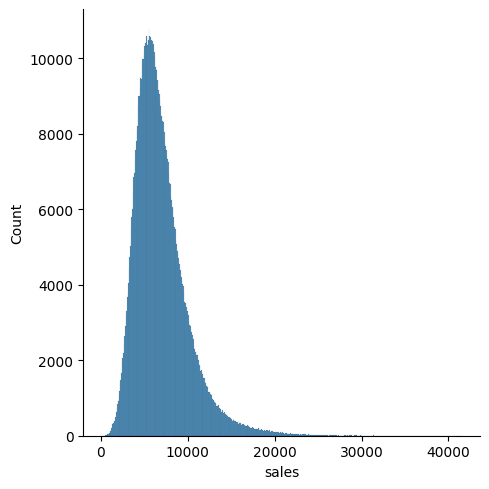

In [175]:
df_filtered_sales = df_1.query('sales != 0')
sns.displot(df_filtered_sales['sales']);

Agora analisando a **competition_distance** vemos que o minimo é 20, que significa que o concorrente mais próximo está a 20 metros. A skew tá em 10 que é um valor muito alto, está muito deslocada para a esquerda (positivo) e uma kurtosis gigantesca, aqui já conseguimos concluir que é um distribuição de dados que tem um pico muito alto depois vai caindo, que significa que tem uma concentração de valores muito alta no começo, muitos concorrentes próximos, a distância entre as lojas concorrentes é pequena.

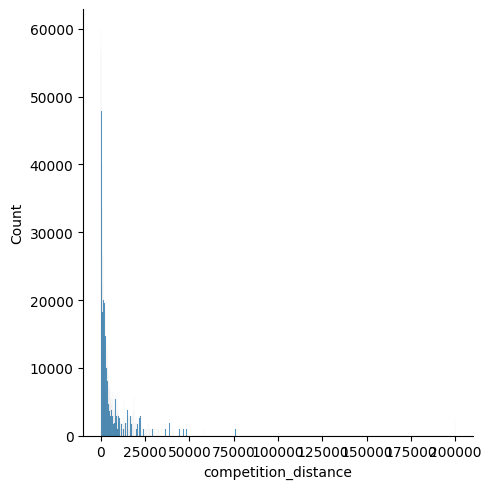

In [176]:
df_filtered_competition_distance = df_1.query('customers < 200000')
sns.displot(df_filtered_competition_distance['competition_distance']);

Na variável **customers** que é o número de clientes em um determinado dia, se vemos a média e o desvio padrão conseguimos concluir que as vezes temos dias que tiveram 1000 clientes e as vezes 200 clientes, tirando assim uma média de una 600 clientes por dia.

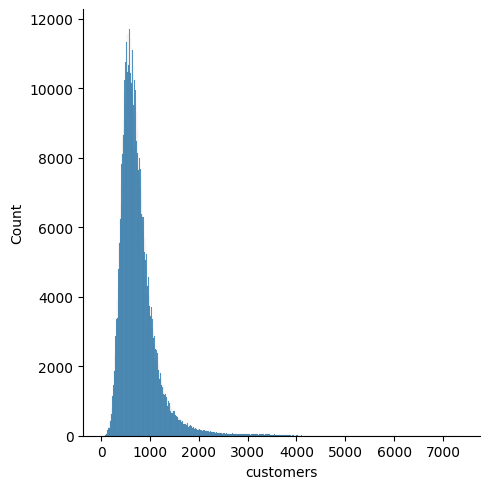

In [177]:
df_filtered_customers = df_1.query('customers != 0')
sns.displot(df_filtered_customers['customers']);

#### 1.5.2.4 - Análise Variáveis Qualitativas (Categoricas)

**store_type** - indica um feriado estadual. Normalmente, todas as lojas, com poucas exceções, estão fechadas em feriados estaduais. Note que todas as escolas estão fechadas em feriados e fins de semana. a = feriado, b = feriado de Páscoa, c = Natal, 0 = Nenhum.

**store_type** - diferencia entre 4 modelos de lojas diferentes: a, b, c, d.

**assortment** - descreve um nível de sortimento: a = básico, b = extra, c = estendido.

In [178]:
atributos_categoricos.apply(lambda x: x.unique().shape[0])

state_holiday      4
store_type         4
assortment         3
promo_interval     4
month_map         12
dtype: int64

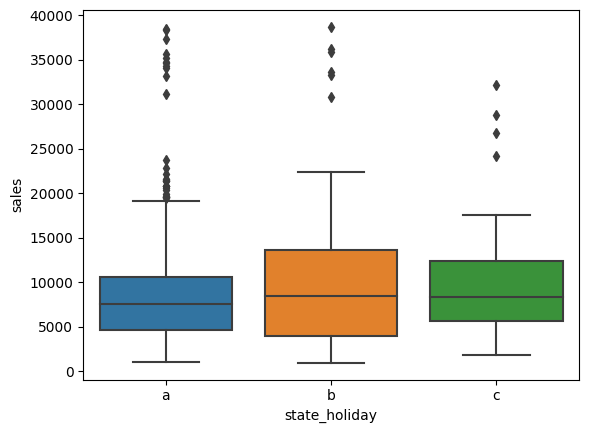

In [179]:
# Tirar os dias que não tiveram venda porque a loja estava fechada e somente vendas acima de 0.
aux_1 = df_1[(df_1['state_holiday']!= '0') & (df_1['sales'] > 0)]
sns.boxplot(x='state_holiday', y='sales', data=aux_1);

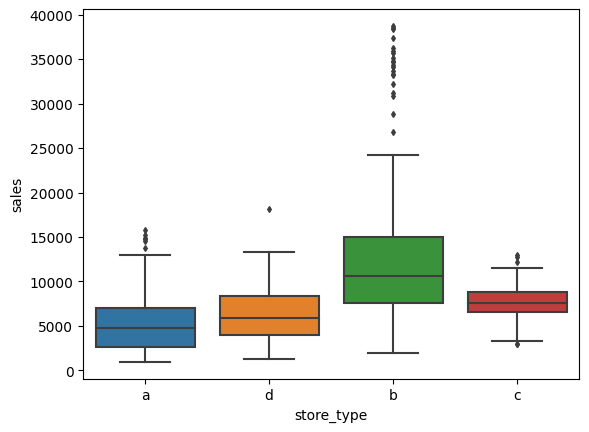

In [180]:
sns.boxplot(x='store_type', y='sales', data=aux_1, fliersize=3);

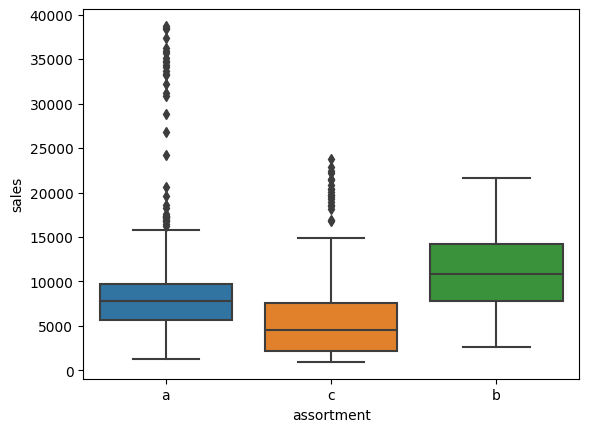

In [181]:
sns.boxplot(x='assortment', y='sales', data=aux_1);

# PASSO 02 - ENGENHARIA DE RECURSOS

<img src='img\mapa_mental_vendas.png'>

## 2.1 - Criação de Hipóteses

Aqui são suposições que eu faço palpites/hipóteses, podem ser verdadeiras ou não, vou utilizar os dados para confirmar essas hipóteses baseadas no mapa mental que fiz anteriormente. Geralmente esse mapa mental e as hipóteses vem de um reunião de brainstorm com os times envolvidos no projeto ou sozinho. As hipóteses são importantes para conseguir encontrar um correlação de uma coisa com outra, não tem a ver com causa e efeito, ou seja, não significa que aumentar algo que uma hipótese confirmou aumentará os lucros. O que precisamos fazer é mapear todos os atributos que impactam nas vendas.

### 2.1.1 - Hipóteses Lojas

    1 - Lojas com maior quantidade de funcionários deveria vender mais: Nesse dataset não consta números de funcionários, não tem como validar;
    
    2 - Lojas com maior capacidade de estoque deveriam vender mais: Não tenho a informação de estoque, não tem como validar;
    
    3 - Lojas com maior porte deveriam vender mais: Não tenho informação do porte da loja, não tem como validar;
    
    4 - Lojas com maior sortimento(variedades de produto) deveriam vender mais: Tenho essa informação no dataset, vou usar na lista final.
    
    5 - Lojas com concorrentes mais perto deveriam vender menos: Tenho essa informação no dataset vou usar na lista final de hipóteses;
    
    6 - Lojas com concorrentes a mais tempo deveriam vender mais: Tenho essa informação no dataset vou usar na lista final de hipóteses;

### 2.1.2 - Hipóteses Produto

    1 - Lojas que tem mais marketing deveriam vender mais: Não tenho a informação de estoque, não tem como validar;
    
    2 - Lojas que expões mais os produtos na vitrine deveriam vender mais: Não tenho a informação de estoque, não tem como validar;
    
    3 - Lojas que tem preços menores(promoção) nos produtos deveriam vender mais;
    
    4 - Lojas com preços menores(promoção) nos produtos por mais tempo deveriam vender mais: Tenho essa informação no dataset vou usar na lista final de hipóteses;
    
    5 - Lojas com promoções por mais dias consecutivos deveriam vender mais: Tenho essa informação no dataset vou usar na lista final de hipóteses;
    
    6 - Lojas com mais promoções consecutivas deveriam vender mais: Tenho essa informação no dataset vou usar na lista final de hipóteses;
   

### 2.1.3 - Hipóteses Tempo (Sazonalidade)

    1 - Lojas abertas em feriados de natal deveriam vender mais: tem como avaliar isso no dataset;
    
    2 - Lojas deveriam vender mais ao longo dos anos: consigo avaliar isso no dataset;
    
    3 - Lojas deveriam vender mais no segundo semestre do ano: consigo avaliar isso no dataset;
    
    4 - Lojas deveriam vender mais após o dia 10 de cada mês: Consigo avaliar também;
    
    5 - Lojas deveriam vender menos aos finais de semana: consigo avaliar;
    
    6 - Lojas deveriam vender menos durante os feriados escolares.
    
    7 - Lojas que que abrem menos nos feriados deveriam vender menos:
    
    8 - Lojas que abrem nos primeiros seis meses deveriam vender mais;
    
    9 - Lojas que abrem nos finais de semana deveriam vender mais.

### 2.1.4 - Lista final de Hipóteses

**Hipóteses de Loja**
    
    1 - Lojas com maior sortimento(variedades de produto) deveriam vender mais: Tenho essa informação no dataset, vou usar na lista final.
    2 - Lojas com concorrentes mais perto deveriam vender menos: Tenho essa informação no dataset vou usar na lista final de hipóteses;
    3 - Lojas com concorrentes a mais tempo deveriam vender mais: Tenho essa informação no dataset vou usar na lista final de hipóteses;

**Hipóteses de Produtos**

    1 - Lojas com preços menores(promoção) nos produtos por mais tempo deveriam vender mais;
    2 - Lojas com promoções por mais dias consecutivos deveriam vender mais;
    3 - Lojas com mais promoções consecutivas deveriam vender mais;

**Hipóteses Tempo (Sazonalidade)**

    1 - Lojas abertas em feriados de natal deveriam vender mais;
    2 - Lojas deveriam vender mais ao longos dos anos;
    3 - Lojas deveriam vender mais no segundo semestre do ano;
    4 - Lojas deveriam vender mais após o dia 10 de cada mês;
    5 - Lojas deveriam vender menos aos finais de semana;
    6 - Lojas deveriam vender menos durante os feriados escolares.

## 2.2 - Feature Engineering

In [182]:
# Copiando o DataFrame para essa sessão.
df_2 = df_1.copy()

### 2.2.1 - Derivação da variável 'date'

In [183]:
# year
df_2['year']= df_2['date'].dt.year

# mounth
df_2['month']= df_2['date'].dt.month

# day
df_2['day']= df_2['date'].dt.day

# week of year
df_2['week_of_year']= df_2['date'].dt.isocalendar().week

# year week
df_2['year_week']= df_2['date'].dt.strftime('%Y-%W')

df_2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,0,0,0,0,0
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


### 2.2.2 - Derivação das variáveis 'competition'

In [184]:
# competition_since -> Desde a data da compra até quando a concorrência começou
# A variável competition_open_since está separada em duas colunas, preciso juntar em uma coluna e depois subtraí o que preciso.
df_2['competition_open_since_year'] = df_2['competition_open_since_year'].astype(int)
df_2['competition_open_since_month'] = df_2['competition_open_since_month'].astype(int)

df_2['competition_since'] = df_2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
df_2['competition_time_month'] = ((df_2['date'] - df_2['competition_since'])/30).apply(lambda x: x.days).astype(int)

### 2.2.3 - Derivação das variáveis 'promo'

In [185]:
# promo_since -> Desde quando tenho a promoção ativa.
# Aqui o problema que temos duas variais promo2_since que pega o ano e a semana, não temos o mês, ai precisamos fazer alguns ajustes.
df_2['promo_since'] = df_2['promo2_since_year'].astype(str) + '-' + df_2['promo2_since_week'].astype(str)
df_2['promo_since'] = df_2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - pd.Timedelta(days=7))

# Tempo que a promoção está ativa em semanas
df_2['promo_time_week'] = ((df_2['date'] - df_2['promo_since'])/7).apply(lambda x: x.days).astype(int) # Extrair os dias do resultado

### 2.2.4 - Sobrescrevendo a variável 'assortment'

In [186]:
# Assortment -> Nível da variedades de produtos
df_2['assortment'] = df_2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

### 2.2.5 - Sobrescrevendo a variável 'state_holiday'

In [187]:
# State Holiday -> Feriados
df_2['state_holiday'] = df_2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else  'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')
df_2['state_holiday'].value_counts()

state_holiday
regular_day       986159
public_holiday     20260
easter_holiday      6690
christmas           4100
Name: count, dtype: int64

### 2.2.6 - Resultado

In [188]:
df_2.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
state_holiday,regular_day,regular_day,regular_day,regular_day,regular_day
school_holiday,1,1,1,1,1
store_type,c,a,a,c,a


# PASSO 03 - FILTRAGEM DE VARIÁVEIS

Um dos principais motivos para filtrar variáveis são as Restrições de negócios, para que no final do projeto a gente consiga colocar o projeto em produção.

**Filtragem de Variáveis:**
- Restrições de Acordo com o Negócio.

**Seleção de Variáveis:**
- Variáveis mais relevantes para o MODELO.

In [189]:
df_3 = df_2.copy()

## 3.1 - Filtragem das Linhas

In [190]:
# Só quero as linhas diferente de 0 na coluna 'open' que são as lojas abertas.
# Só quero as linhas maiores que 0 na coluna 'sales'.
df_3 = df_3[(df_3['open'] != 0) & (df_3['sales'] > 0)]

## 3.2 - Seleção de Colunas

In [191]:
# Colunas que não vou usar: 'customers'. Não tenho como saber, no momento, quantas pessoas vão estar na loja daqui 6 semanas.
cols_drop = ['customers', 'open', 'promo_interval', 'month_map']
df_3.drop(cols_drop, axis=1)

,store,day_of_week,date,sales,promo,state_holiday,school_holiday,store_type,assortment,competition_distance,...,is_promo,year,month,day,week_of_year,year_week,competition_since,competition_time_month,promo_since,promo_time_week
0,1,5,2015-07-31,5263,1,regular_day,1,c,basic,1270.0,...,0,2015,7,31,31,2015-30,2008-09-01,84,2015-07-27,0
1,2,5,2015-07-31,6064,1,regular_day,1,a,basic,570.0,...,1,2015,7,31,31,2015-30,2007-11-01,94,2010-03-22,279
2,3,5,2015-07-31,8314,1,regular_day,1,a,basic,14130.0,...,1,2015,7,31,31,2015-30,2006-12-01,105,2011-03-28,226
3,4,5,2015-07-31,13995,1,regular_day,1,c,extended,620.0,...,0,2015,7,31,31,2015-30,2009-09-01,71,2015-07-27,0
4,5,5,2015-07-31,4822,1,regular_day,1,a,basic,29910.0,...,0,2015,7,31,31,2015-30,2015-04-01,4,2015-07-27,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1016776,682,2,2013-01-01,3375,0,public_holiday,1,b,basic,150.0,...,0,2013,1,1,1,2013-00,2006-09-01,77,2012-12-31,0
1016827,733,2,2013-01-01,10765,0,public_holiday,1,b,extra,860.0,...,0,2013,1,1,1,2013-00,1999-10-01,161,2012-12-31,0
1016863,769,2,2013-01-01,5035,0,public_holiday,1,b,extra,840.0,...,1,2013,1,1,1,2013-00,2013-01-01,0,2012-11-19,6
1017042,948,2,2013-01-01,4491,0,public_holiday,1,b,extra,1430.0,...,0,2013,1,1,1,2013-00,2013-01-01,0,2012-12-31,0


# PASSO 04 - ANÁLISE EXPLORATÓRIA DE DADOS (EDA)

**Análise Univariada:**
- Me importo só com uma variável, como a variável funciona, como ela é (min, max, range, distribuição,...).

**Análise Bivariada:**
- Como uma determinada variável impacta na variável resposta? (Correlação, validação da hipóteses....).

**Análise Multivariada:**
- Como as variáveis se relacionam entre sí e com a variável resposta.

In [192]:
df_4 = df_3.copy()

## 4.1 - Análise Univariada

### 4.1.1 - Variável Resposta (target)

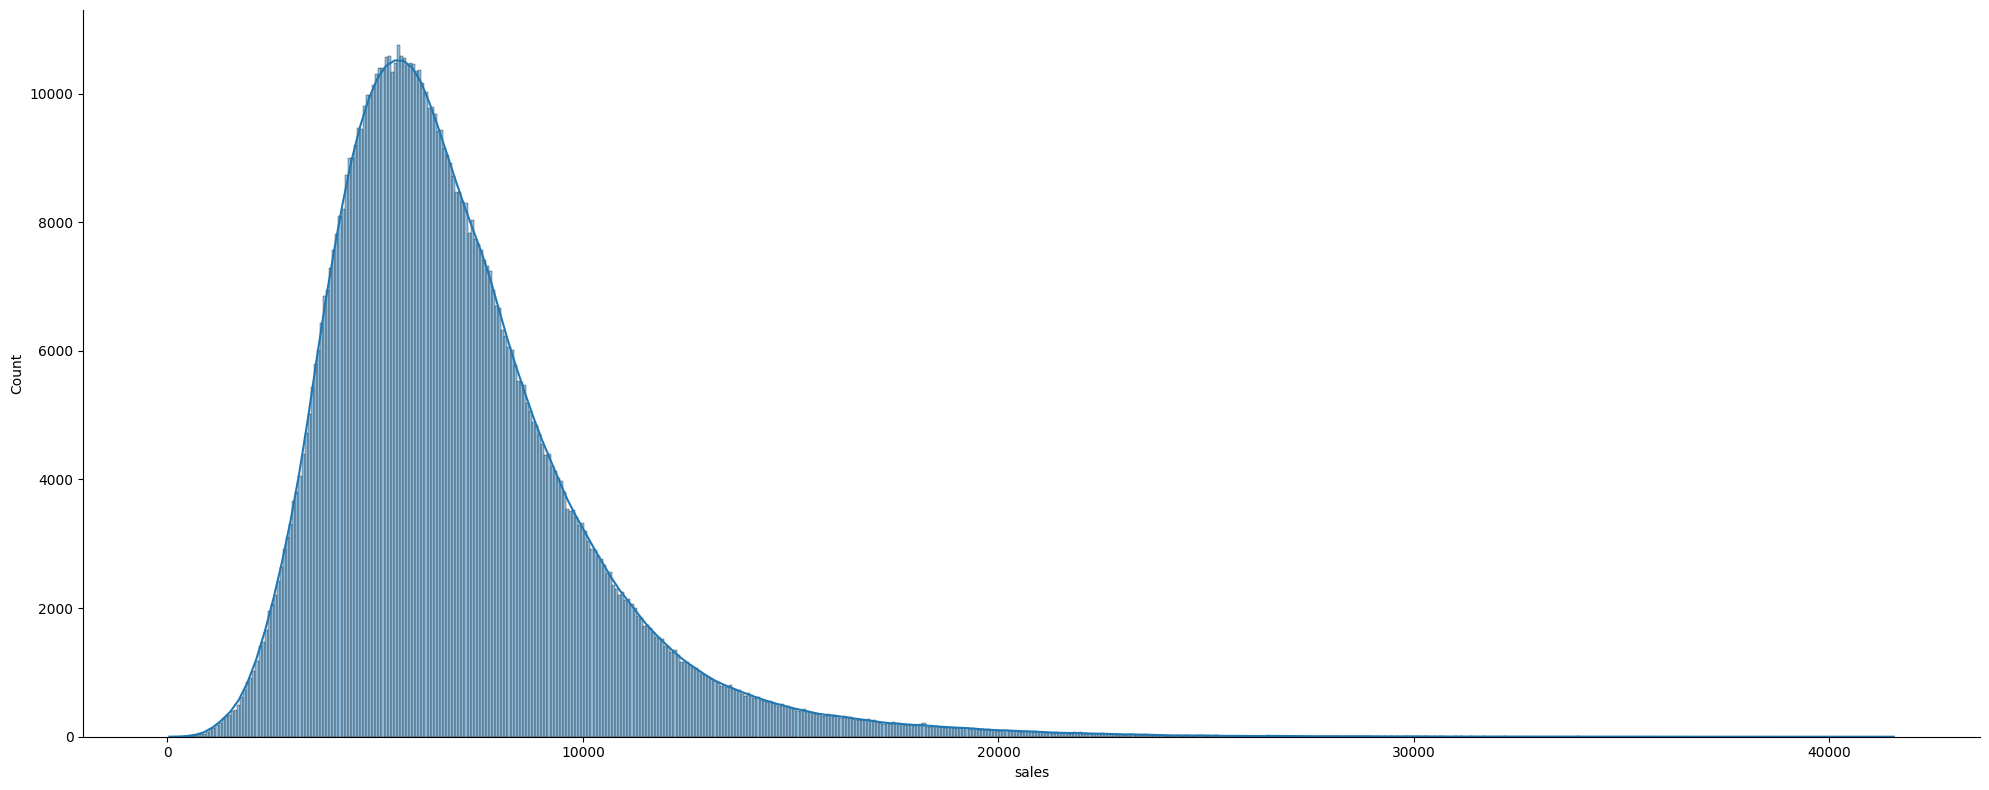

In [193]:
sns.displot(df_4['sales'], height=8, aspect=2.5, kde=True);

Tá bem parecida com uma distribuição normal, mas não é uma normal pois não está centrada. Quanto mais a minha target se parecer com uma distribuição normal melhor meu modelo irá performar.

### 4.1.2 - Variável Numérica

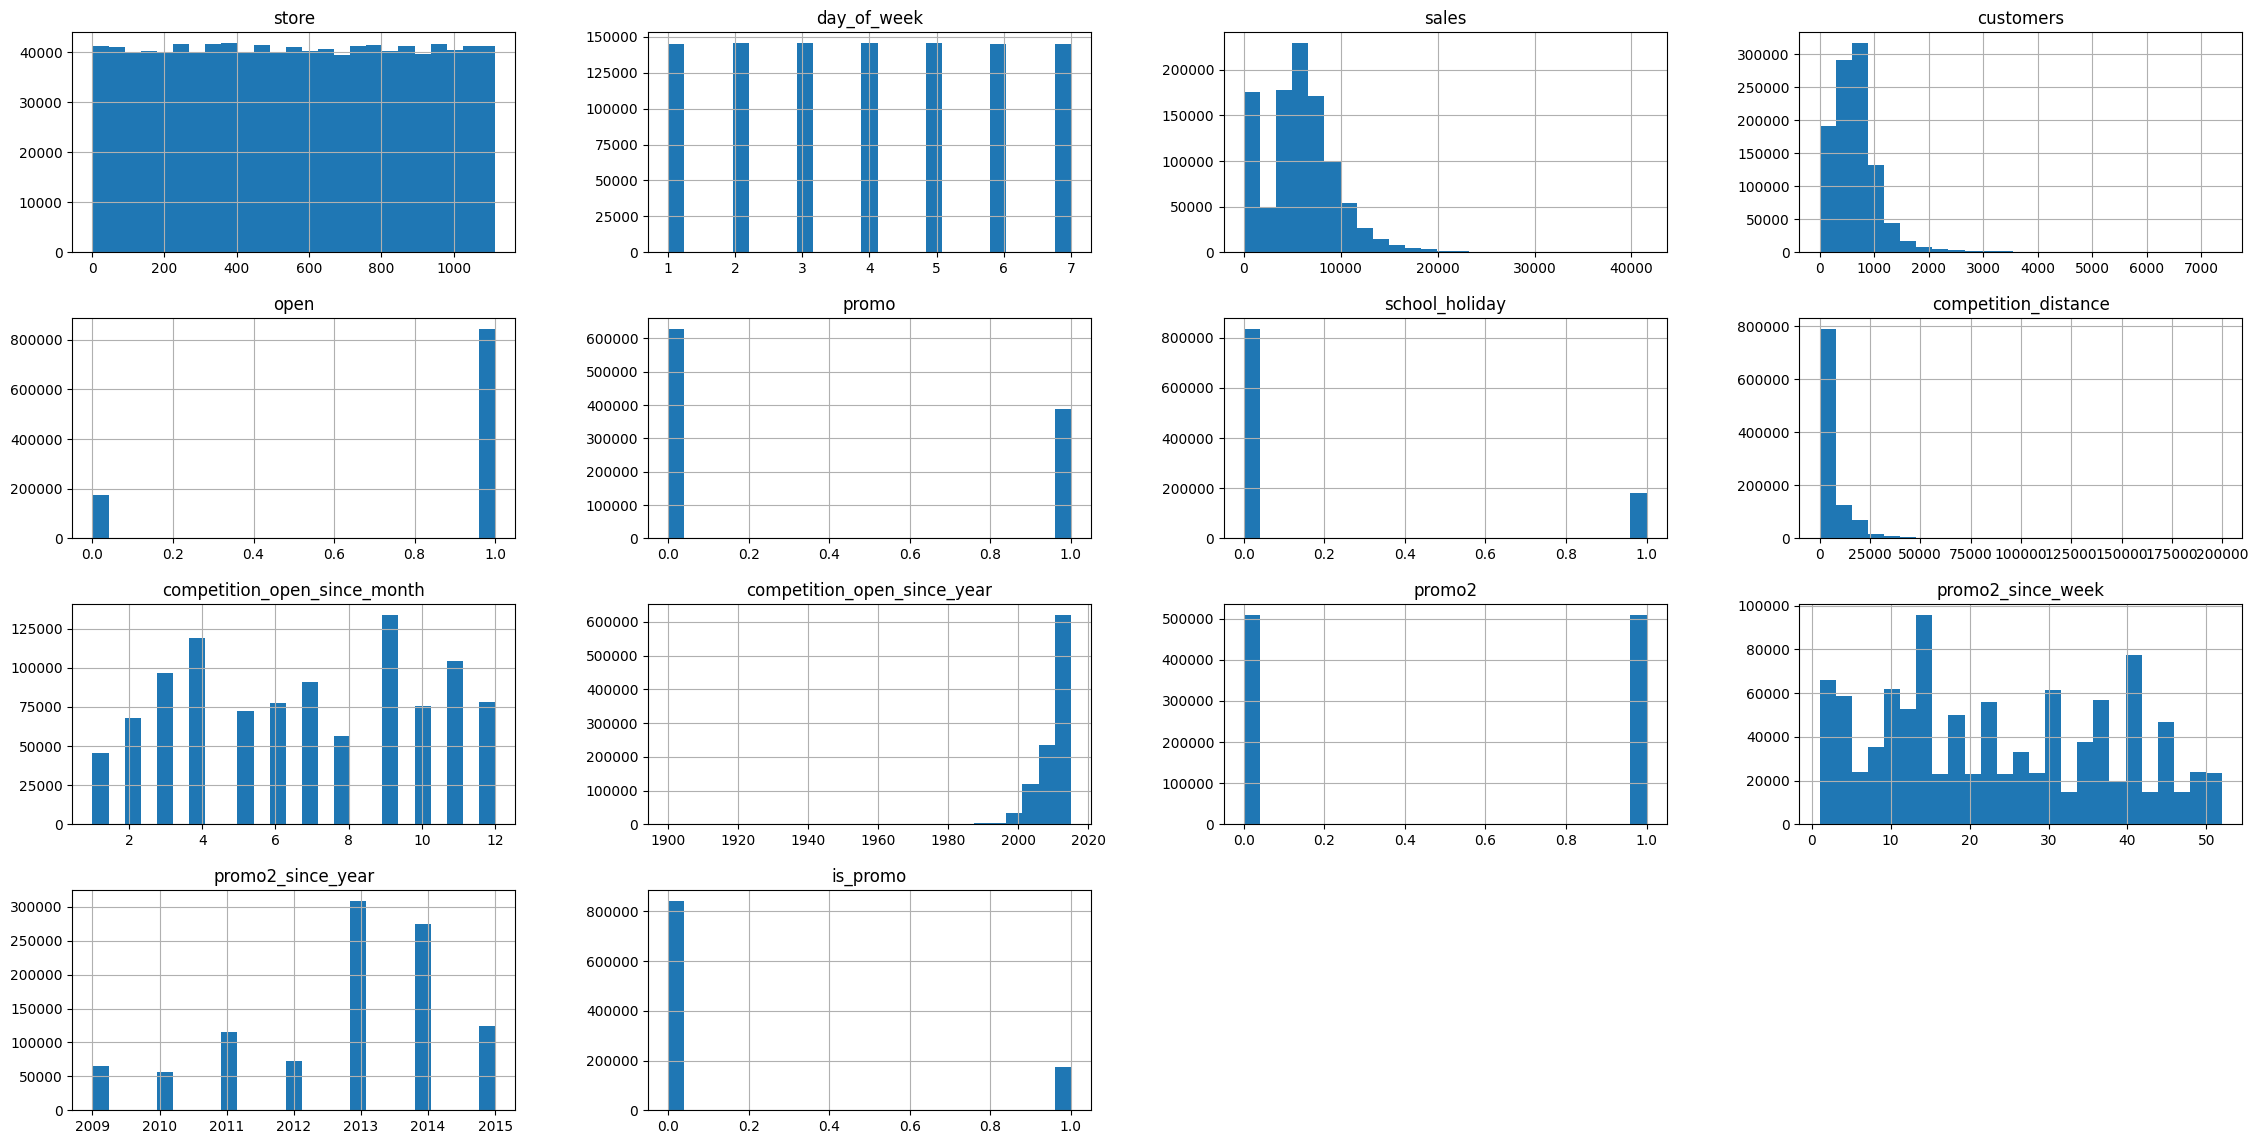

In [194]:
atributos_numericos.hist(figsize=(28, 14), bins=25);

- **competition_distance:** basicamente me diz que as lojas estão bem próximas uma das outras, grande volume de dados concentrado no inicio do gráfico.
- **competition_open_since_month:** Mostra que temos alguns grandes picos de avendas de lojas no meses 4 e 9, uma tendência.
- **day_of_week:** Sem variações ou padrões no gráfico, sozinha não agreda informações para o modelo.
- **is_promo:** Essa variável tem um insight interessante, mostra que temos muito mais vendas quando não temos promoção, da para explorar mais para ver o que conseguimos tirar dessa variável. As vezes pode ser porque temos menos dias de promoção do que dias normais de venda.
- **promo2_since_year:** Tentar entender porque teve um pico tão alto de vendas em 2013 e depois foi caindo.

### 4.1.3 - Variável Categórica

In [195]:
atributos_categoricos.columns

Index(['state_holiday', 'store_type', 'assortment', 'promo_interval',
       'month_map'],
      dtype='object')

#### state_holiday

In [196]:
df_4['state_holiday'].value_counts()

state_holiday
regular_day       843428
public_holiday       694
easter_holiday       145
christmas             71
Name: count, dtype: int64

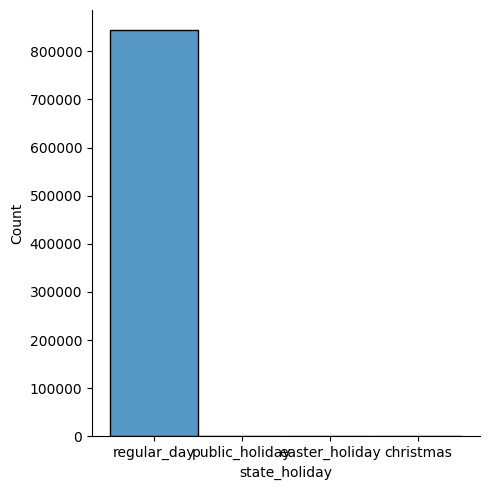

In [197]:
sns.displot(df_4['state_holiday']);

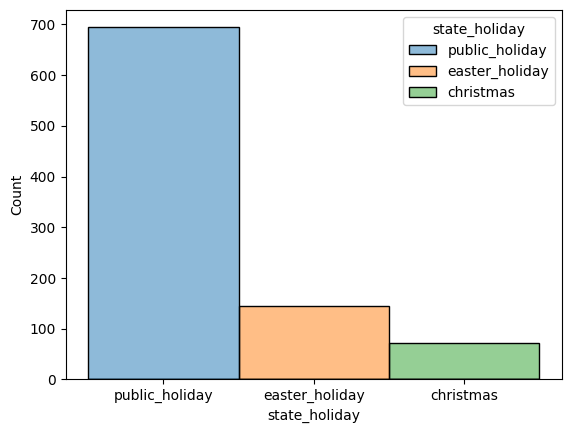

In [198]:
a = df_4[df_4['state_holiday'] != 'regular_day']
sns.histplot(data=a, x='state_holiday', hue='state_holiday');

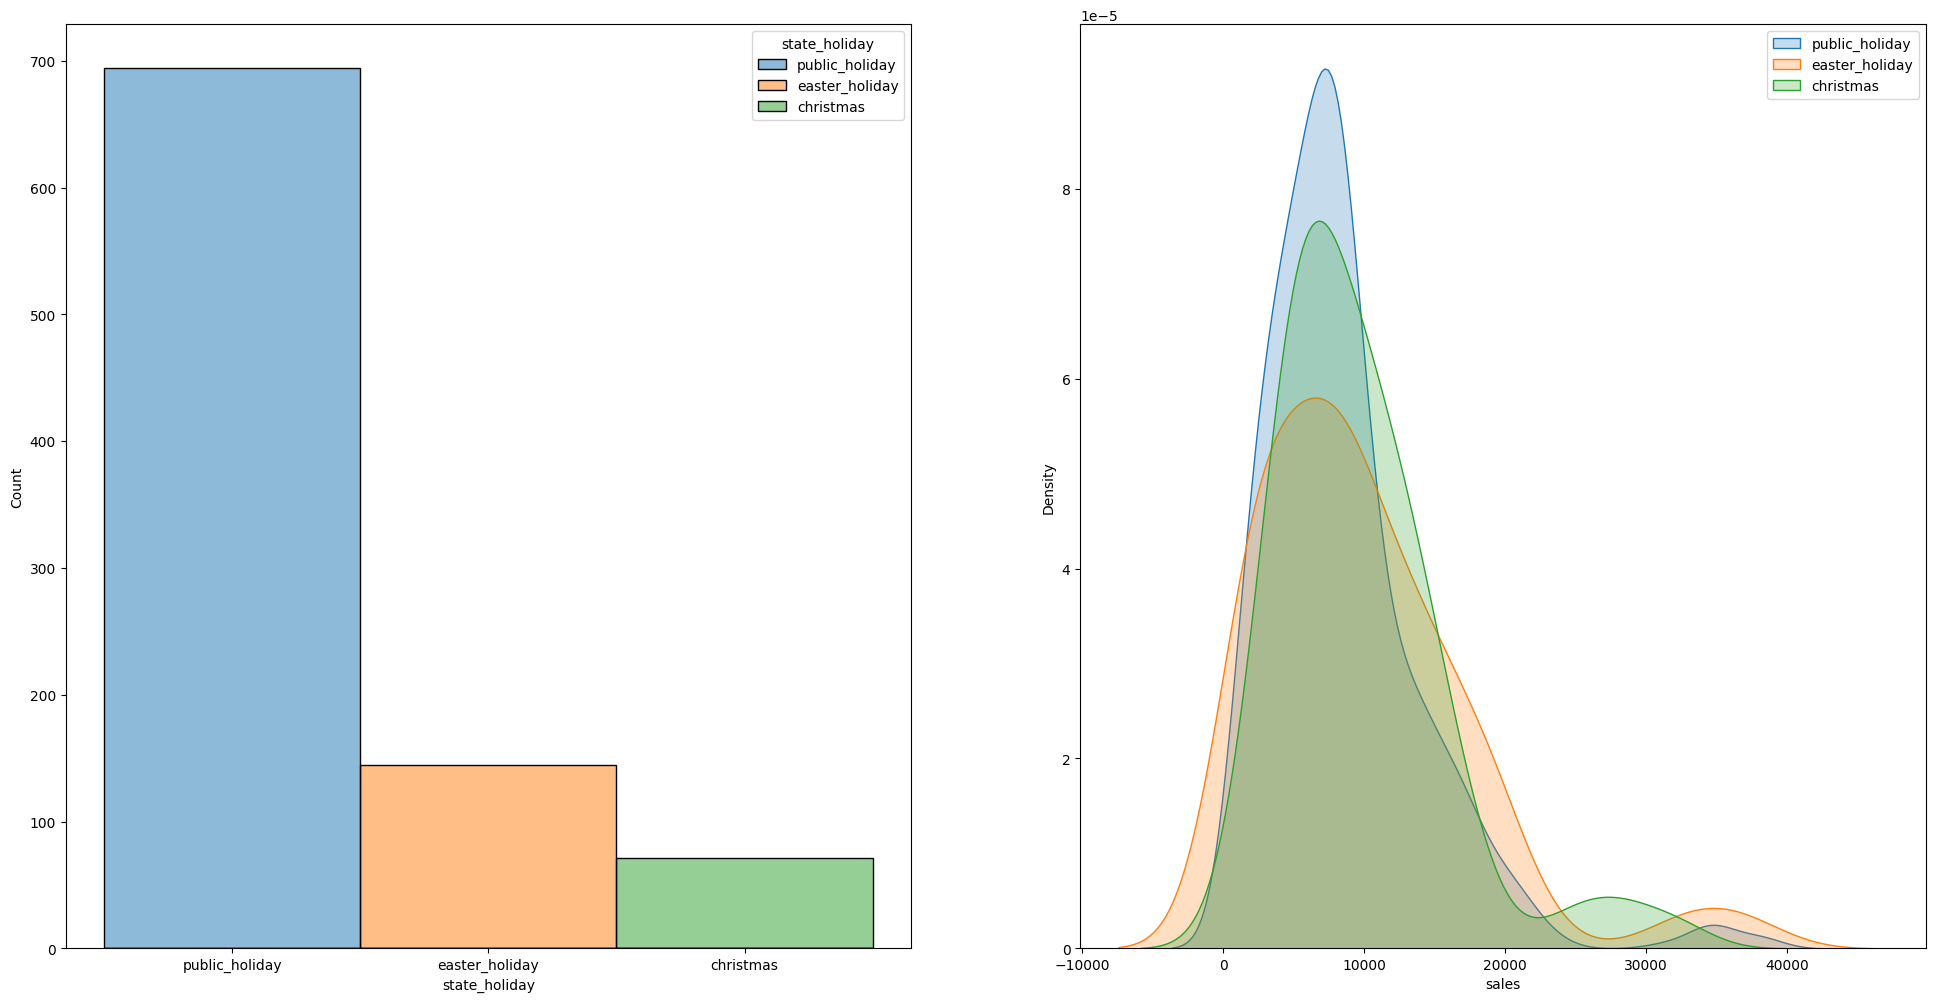

In [199]:
plt.figure(1, figsize=(24, 12))

plt.subplot(1, 2, 1)
a = df_4[df_4['state_holiday'] != 'regular_day']
sns.histplot(data=a, x='state_holiday', hue='state_holiday');

plt.subplot(1, 2, 2)
sns.kdeplot(data=df_4[df_4['state_holiday'] == 'public_holiday']['sales'], label='public_holiday', fill=True);
sns.kdeplot(data=df_4[df_4['state_holiday'] == 'easter_holiday']['sales'], label='easter_holiday', fill=True);
sns.kdeplot(data=df_4[df_4['state_holiday'] == 'christmas']['sales'], label='christmas', fill=True);
plt.legend();


Mesmo o christmas tendo menos dias de feriado ele tem uma densidade de venda com um pico maior que o easter_holiday, interessante.

state_holiday se mostra como uma variável importante para o aprendizado do modelo.

#### store_type

In [200]:
df_4['store_type'].value_counts()

store_type
a    457042
d    258768
c    112968
b     15560
Name: count, dtype: int64

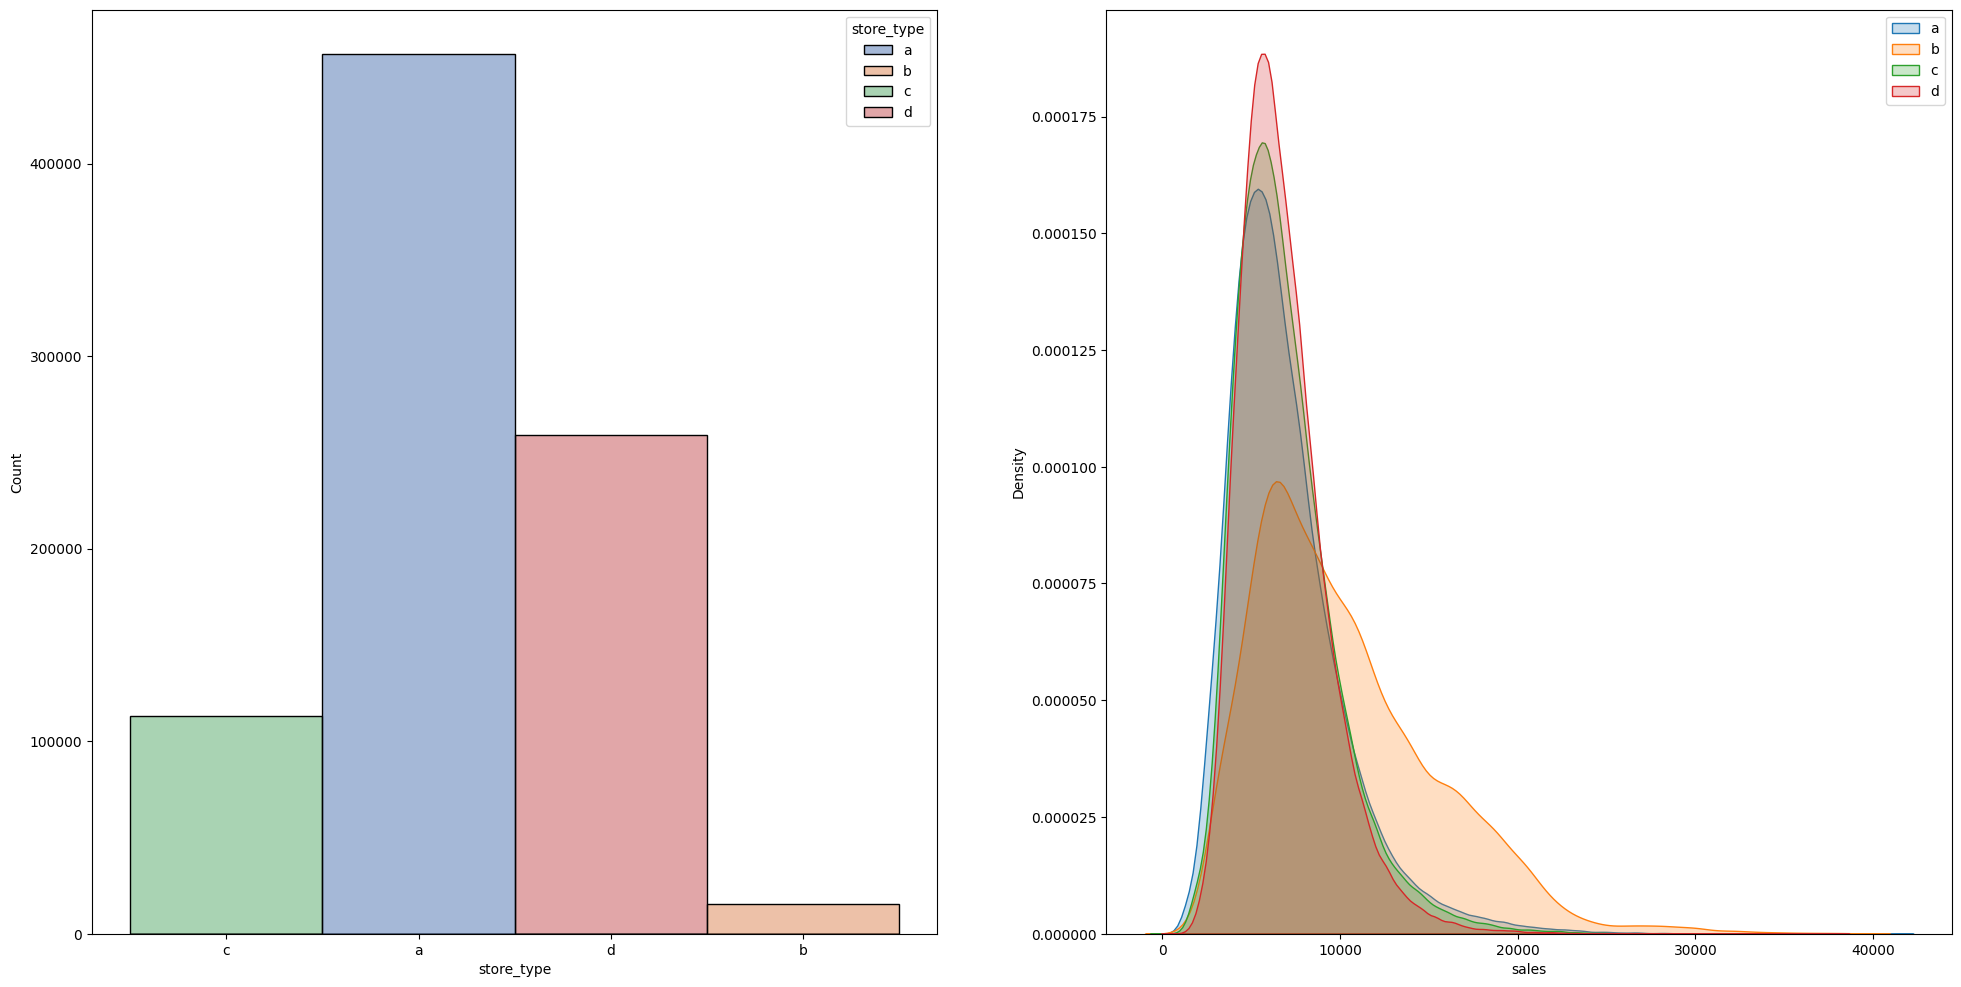

In [201]:
plt.figure(1, figsize=(24, 12))

plt.subplot(1, 2, 1)
sns.histplot(data=df_4, x='store_type', palette='deep', hue='store_type', legend=True,  hue_order=['a', 'b', 'c', 'd']);

plt.subplot(1, 2, 2)
sns.kdeplot(data=df_4[df_4['store_type'] == 'a']['sales'], label='a', fill=True);
sns.kdeplot(data=df_4[df_4['store_type'] == 'b']['sales'], label='b', fill=True);
sns.kdeplot(data=df_4[df_4['store_type'] == 'c']['sales'], label='c', fill=True);
sns.kdeplot(data=df_4[df_4['store_type'] == 'd']['sales'], label='d', fill=True);
plt.legend();

#### assortment

In [202]:
df_4['assortment'].value_counts()

assortment
basic       444875
extended    391254
extra         8209
Name: count, dtype: int64

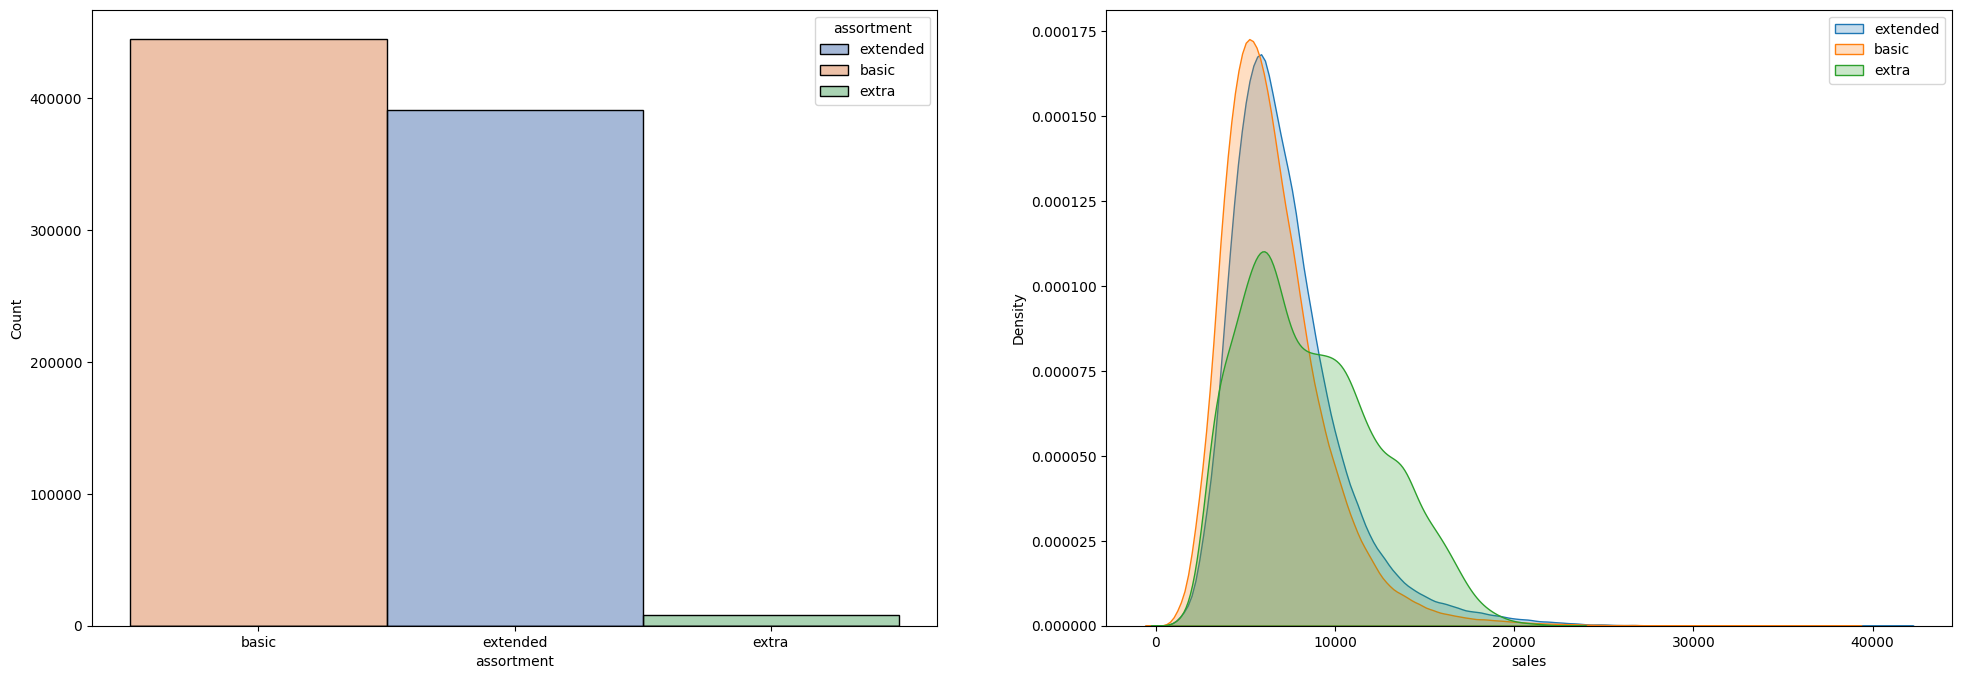

In [203]:
plt.figure(1, figsize=(24,8))

plt.subplot(1, 2, 1)
sns.histplot(data=df_4, x='assortment', palette='deep', hue='assortment', legend=True,  hue_order=['extended', 'basic', 'extra']);

plt.subplot(1, 2, 2)
sns.kdeplot(data=df_4[df_4['assortment'] == 'extended']['sales'], label='extended', fill=True);
sns.kdeplot(data=df_4[df_4['assortment'] == 'basic']['sales'], label='basic', fill=True);
sns.kdeplot(data=df_4[df_4['assortment'] == 'extra']['sales'], label='extra', fill=True);
plt.legend();

## 4.2 - Análise Bivariada

O foco aqui é encontrar o impacto(correlações) de uma variável(feature) em relação a variável resposta(target).

### 4.2.1 - Validando as Hipóteses de Loja

#### H1 - Lojas com maior sortimento(variedades de produto) deveriam vender mais (FALSA)

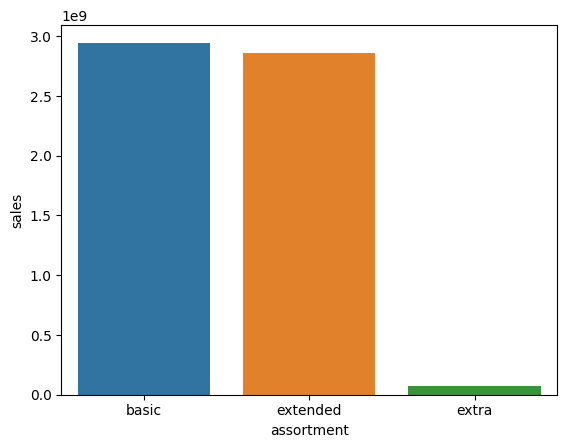

In [204]:
aux_assortment_1 = df_4[['assortment', 'sales']].groupby('assortment').sum().reset_index()
sns.barplot(data=aux_assortment_1, x='assortment', y='sales');

**Analisando o gráfico conseguimos provar que o que acontece na realidade é o contrário da H1. Na realidade lojas com sortimento maior (extra) VENDEM MENOS. A hipótese que lojas com maior sortimento vendem mais é FALSA.**

Um outro questionamento é se as lojas com assortment extra já vendeu muito em algum momento e devido a algum acontecimento começou a vender menos, podemos analisar com uma linha do tempo.

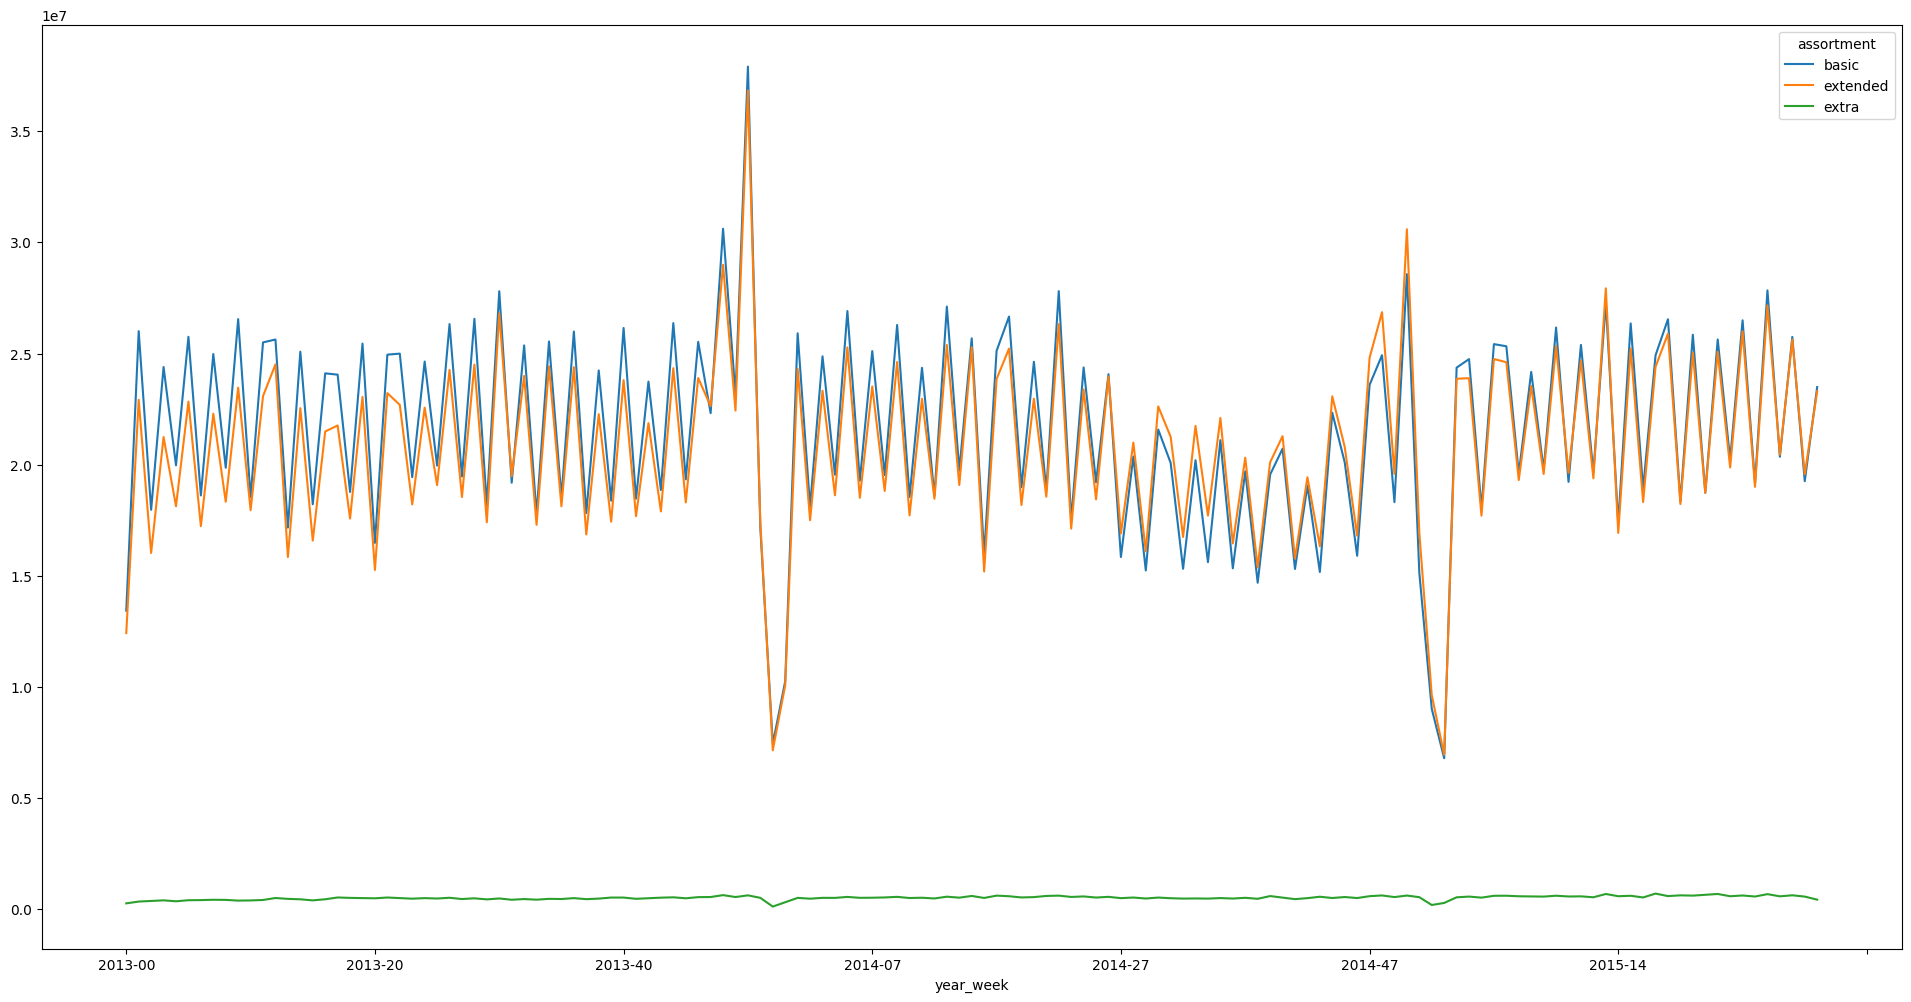

In [205]:
aux_assortment_2 = df_4[['year_week','assortment', 'sales']].groupby(['year_week','assortment']).sum().reset_index()

aux_assortment_2.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(24,12));

O basic e o extended são praticamente iguais ao longo do tempo, apesar do basic ser um pouco maior durante boa parte do tempo. Por isso o volume de vendas é muito pareciso e o basic é um pouquinho maior.

Como o basic e extended puxa a escala muito para cima devido ao grande volume de vendas que eles tem, vou fazer uma análise filtrada do extra para saber se o comportamento é mais "linear" ou se tem um comportamente diferente.

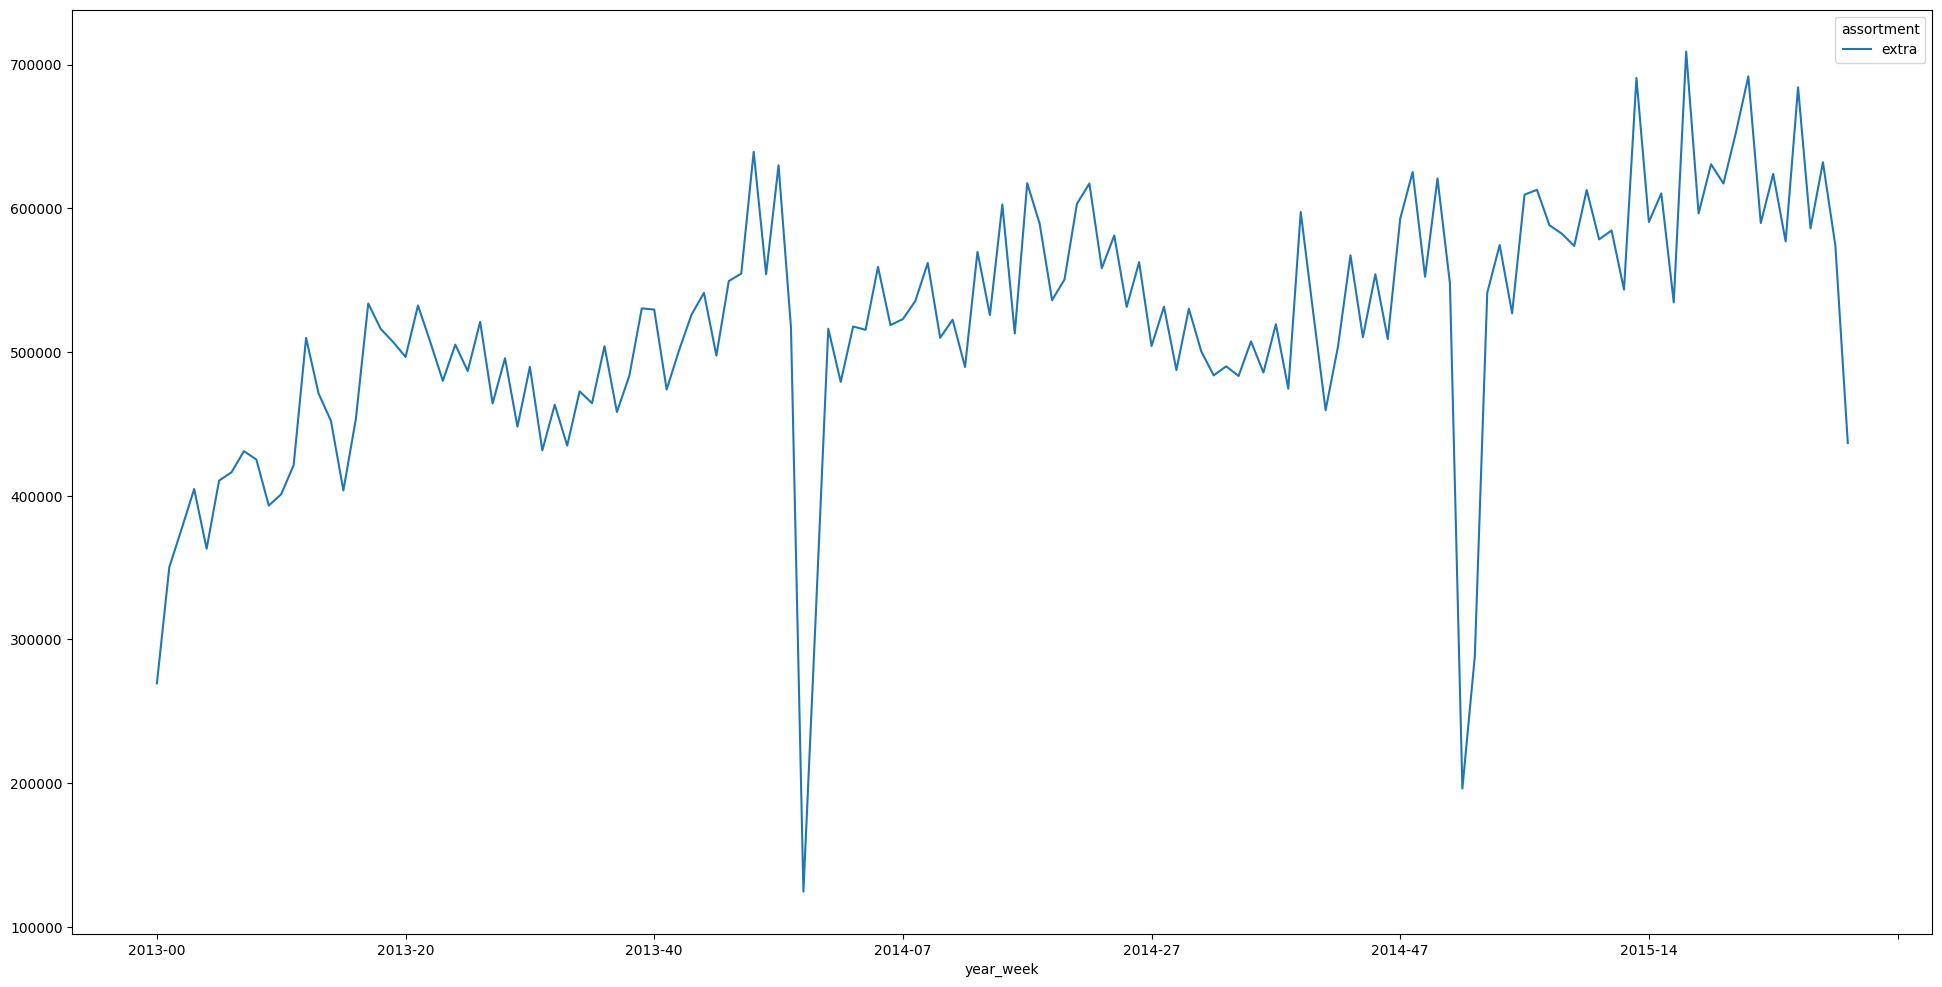

In [206]:
aux_assortment_3 = aux_assortment_2[aux_assortment_2['assortment'] == 'extra']
aux_assortment_3.pivot(index='year_week', columns='assortment', values='sales').plot(figsize=(24,12));


#### H2 - Lojas com concorrentes mais perto deveriam vender menos (FALSA)

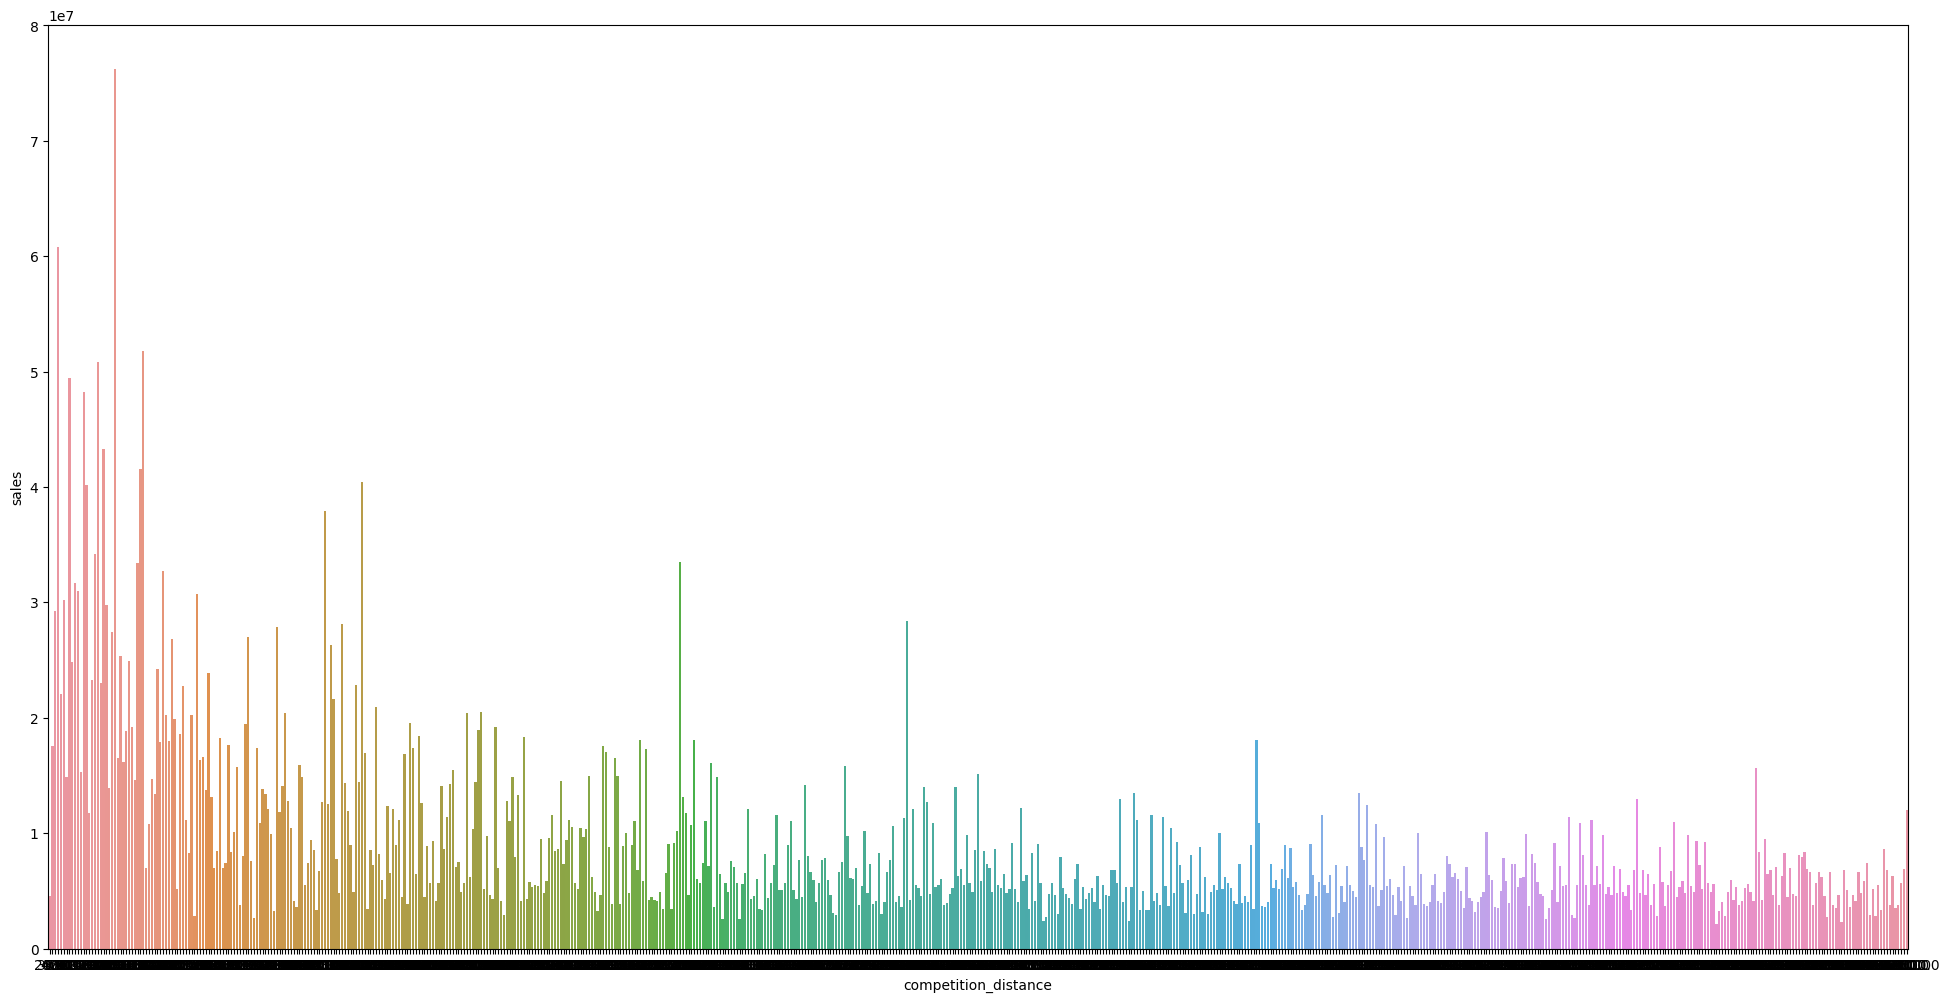

In [207]:
aux_competition_distance_1 = df_4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(24,12))
sns.barplot(data=aux_competition_distance_1, x='competition_distance', y='sales');

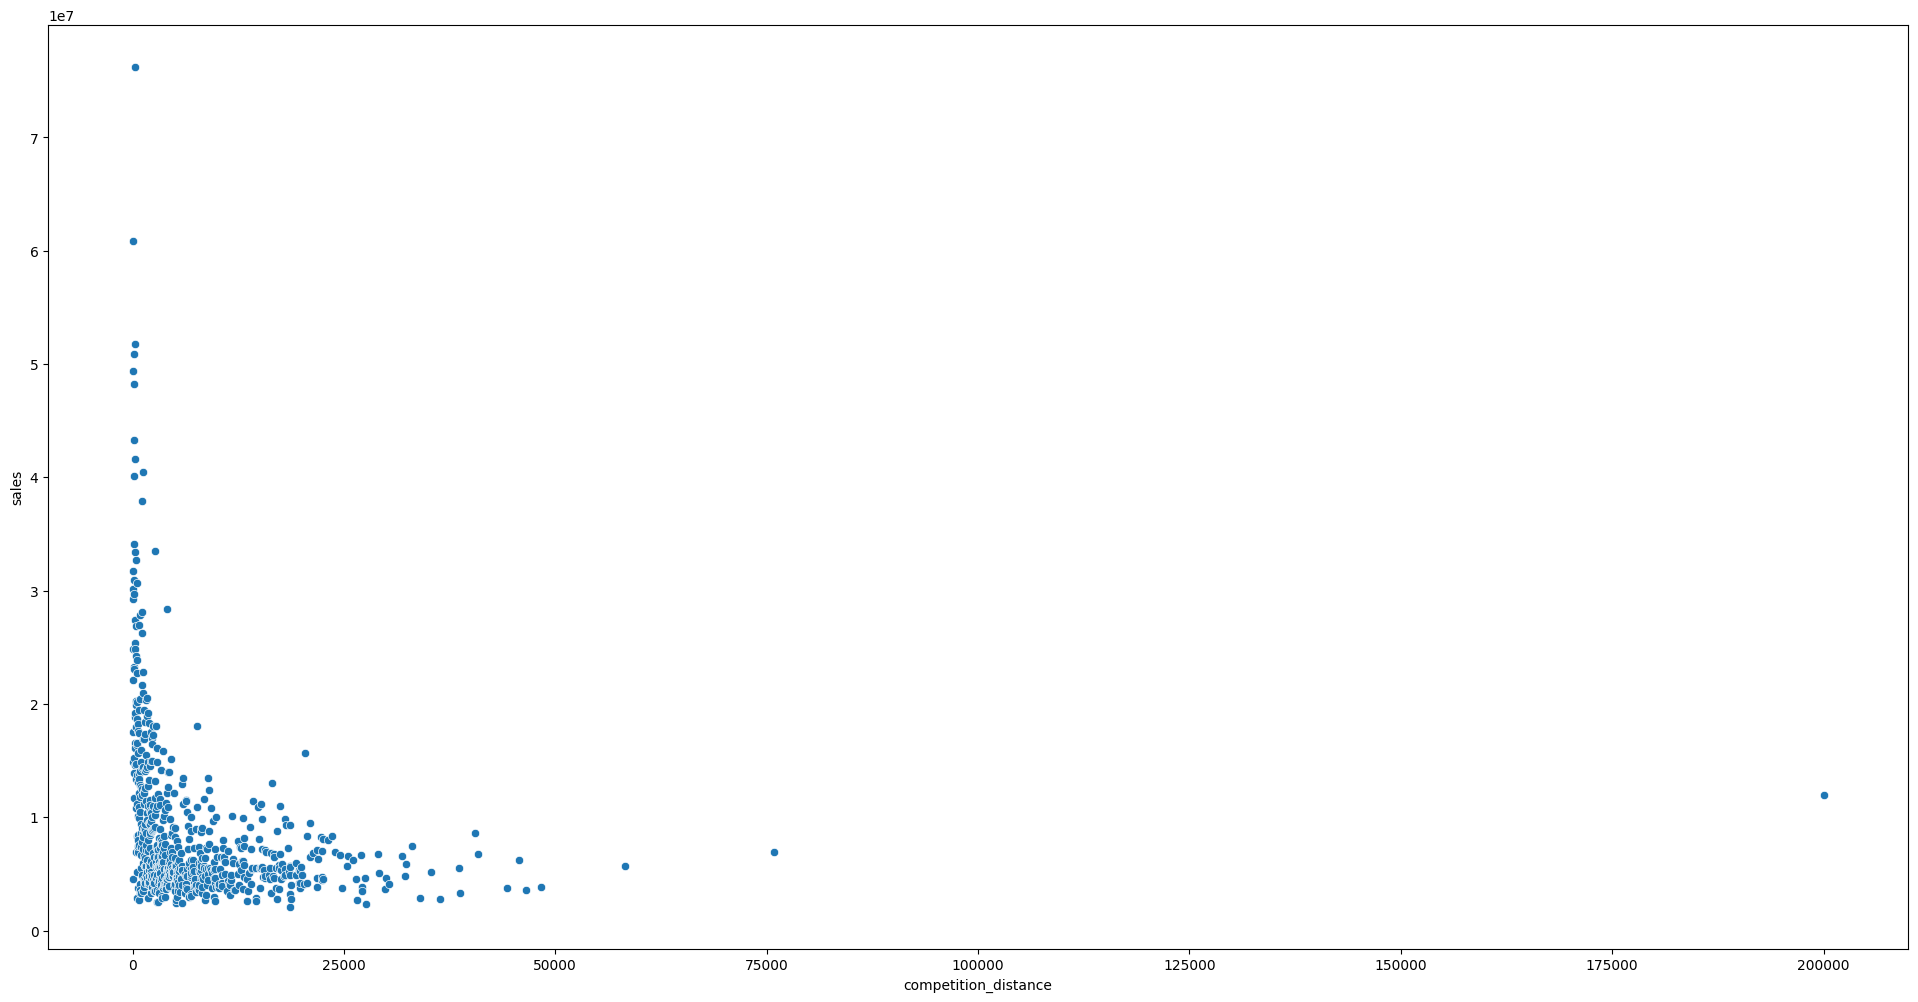

In [208]:
# Uma forma de conseguir visualizar melhor o gráfico de barras anterior é plotando um scatterplot desses dados para conceguir visualizar melhor a concentração dos dados
aux_competition_distance_1 = df_4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

plt.figure(figsize=(24,12))
sns.scatterplot(data=aux_competition_distance_1, x='competition_distance', y='sales');

O gráfico de barras anterior ficou muito granular, não da para entender os dados, o melhor a se fazer para conseguir analisar o gráfico desses dados é agrupar a feature 'competition_distance' por grupos maiores de distancia.

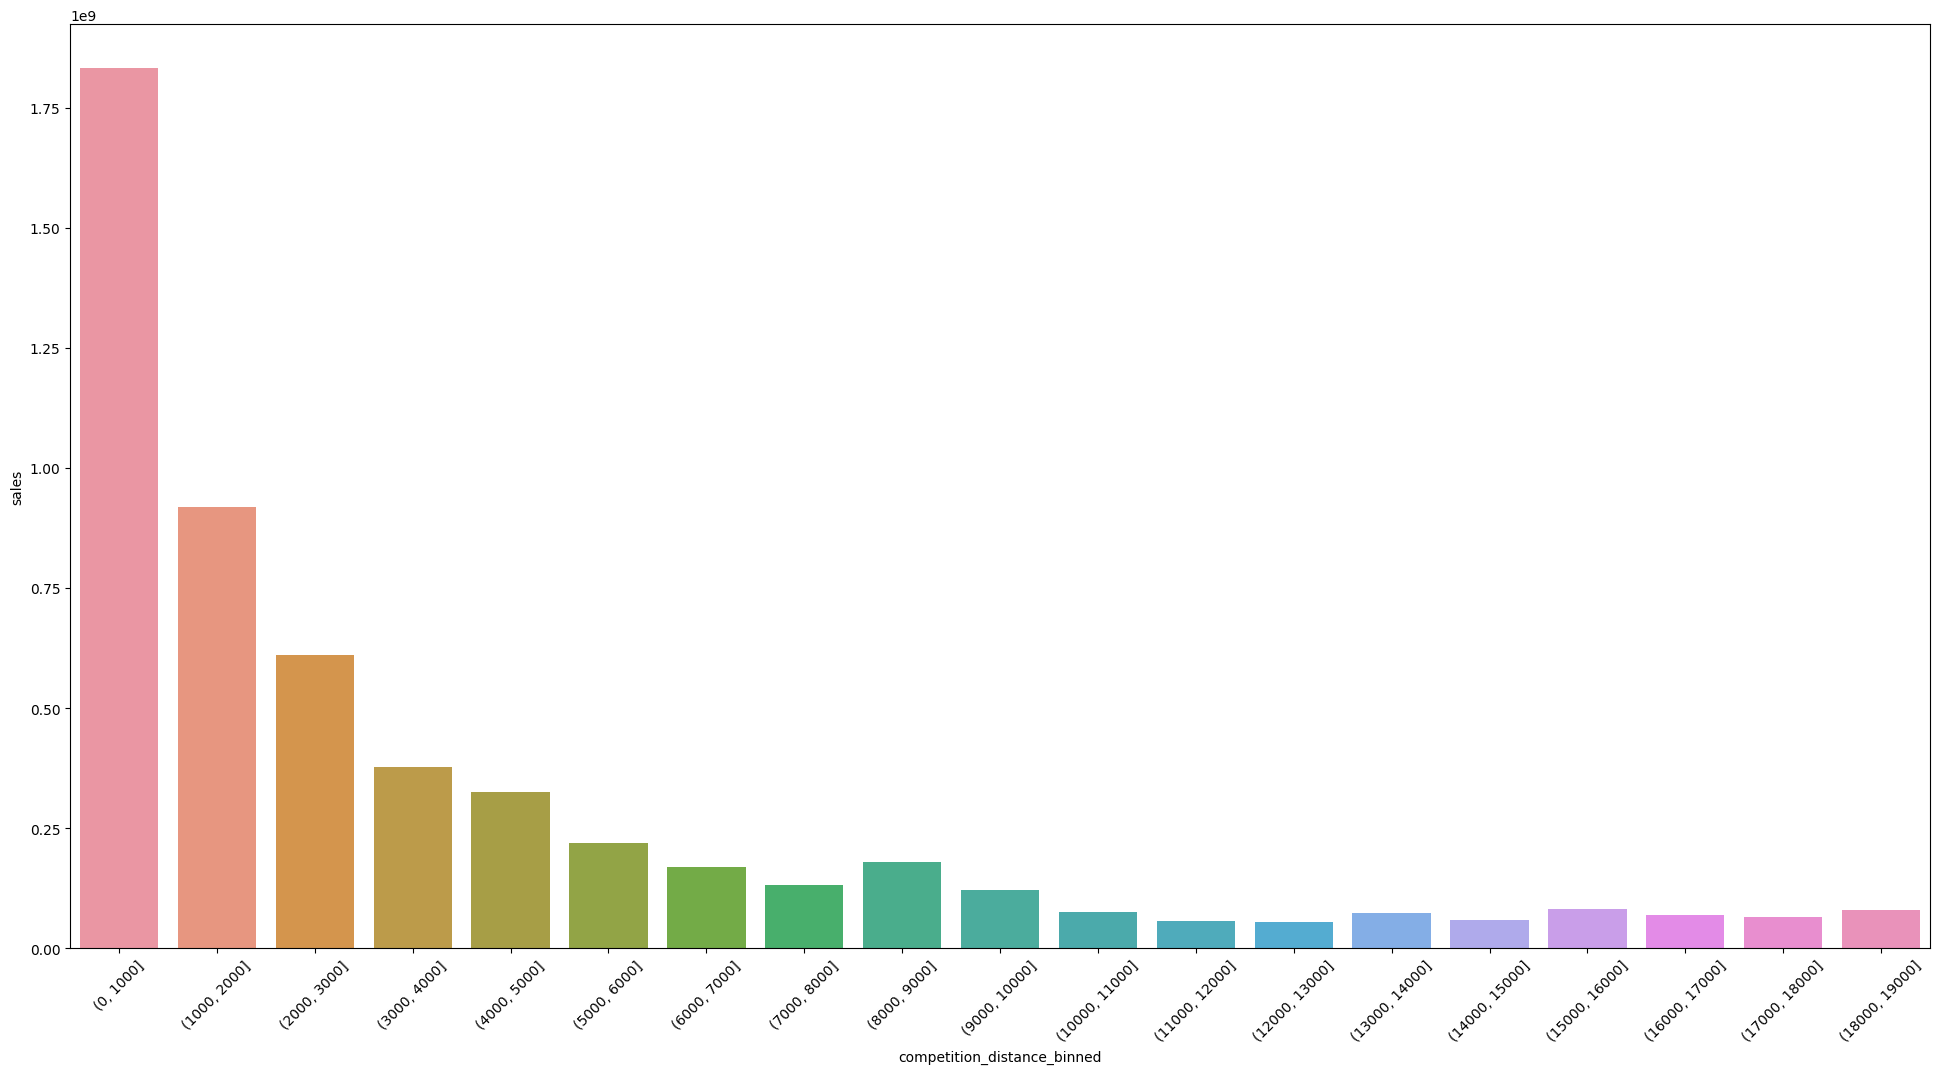

In [209]:
aux_competition_distance_1 = df_4[['competition_distance', 'sales']].groupby('competition_distance').sum().reset_index()

bins = list(np.arange(0, 20000, 1000))
# bins = list(np.arange(0, 25000, 1500)) -> visualização alternativa bacana
# bins = list(np.arange(0, 50000, 2500)) -> visualização alternativa bacana

aux_competition_distance_1['competition_distance_binned'] = pd.cut(aux_competition_distance_1['competition_distance'], bins=bins)

aux_competition_distance_2 = aux_competition_distance_1[['competition_distance_binned', 'sales']].groupby('competition_distance_binned').sum().reset_index()

plt.figure(figsize=(24,12))
sns.barplot(data=aux_competition_distance_2, x='competition_distance_binned', y='sales');
plt.xticks(rotation=45);

**Nós somos levados a crer que quando tem muitas lojas próximas uma da outra a tendência é haver uma competição e ter menos venda, mas o gráfico nos diz o contrário, as lojas com competidores próximos vendem mais que lojas sem competidores próximos. Logo, a H2 é FALSA.**

Uma das explicações para esse efeito é que quando temos muitas lojas próximas, concorrente, acaba criando um centro comercial que aumenta o número de vendas das lojas nessa região.

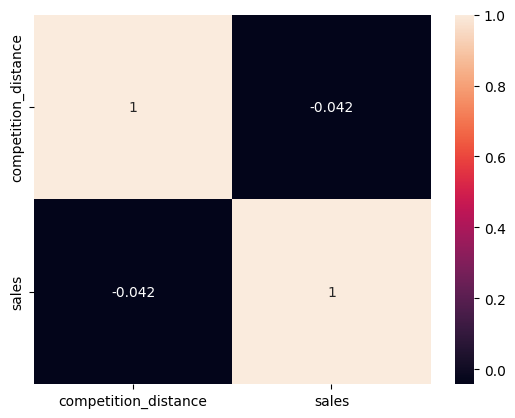

In [210]:
# Gráfico que mede a força da correlação da competition_distance e a 'sales',
# para termos uma noção melhor do impacto dessa feature na variável resposta (target -> 'sales').

sns.heatmap(df_4[['competition_distance', 'sales']].corr(method='pearson'), annot=True);

Quando a correlação de Pearson é próxima de zero (seja positiva ou negativa), isso indica que as duas variáveis têm pouca ou nenhuma relação linear. Nesse caso, não é possível estabelecer uma relação direta e consistente entre as duas variáveis com base na correlação.

Esse valor muito próximo de zero diz que há uma tendência muito leve de que, em média, à medida que a distância entre as lojas concorrentes aumenta, o número de vendas diminui ligeiramente, e vice-versa. No entanto, essa relação é praticamente insignificante, dado o valor próximo a zero da correlação.

#### H3 - Lojas com concorrentes a mais tempo deveriam vender mais (FALSA)

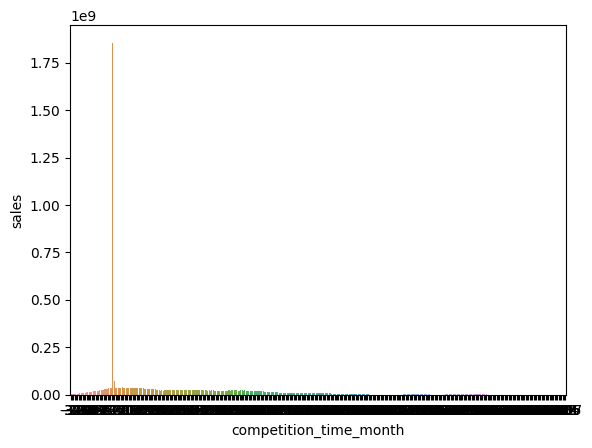

In [211]:
# Vou usar a variável que derivei competition_time_month que pega exatamente o tempo que a loja está aberta para saber como influencia nas vendas
aux_competition_time_month_1 = df_4[['competition_time_month', 'sales']].groupby('competition_time_month').sum().reset_index()

# No eixo x é o mês que a loja concorrente abriu/começou
sns.barplot(data=aux_competition_time_month_1, x='competition_time_month', y='sales');

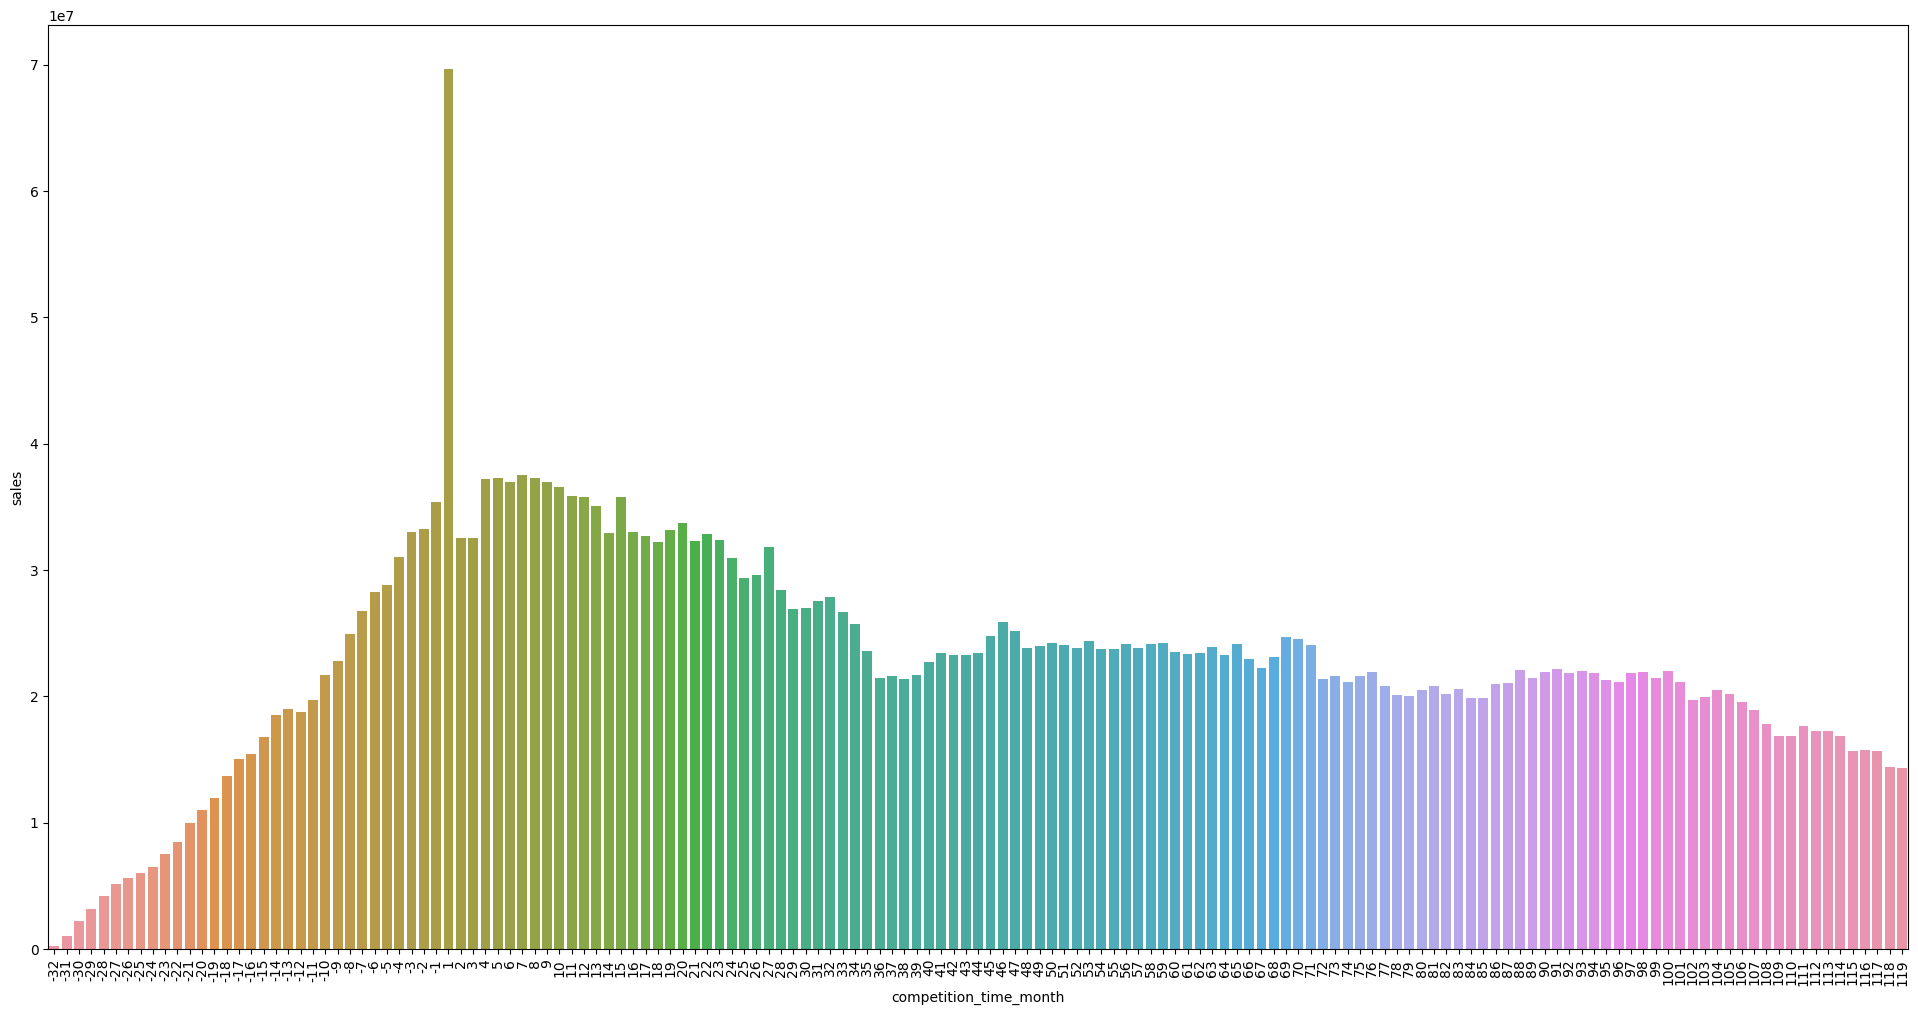

In [212]:
aux_competition_time_month_2 = aux_competition_time_month_1[(aux_competition_time_month_1['competition_time_month'] < 120) & (aux_competition_time_month_1['competition_time_month'] != 0)]

plt.figure(figsize=(24,12))
sns.barplot(data=aux_competition_time_month_2, x='competition_time_month', y='sales');
plt.xticks(rotation=90);

**Quanto mais o valor da competition_time_month vai se aproximando de zero maior é a quantidade de venda, ou seja, quanto mais recente é a loja concorrente maior é a venda. logo a H3 é FALSA.**

Eu acreditava que o efeito era contrário, acreditava que quando abre uma loja concorrente as vendas da loja que tá aberta diminuiria e só com o passar do tempo com os clientes acostumando com a concorrência as vendas aumentariam e o que o gráfico mostra é um efeito contrário no momento que uma loja concorrente abre.

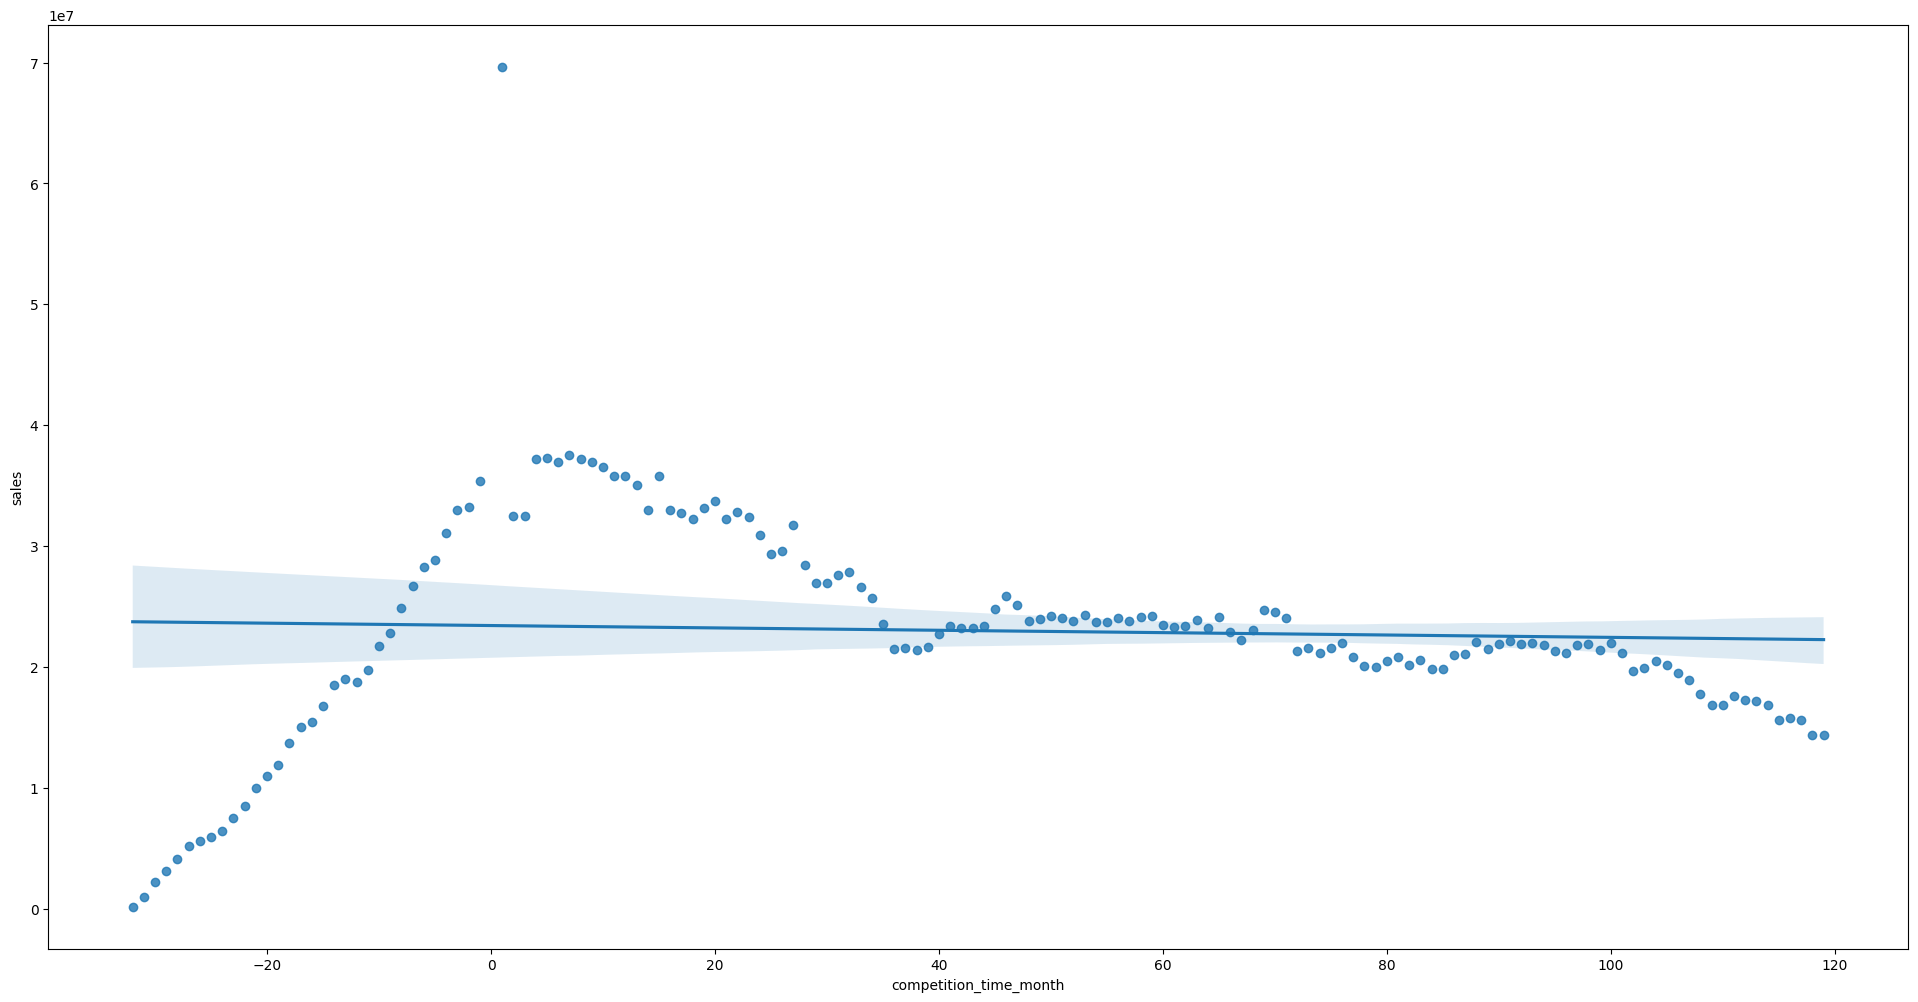

In [213]:
plt.figure(figsize=(24,12))
sns.regplot(data=aux_competition_time_month_2, x='competition_time_month', y='sales');
# Esse gráfico mostra uma linha de tendência levemente inclinada caindo, indicando uma ligeira redução das vendas com o passar do tempo de abertura da loja concorrente
# Só fiz esse gráfico para ter uma outra visuaçização desses dados, como não se trata de dados lineares não posso levar muito a sério a tendência de uma reta linear.

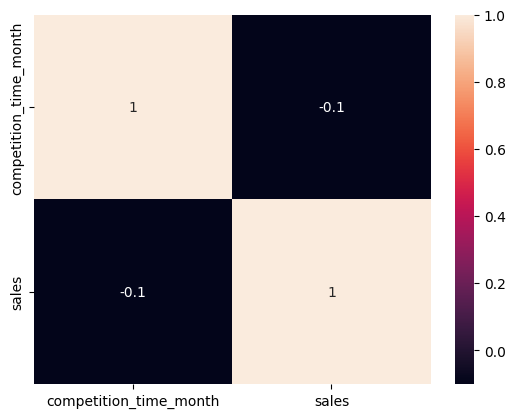

In [214]:
sns.heatmap(aux_competition_time_month_1.corr(method='pearson'), annot=True);

A correlação de Pearson: O tempo que a loja concorrente começou em meses em relação a variável target é -0,1. 

### 4.2.2 - Validando as Hipóteses de Produto

#### H1 - Lojas com preços menores(promoção) nos produtos por mais tempo deveriam vender mais (FALSA)

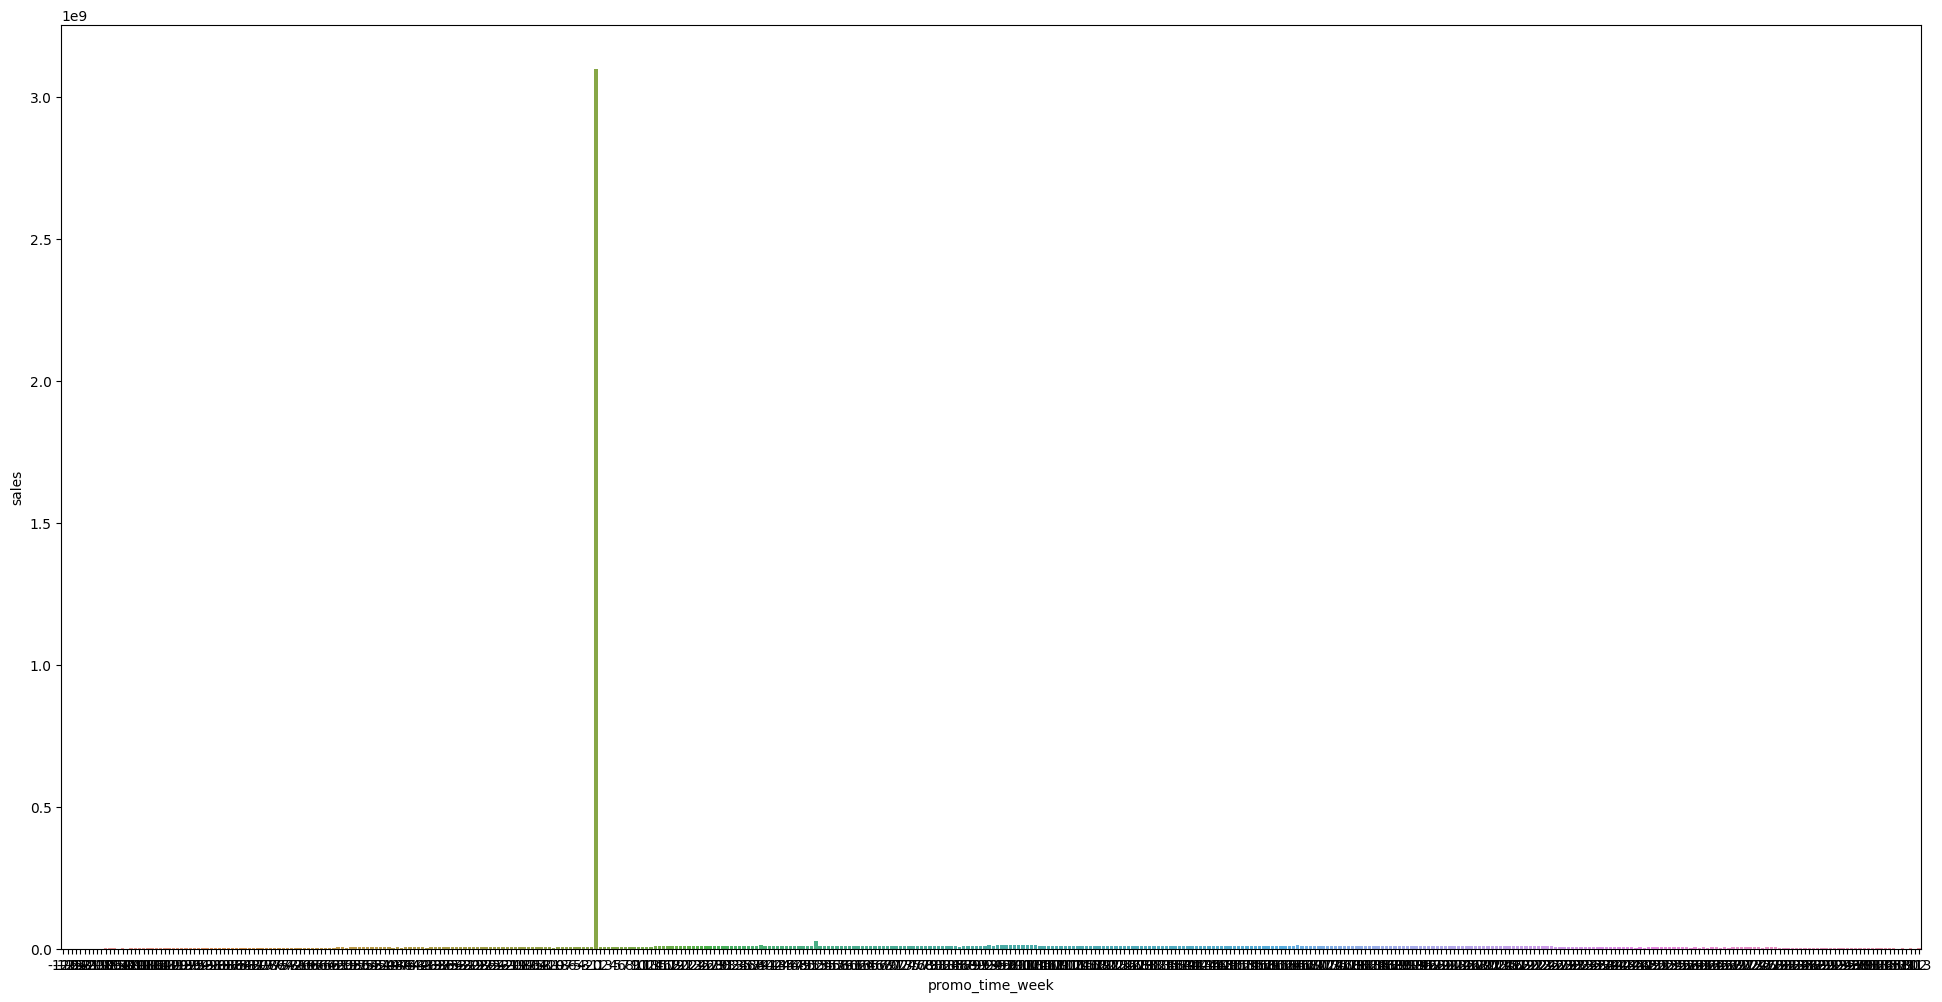

In [215]:
aux_promo_time_week_1 = df_4[['promo_time_week', 'sales']].groupby('promo_time_week').sum().reset_index()

plt.figure(figsize=(24,12))
sns.barplot(data=aux_promo_time_week_1, x='promo_time_week', y='sales');

A visualização do gráfico ficou péssima, vou dividir a visualização dos dados em dois períodos: promoção regular e promoção extendida.


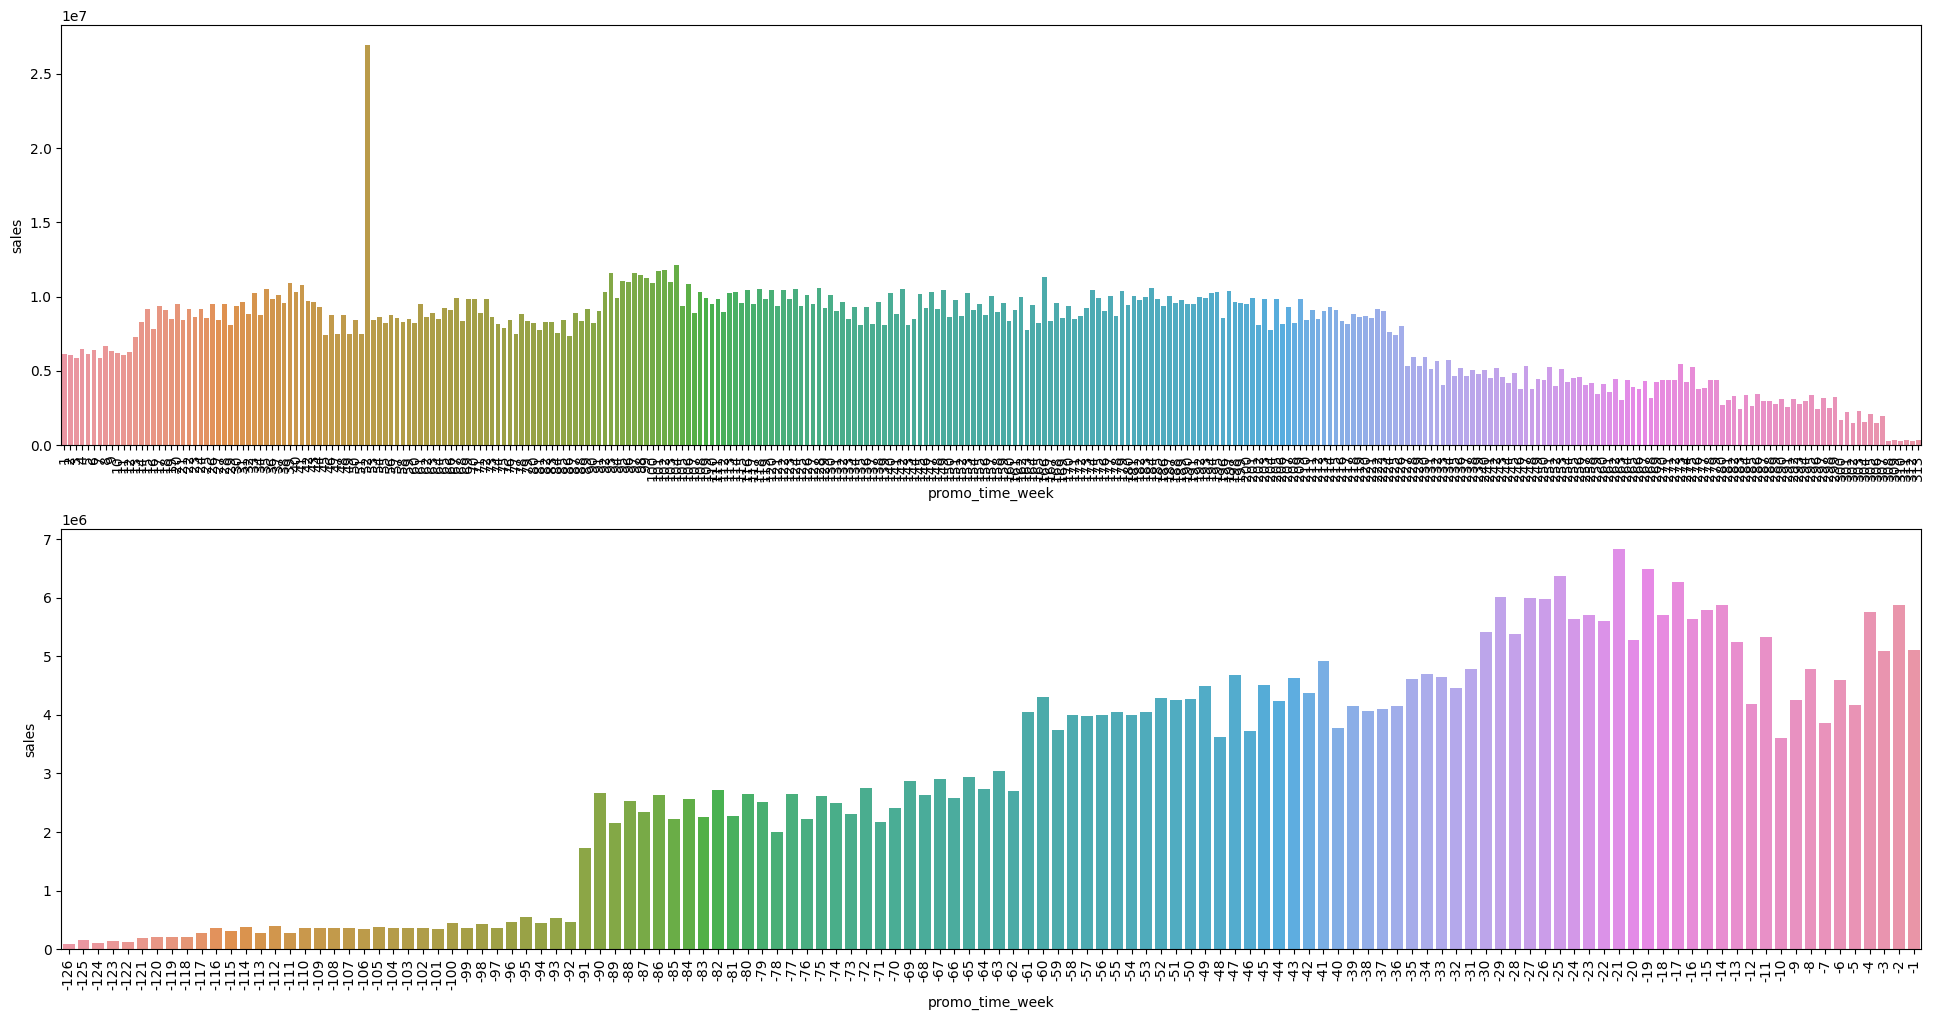

In [216]:
plt.figure(figsize=(24,12))

plt.subplot(2, 1, 1) # promo extendido
aux_promo_time_week_2 = aux_promo_time_week_1[aux_promo_time_week_1['promo_time_week'] > 0]
sns.barplot(data=aux_promo_time_week_2, x='promo_time_week', y='sales');
plt.xticks(rotation=90);

plt.subplot(2, 1, 2) # promo regular
aux_promo_time_week_3 = aux_promo_time_week_1[aux_promo_time_week_1['promo_time_week'] < 0]
sns.barplot(data=aux_promo_time_week_3, x='promo_time_week', y='sales');
plt.xticks(rotation=90);


Analisando o gráfico de cima **(promo extendida)**, podemos ver que tem um período de tempo que esse tipo de promoção funciona, depois de um tempo as vendas começam a cair, ou seja, não adianta fazer promoção por longos períodos.

Analisando o segundo gráfico **(promo regular)**, quando chega próximo ao período das promoções tem bons saltos de vendas (talvez por influência de marketing?) 

Podemos chegar a conclusão que a hipótese H1 é **FALSA**, pois as vendas se mantém regulares durante a promoção e depois de um tempo ela cai, O maior tempo de promoção não garante maior quantidade de vendas.

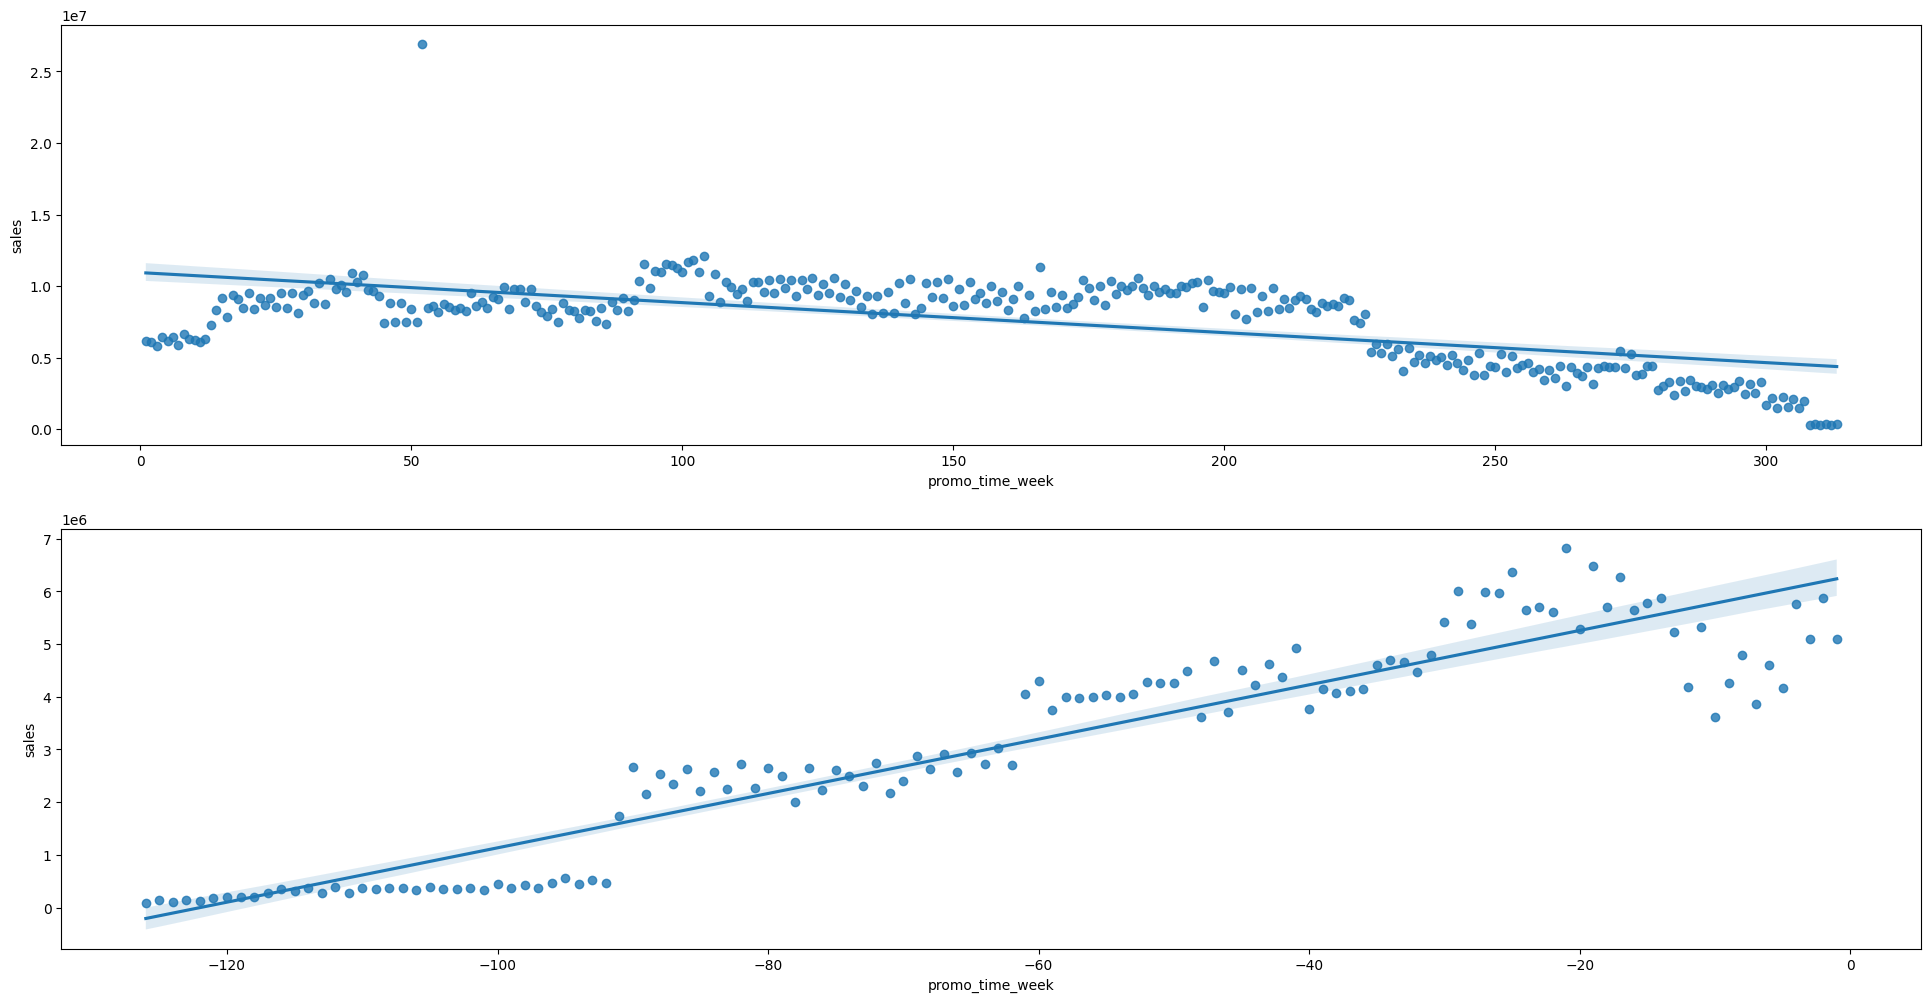

In [217]:
# Para tirar conclusões mais concretar vou plotar mais um gráfico para ver se conseguimos avaliar a tendência das vendas durante o período de promoção
plt.figure(figsize=(24,12))

plt.subplot(2, 1, 1) # promo extendido
sns.regplot(data=aux_promo_time_week_2, x='promo_time_week', y='sales');

plt.subplot(2, 1, 2) # promo regular
sns.regplot(data=aux_promo_time_week_3, x='promo_time_week', y='sales');


Com esses gráficos conseguimos confirmar a tendência de queda nas vendas da **promo extendida** e agora conseguimos ver melhor que a **promo regular** tem uma tendência de crescimento nas vendas.

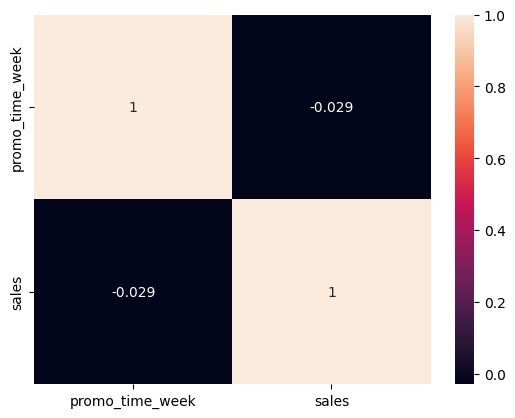

In [218]:
# Vamos tentar avaliar a força da correlação das promoções com as vendas
sns.heatmap(aux_promo_time_week_1.corr(method='pearson'), annot=True);

Como podemos ver, temos uma correlação muito fraca entre essas duas features, aparentemente essa não parece ser uma feature relevante para o modelo.

#### <s> H2 - Lojas com promoções por mais dias consecutivos deveriam vender mais. </s>

Para validar essa hipotese precisamos criar uma nova variável que pega as vendas por dia de promoção de cada loja, como já passamos dessa fase do ciclo, vou dexar para validar essa hipótese no próximo ciclo do CRISP

#### H3 - Lojas com mais promoções consecutivas deveriam vender mais (FALSA)

In [219]:
df_4[['promo', 'promo2', 'sales']].groupby(['promo', 'promo2']).sum().reset_index()

,promo,promo2,sales
0,0,0,1482612096
1,0,1,1289362241
2,1,0,1628930532
3,1,1,1472275754


- Podemos ver que as lojas que participaram só da **promo regular** venderam muito mais que as outras.
- Podemos ver também que as lojas que só participaram da **promo extendida/promo2** venderam menos que todas as lojas.
- As vendas das lojas que não participaram de promoções ficaram no mesmo patamar das lojas que participaram das duas promoções.

<Figure size 2400x1200 with 0 Axes>

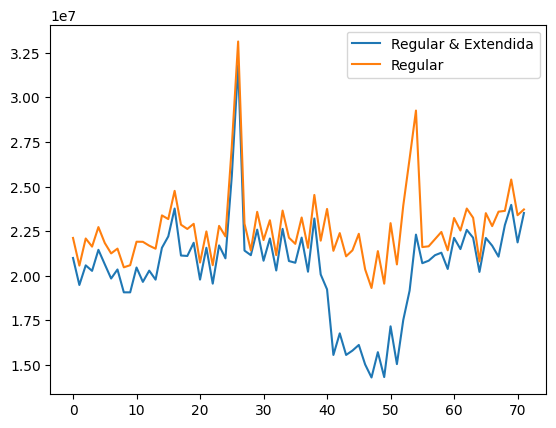

In [220]:
plt.figure(figsize=(24,12))

# Lojas que tiveram os dois períodos de promoção
aux_promos_1 = df_4[(df_4['promo'] == 1) & (df_4['promo2'] == 1)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
ax_promos = aux_promos_1.plot()

# Lojas que tiveram somente o período de pomoção regular (quero avaliar se vale a pena entrar no período da promoção extendida)
aux_promos_2 = df_4[(df_4['promo'] == 1) & (df_4['promo2'] == 0)][['year_week', 'sales']].groupby('year_week').sum().reset_index()
aux_promos_2.plot(ax=ax_promos)

ax_promos.legend(labels=['Regular & Extendida', 'Regular']);

- Podemos ver que as duas linhas acompanham o mesmo comportamento.
- A única diferença é que quando a loja participa das duas promoções em um determinado período as vendas caem muito mais que as lojas que só participaram da promoção regular.

Concluímos que lojas com promoções consecutivas **NÃO VENDEM MAIS**, logo, a H3 é **FALSA**.

Em termos de relevância para o modelo creio que essa variável não é relevante, pois as vendas das lojas para os diferentes tipos de promoção seguem a mesma tendência, quando uma sobe a outra sobe, mesma coisa quando caem as vendas.

### 4.2.3 - Validando as Hipóteses de Tempo (Sazonalidade)

#### H1 - Lojas abertas em feriados de natal deveriam vender mais (FALSA)

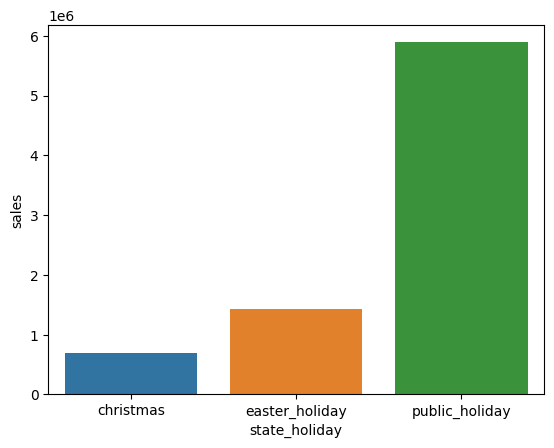

In [221]:
aux_state_holiday = df_4[df_4['state_holiday'] != 'regular_day']

aux_state_holiday_1 = aux_state_holiday[['state_holiday', 'sales']].groupby('state_holiday').sum().reset_index()
sns.barplot(data=aux_state_holiday_1, x='state_holiday', y='sales');

Pelo gráfico de barras fica fácil ver que o Natal não vende mais que os outros feriados.

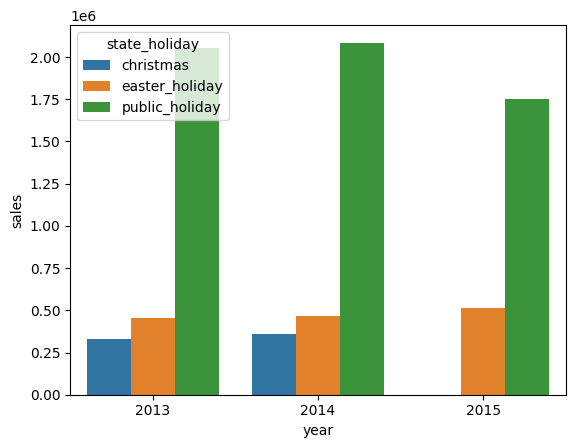

In [222]:
aux_state_holiday_2 = aux_state_holiday[['year', 'state_holiday', 'sales']].groupby(['year', 'state_holiday']).sum().reset_index()
sns.barplot(data=aux_state_holiday_2, x='year', y='sales', hue='state_holiday');

Mesmo analisando ao longo dos anos conseguimos ver que o Natal é o feriado que vende menos sempre.

#### H2 - Lojas deveriam vender mais ao longos dos anos (FALSA)

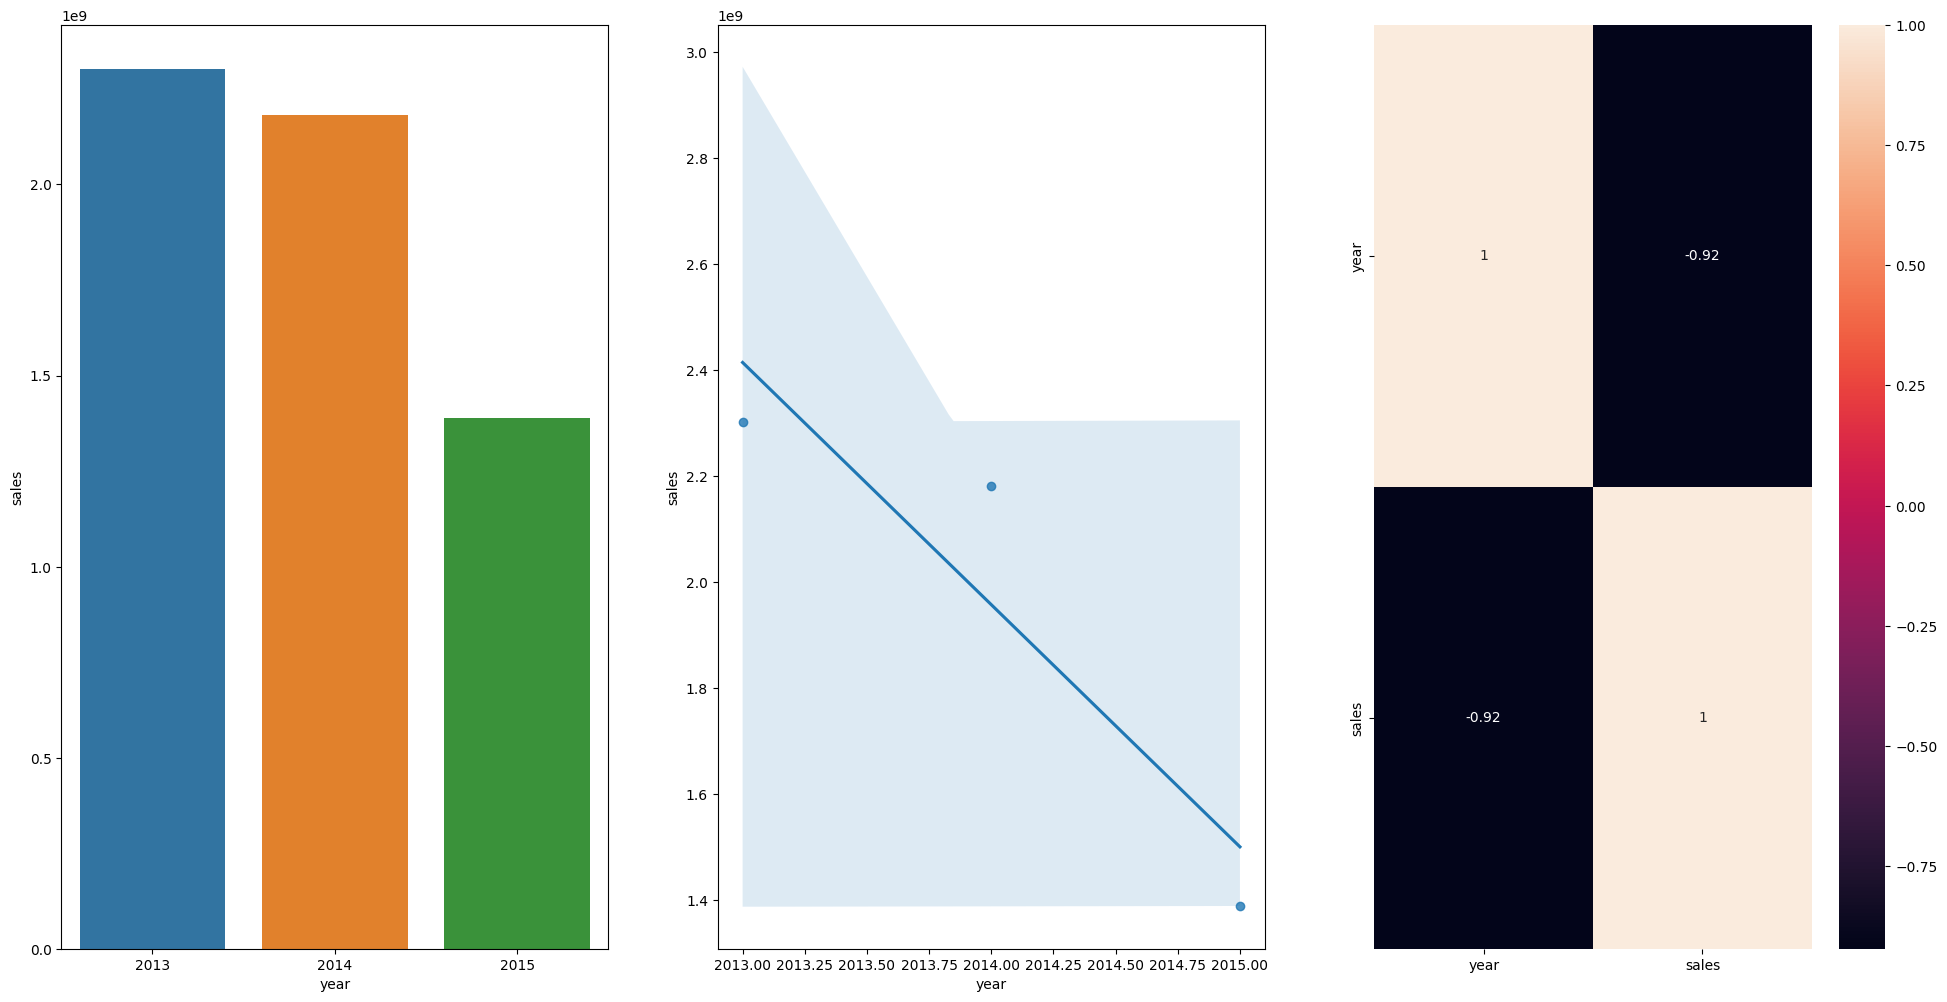

In [223]:
aux_years_sales = df_4[['year', 'sales']].groupby('year').sum().reset_index()

plt.figure(figsize=(24,12))

plt.subplot(1, 3, 1)
sns.barplot(data=aux_years_sales, x='year', y='sales');

plt.subplot(1, 3, 2)
sns.regplot(data=aux_years_sales, x='year', y='sales');

plt.subplot(1, 3, 3)
sns.heatmap(aux_years_sales.corr(method='pearson'), annot=True);

- Podemos ver que as vendas vem caindo ao longos dos anos. Os dados não vão até o final do ano de 2015 por isso podemos ver uma acentuada queda, mas podemos ver que temos uma tendência de queda de forma geral.
- Podemos assumir que o ano é uma feature importante para o modelo.

#### H3 - Lojas deveriam vender mais no segundo semestre do ano (FALSO)

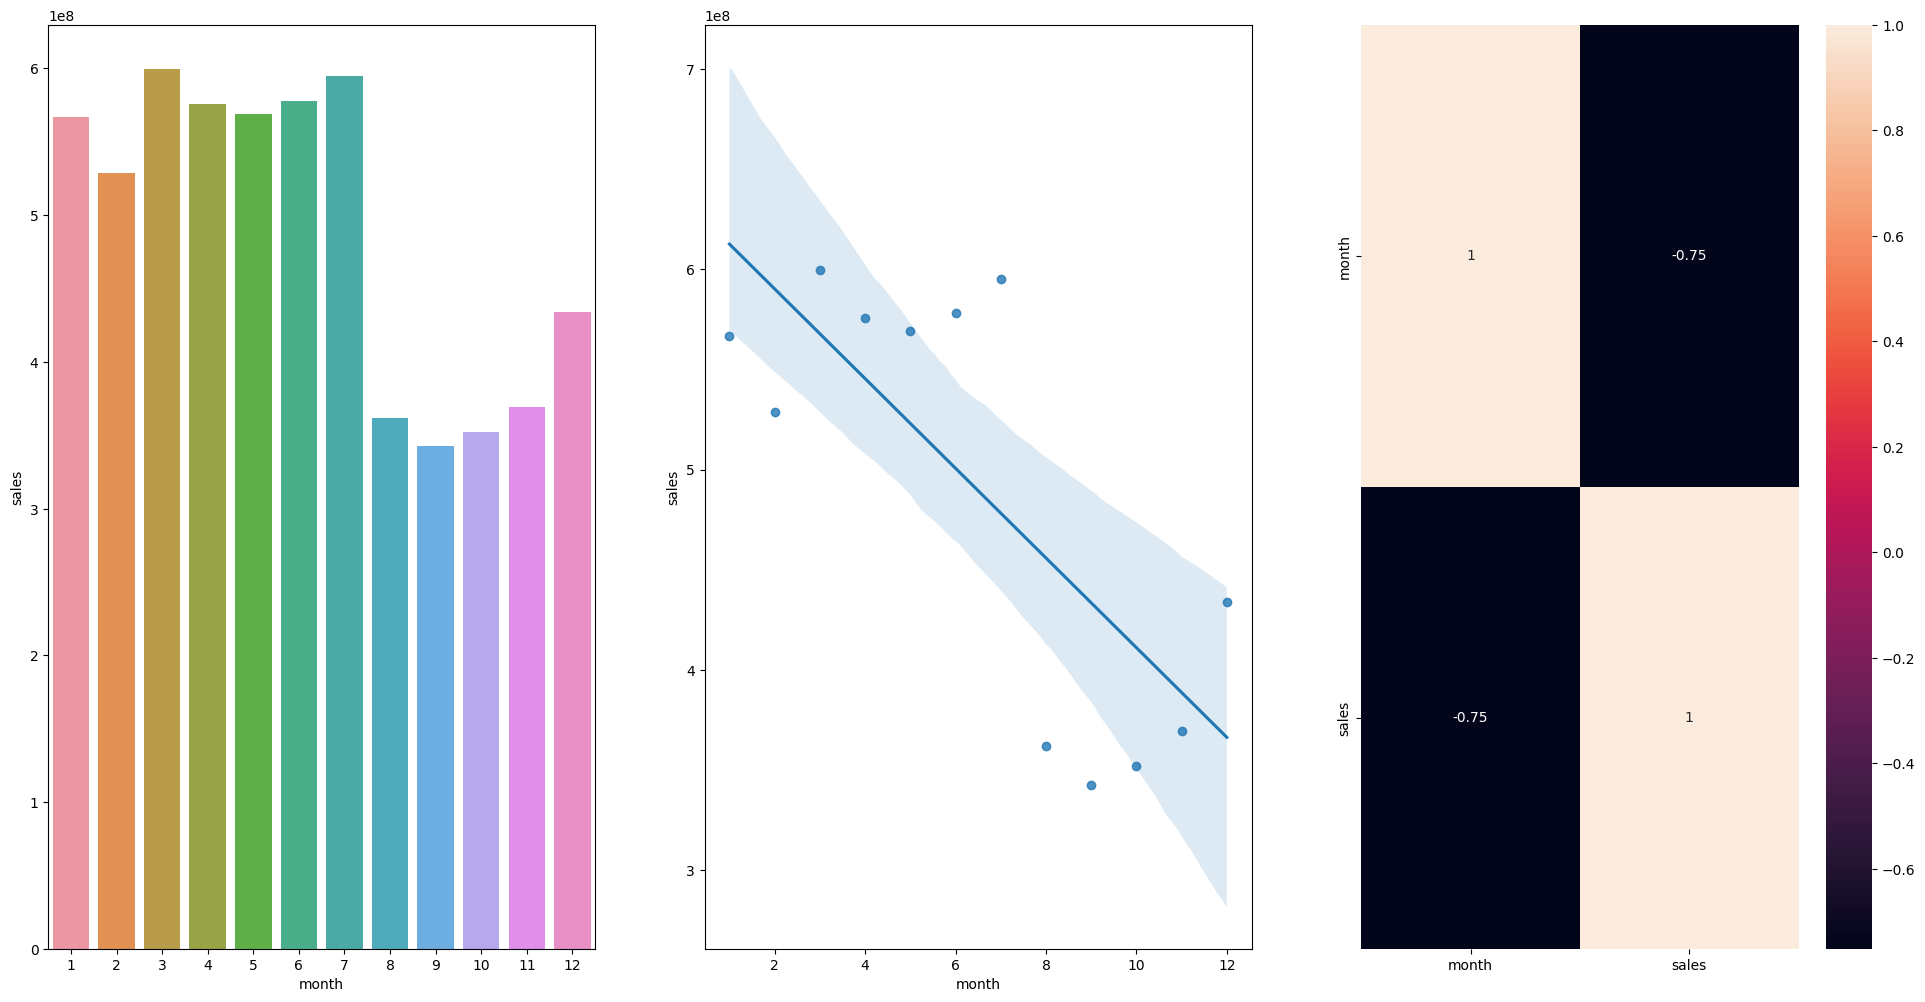

In [224]:
aux_month_sales = df_4[['month', 'sales']].groupby('month').sum().reset_index()

plt.figure(figsize=(24,12))

plt.subplot(1, 3, 1)
sns.barplot(data=aux_month_sales, x='month', y='sales');

plt.subplot(1, 3, 2)
sns.regplot(data=aux_month_sales, x='month', y='sales');

plt.subplot(1, 3, 3)
sns.heatmap(aux_month_sales.corr(method='pearson'), annot=True);

Podemos ver que as lojas tem uma tendência de vender menos no segundo semestre. Pode ser que o ano de 2015 esteja puxando essa feature para baixo, pois não temos todos os dados de venda até o final do ano de 2015 (no dataset as vendas de 2015 estam até o mês 7 somente), mas vou assumir que a tendência é as lojas venderem menos no segundo semestre nesse ciclo.

#### H4 - Lojas deveriam vender mais após o dia 10 de cada mês (VERDADEIRA)

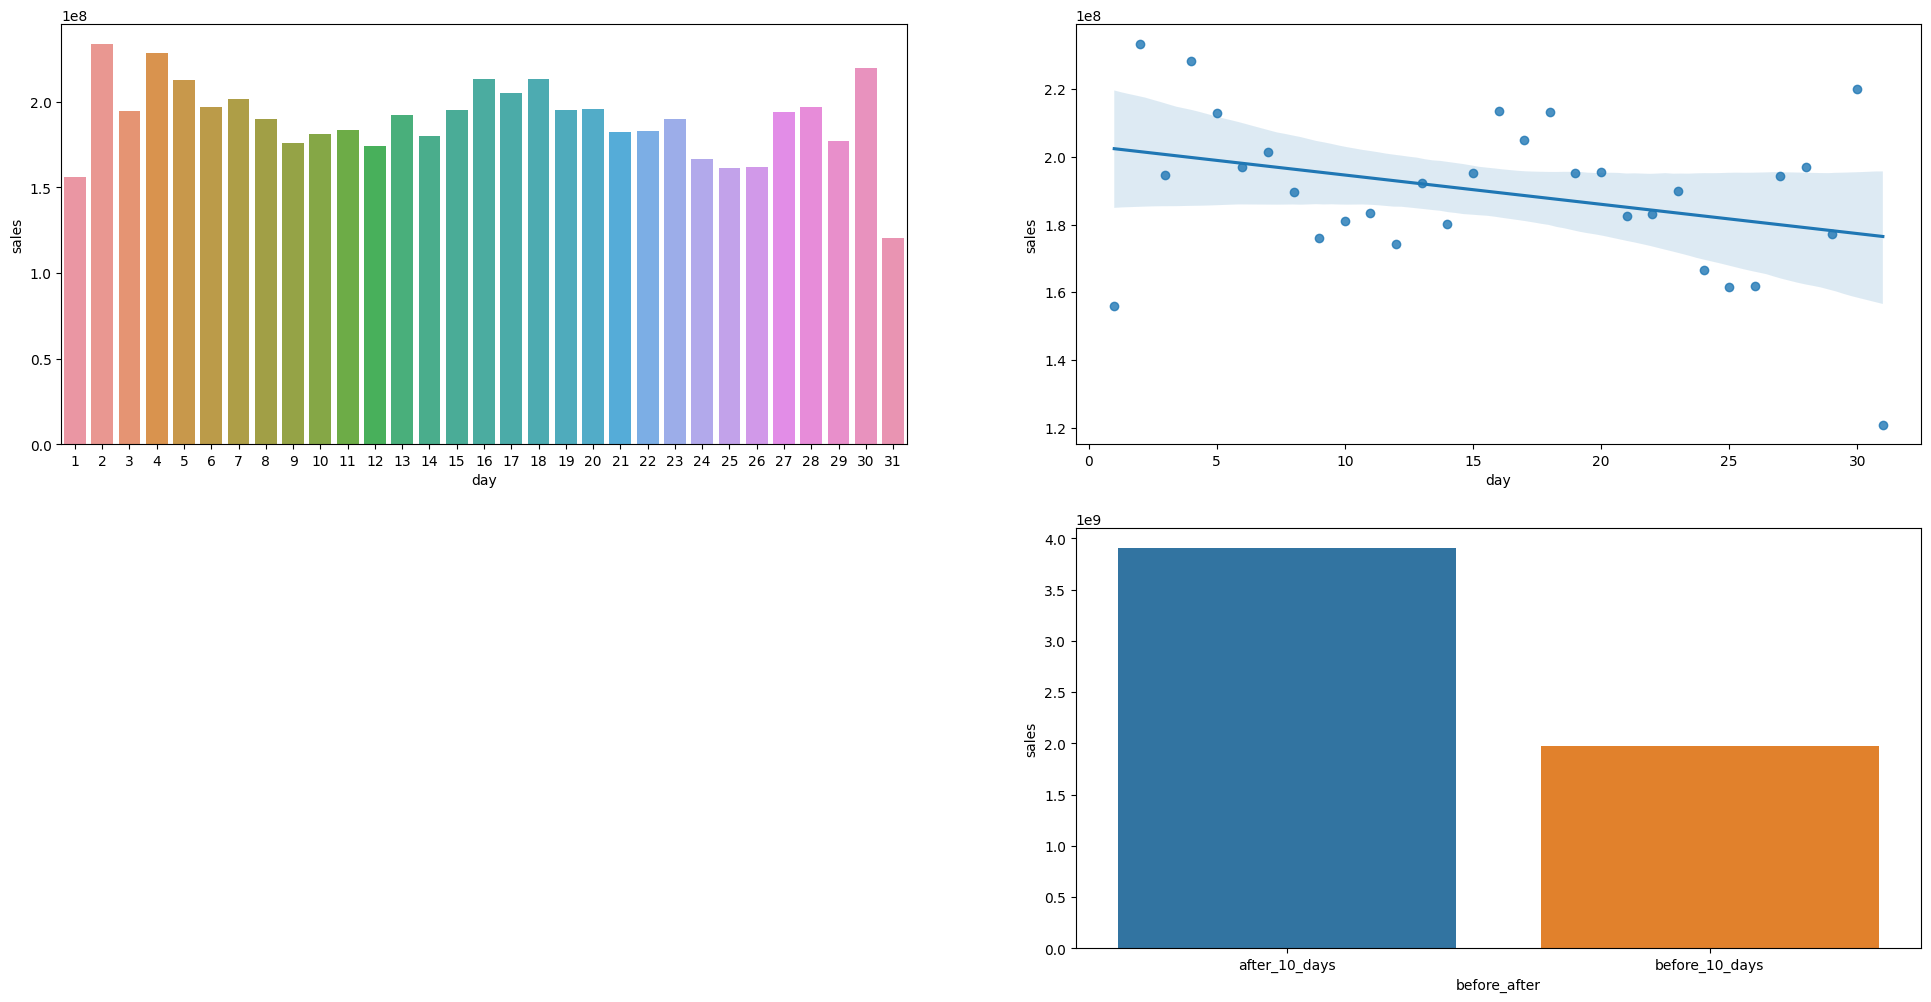

In [225]:
aux_day_sales = df_4[['day', 'sales']].groupby('day').sum().reset_index()

aux_day_sales['before_after'] = aux_day_sales['day'].apply(lambda x: 'before_10_days' if x <= 10 else 'after_10_days')
aux_day_sales_1 = aux_day_sales[['before_after', 'sales']].groupby('before_after').sum().reset_index()

plt.figure(figsize=(24,12))

plt.subplot(2, 2, 1)
sns.barplot(data=aux_day_sales, x='day', y='sales');

plt.subplot(2, 2, 2)
sns.regplot(data=aux_day_sales, x='day', y='sales');

# Esse bloco está dando problema não sei porque, no próximo ciclo tento corrigir.
#plt.subplot(2, 2, 3)
#sns.heatmap(aux_day_sales.corr(method='pearson'), annot=True);

plt.subplot(2, 2, 4)
sns.barplot(data=aux_day_sales_1, x='before_after', y='sales');


Podemos ver que as lojas vende mais depois do dia 10 de cada mês.

Não é uma comparação "justa" pois o mês tem mais que 10 dias então faz sentido que o restante do mês venda mais que os 10 primeiros.

#### H5 - Lojas deveriam vender menos aos finais de semana (VERDADEIRO)

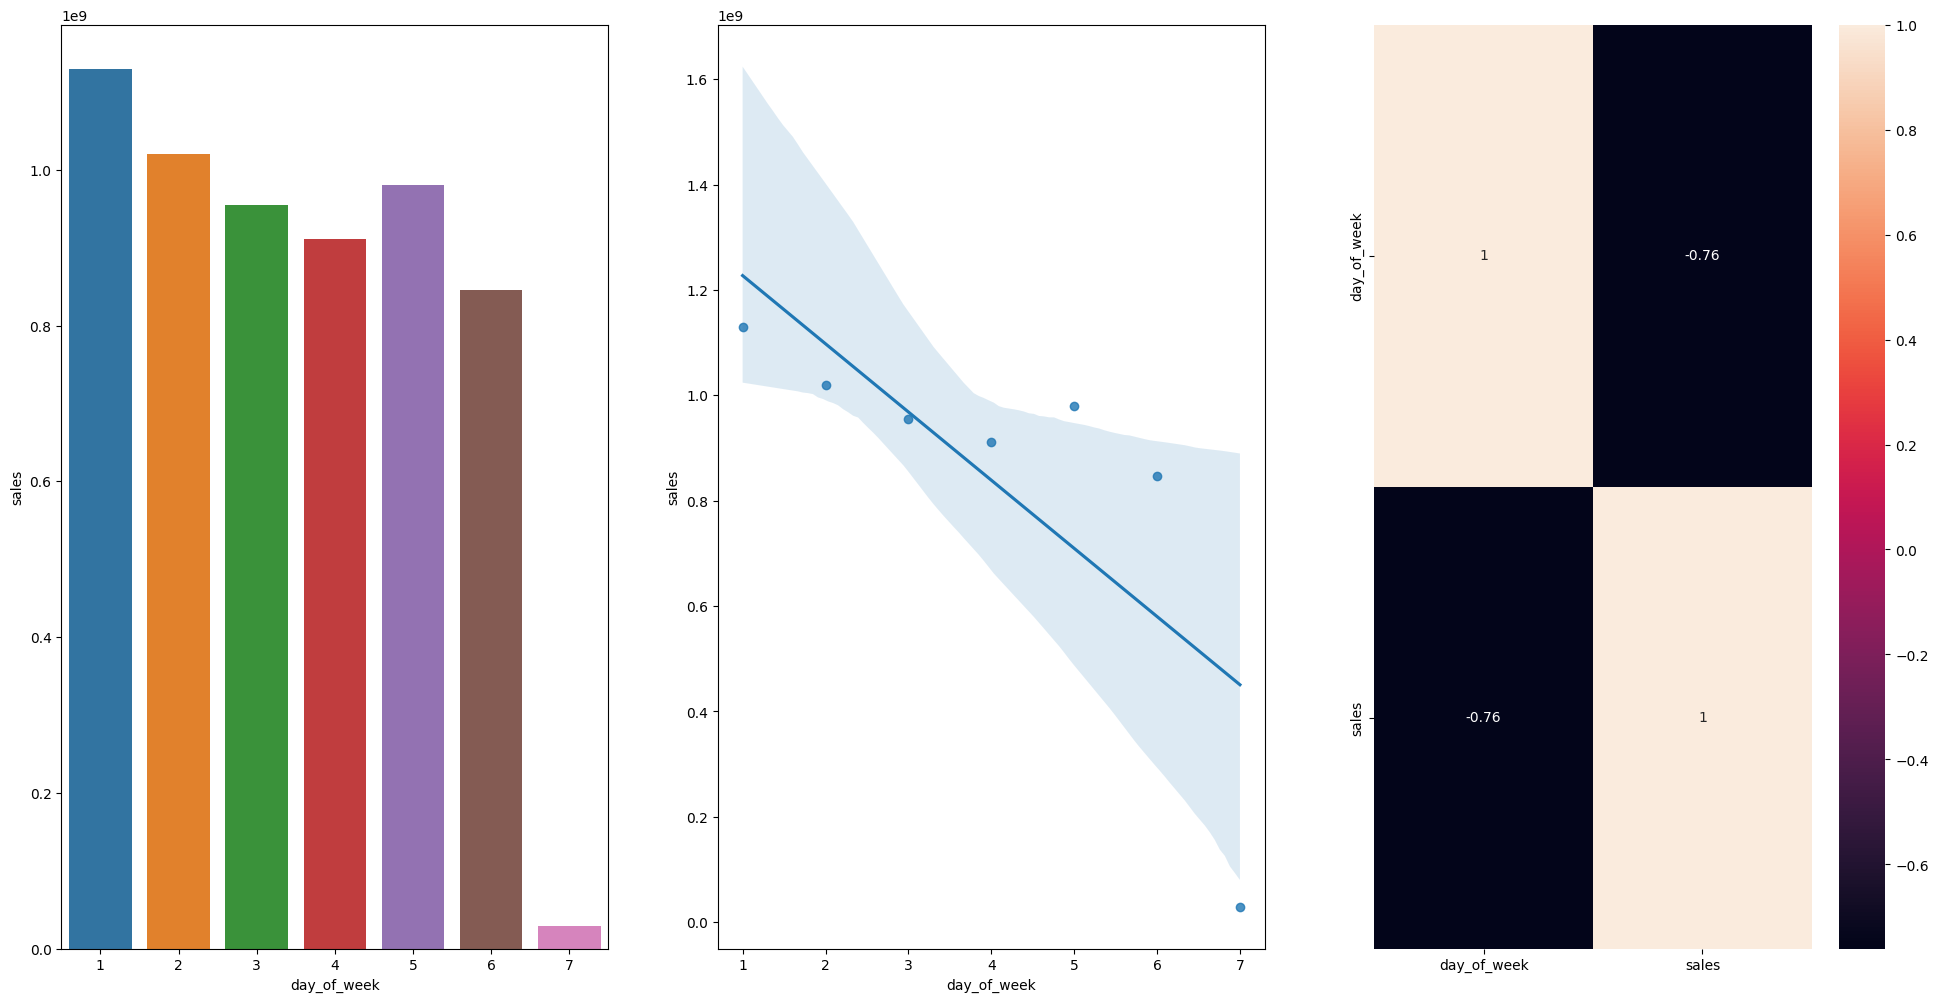

In [226]:
aux_day_of_week = df_4[['day_of_week', 'sales']].groupby('day_of_week').sum().reset_index()

plt.figure(figsize=(24,12))

plt.subplot(1, 3, 1)
sns.barplot(data=aux_day_of_week, x='day_of_week', y='sales');

plt.subplot(1, 3, 2)
sns.regplot(data=aux_day_of_week, x='day_of_week', y='sales');

plt.subplot(1, 3, 3)
sns.heatmap(aux_day_of_week.corr(method='pearson'), annot=True);

Proporcionalmente as lojas vendem menos aos finais de semana. Tem uma tendência de quedas nas vendas aos finais de semana, correlação de Pearson bem negativa.

#### H6 - Lojas deveriam vender menos durante os feriados escolares (VERDADEIRO) - exceto mês 7 e 8

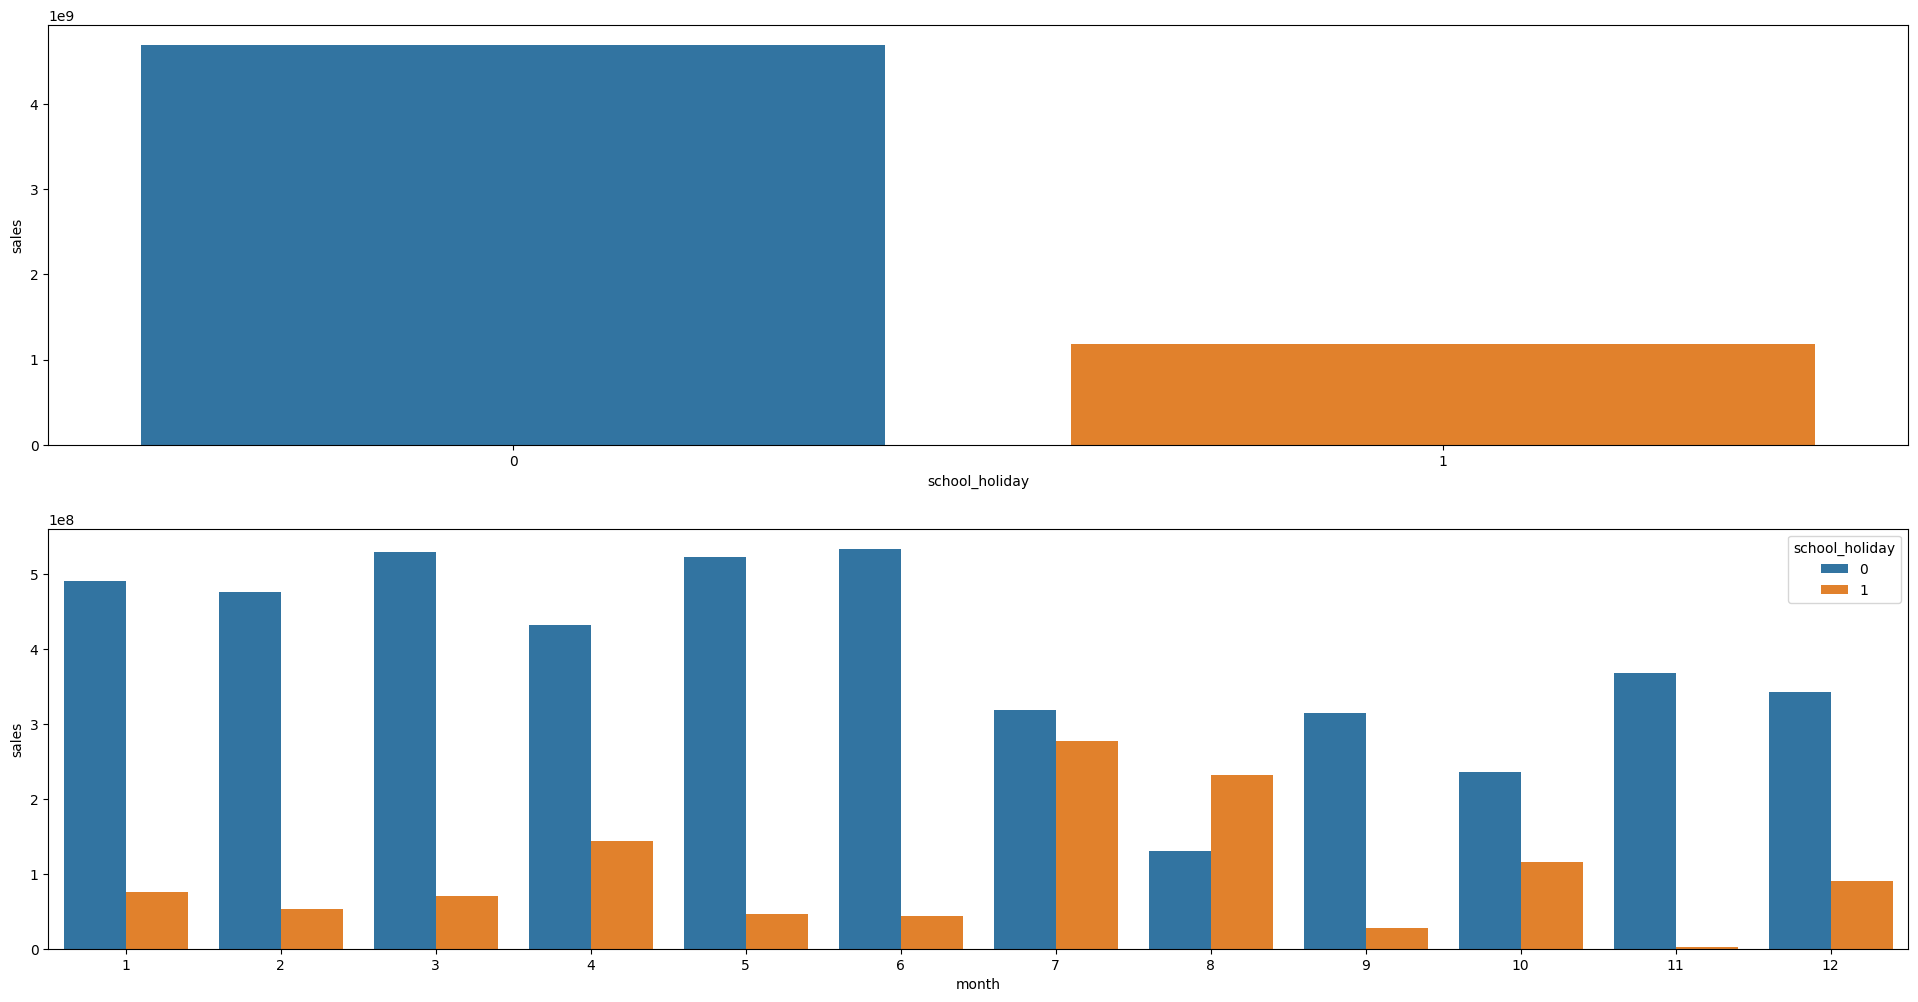

In [227]:
aux_school_holiday = df_4[['school_holiday', 'sales']].groupby('school_holiday').sum().reset_index()
aux_school_holiday_1 = df_4[['month','school_holiday', 'sales']].groupby(['month', 'school_holiday']).sum().reset_index()


plt.figure(figsize=(24,12))

plt.subplot(2, 1, 1)
sns.barplot(data=aux_school_holiday, x='school_holiday', y='sales');

plt.subplot(2, 1, 2)
sns.barplot(data=aux_school_holiday_1, x='month', y='sales', hue='school_holiday');

- Como podemos ver as vendas em feriado escolar no mês 7 quase se equiparam as vendas em regulares, esse comportamento deve ser devido a período de férias.
- Agora no mês 8 temos um comportamento interessante, as vendas em feriado escolar superam as vendas em dias regulares, esse comportamento pode ser um insight bacana.

### 4.2.4 - Resumo das Hipóteses

In [228]:
from tabulate import tabulate

tab =[['Hipoteses', 'Conclusao', 'Relevancia'],
['H1', 'Falsa', 'Baixa'],
['H2', 'Falsa', 'Media'],
['H3', 'Falsa', 'Media'],
['H1', 'Falsa', 'Baixa'],
['H2', '-', '-'],
['H3', 'Falsa', 'Baixa'],
['H1', 'Falsa', 'Media'],
['H2', 'Falsa', 'Alta'],
['H3', 'Falsa', 'Alta'],
['H4', 'Verdadeira', 'Alta'],
['H5', 'Verdadeira', 'Alta'],
['H6', 'Verdadeira', 'Baixa'],
]
print(tabulate( tab, headers='firstrow' ))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H1           Falsa        Baixa
H2           -            -
H3           Falsa        Baixa
H1           Falsa        Media
H2           Falsa        Alta
H3           Falsa        Alta
H4           Verdadeira   Alta
H5           Verdadeira   Alta
H6           Verdadeira   Baixa


## 4.3 - Análise Multivariada

A Análise Multivariada nos ajuda a ver quais variáveis tem correlação forte uma com a outra, para assim podermos diminuir a dimensionalidade do dataset e assim diminuir a complexidade do modelo, removendo uma delas. Foco em encontrar correlações entre as features.

### 4.3.1 - Atributos Numéricos

In [229]:
atributos_numericos.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,is_promo
0,1,5,5263,555,1,1,1,1270.0,9,2008,0,31,2015,0
1,2,5,6064,625,1,1,1,570.0,11,2007,1,13,2010,1
2,3,5,8314,821,1,1,1,14130.0,12,2006,1,14,2011,1
3,4,5,13995,1498,1,1,1,620.0,9,2009,0,31,2015,0
4,5,5,4822,559,1,1,1,29910.0,4,2015,0,31,2015,0


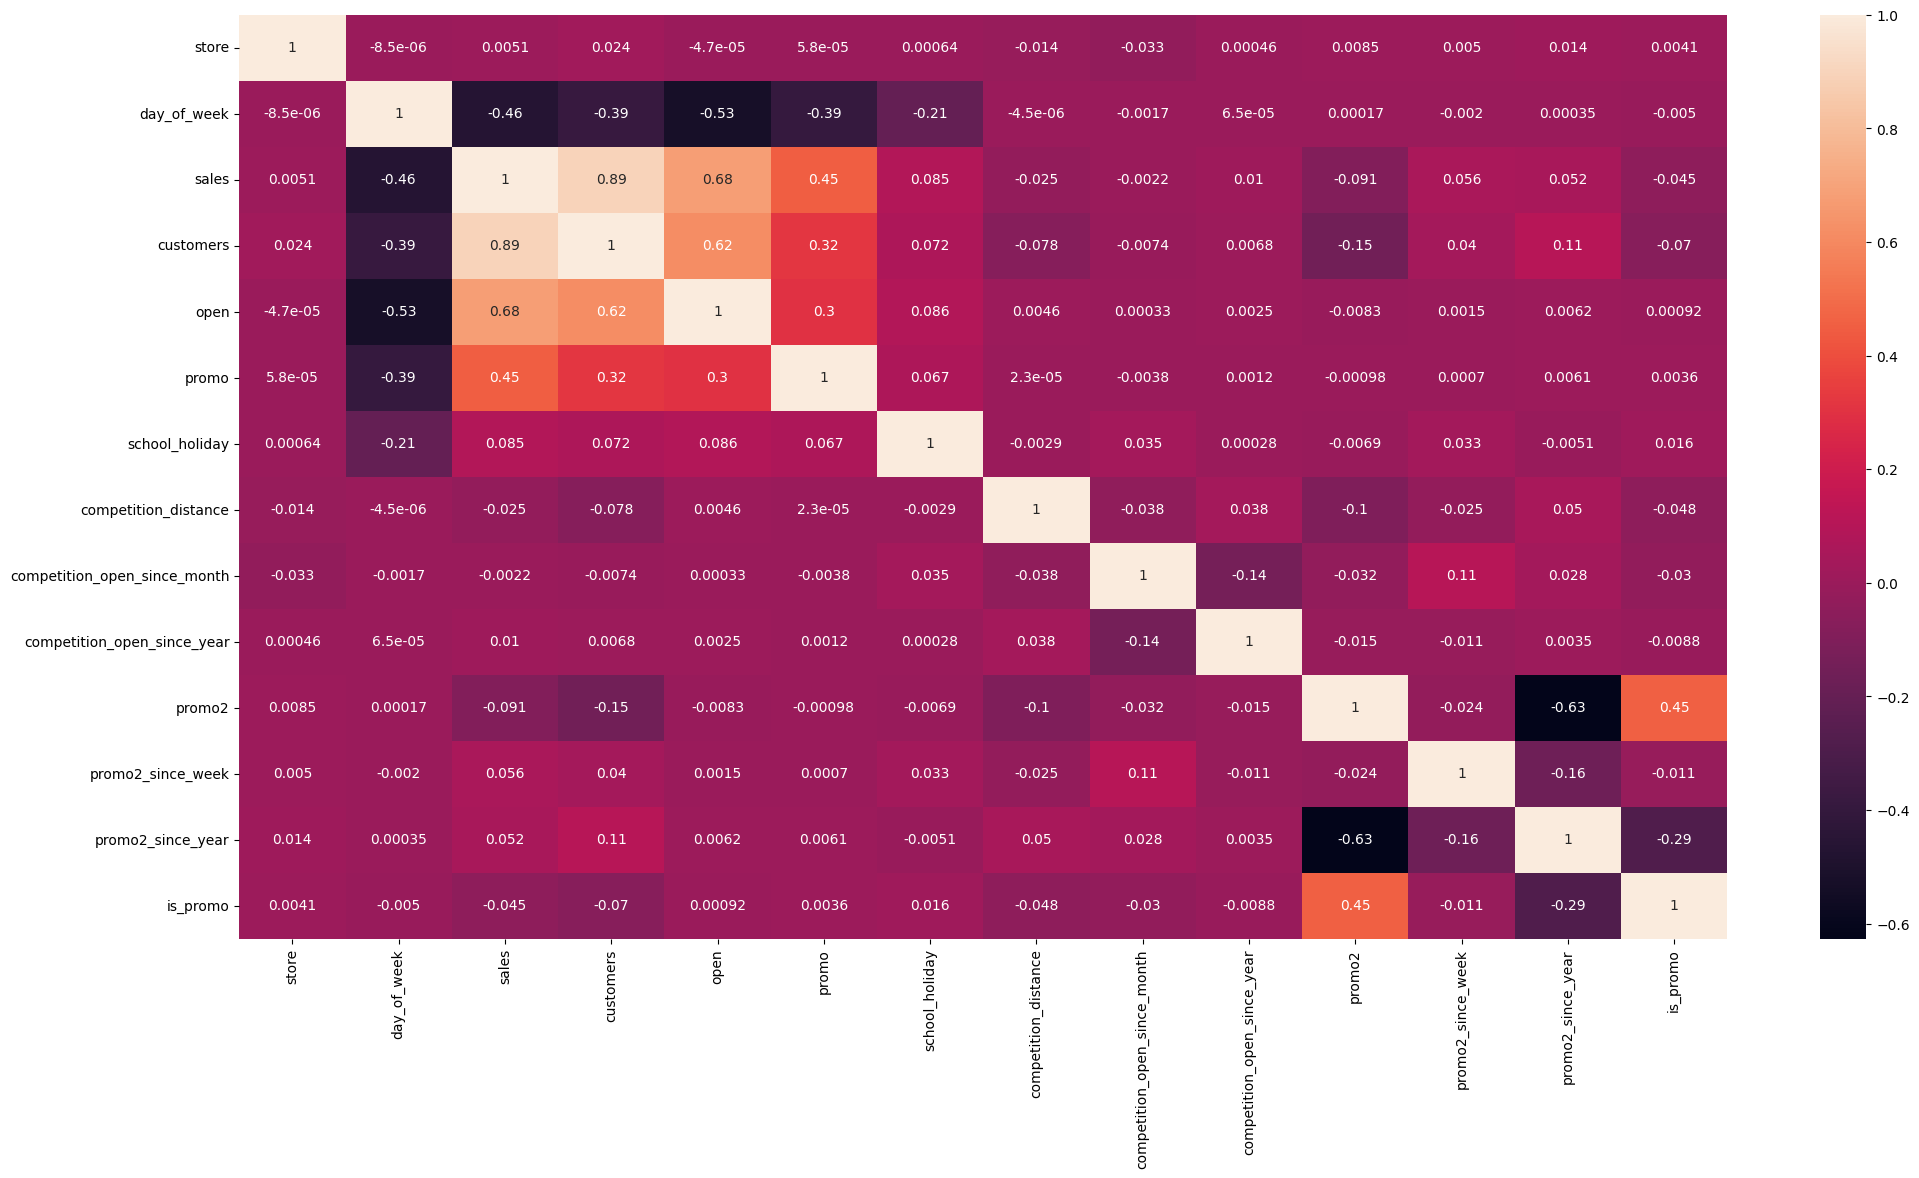

In [230]:
correlacao_numerica = atributos_numericos.corr(method='pearson')

plt.figure(figsize=(24, 12))
sns.heatmap(correlacao_numerica, annot=True);
# Quanto mais próximo da cor clara maior a correlação positiva, quanto mais próximo da cor escura maior a correlação negativa.

### 4.3.2 - Atributos Categóricos

In [231]:
atributos_categoricos_2 = df_4.select_dtypes(include='object')
atributos_categoricos_2 = atributos_categoricos_2.drop(columns=['promo_interval', 'month_map'])
atributos_categoricos_2.head()

,state_holiday,store_type,assortment,year_week
0,regular_day,c,basic,2015-30
1,regular_day,a,basic,2015-30
2,regular_day,a,basic,2015-30
3,regular_day,c,extended,2015-30
4,regular_day,a,basic,2015-30


Vamos usar a fórmula do método Cramer V para fazer a correlação das variáveis categóricas, Criei a função mas estou fazendo por etapas aqui para ficar mais fácil de entender. Na próxima etapa do clico faço o cálculo na função direto.


cramer_v = np.sqrt((chi2/n) / (min(k-1, r-1)))


In [232]:
# Fazendo a matriz de confusão para acharmos o valor de qui-quadrado
confusion_matrix = pd.crosstab(atributos_categoricos_2['state_holiday'], atributos_categoricos_2['store_type'])
confusion_matrix

store_type,a,b,c,d
state_holiday,,,,
christmas,4,66,0,1
easter_holiday,36,100,0,9
public_holiday,236,285,65,108
regular_day,456766,15109,112903,258650


In [233]:
# Transformação necessária para conseguir usar na fórmula de cramer v
confusion_matrix_array = confusion_matrix.to_numpy()
confusion_matrix_array

array([[     4,     66,      0,      1],
       [    36,    100,      0,      9],
       [   236,    285,     65,    108],
       [456766,  15109, 112903, 258650]], dtype=int64)

In [234]:
# Calculando o valor de qui-quadrado
chi2 = stats.chi2_contingency(confusion_matrix_array)
chi2
# fazendo chi2[0] temos apenas o valor do teste qui-quadrado que vamos precisar na fórmula de cramer v

Chi2ContingencyResult(statistic=12792.159524019908, pvalue=0.0, dof=9, expected_freq=array([[3.84324548e+01, 1.30843335e+00, 9.49942795e+00, 2.17596839e+01],
       [7.84888161e+01, 2.67215262e+00, 1.94002402e+01, 4.44387911e+01],
       [3.75663713e+02, 1.27894753e+01, 9.28535634e+01, 2.12693248e+02],
       [4.56549415e+05, 1.55432299e+04, 1.12846247e+05, 2.58489108e+05]]))

- statistic=12792.159524019908 -> É o valor do teste qui-quadrado
- pvalue=0.0 -> É o p-valor mesmo
- dof=9 -> Número de graus de liberdade
- expected_freq=array -> É a tabela de frequência

In [235]:
# o ``n`` é a soma de todos os valores
n = confusion_matrix_array.sum()
n

844338

In [236]:
# Calculando o número de linhas (r) e colunas (k)
r, k = confusion_matrix_array.shape
print(r)
print(k)

4
4


In [237]:
# Aplicando a fórmula de cramer v
cramer_v = np.sqrt((chi2[0]/n) / (min(k-1, r-1)))
cramer_v

# Resultado: 0.07106457093267678

0.07106457093267678

Diferente da correlação de pearson o cramer v vai de 0 a 1 somente. Logo, não temos correlação negativa entre variáveis categóricas, tem correlação ou não tem.

In [238]:
def cramer_v(x, y):
    confusion_matrix = pd.crosstab(x, y).to_numpy()
    n = confusion_matrix.sum()
    r, k = confusion_matrix.shape

    chi2 = stats.chi2_contingency(confusion_matrix)[0]
    chi2_corr = max(0, chi2 - (k-1)*(r-1)/(n-1))

    k_corr = k - (k-1)**2/(n-1)
    r_corr = r - (r-1)**2/(n-1)

    return np.sqrt((chi2_corr/n) / (min(k_corr-1, r_corr-1)))


v1 = cramer_v(atributos_categoricos_2['state_holiday'], atributos_categoricos_2['state_holiday'])
v2 = cramer_v(atributos_categoricos_2['state_holiday'], atributos_categoricos_2['store_type'])
v3 = cramer_v(atributos_categoricos_2['state_holiday'], atributos_categoricos_2['assortment'])

v4 = cramer_v(atributos_categoricos_2['store_type'], atributos_categoricos_2['state_holiday'])
v5 = cramer_v(atributos_categoricos_2['store_type'], atributos_categoricos_2['store_type'])
v6 = cramer_v(atributos_categoricos_2['store_type'], atributos_categoricos_2['assortment'])

v7 = cramer_v(atributos_categoricos_2['assortment'], atributos_categoricos_2['state_holiday'])
v8 = cramer_v(atributos_categoricos_2['assortment'], atributos_categoricos_2['store_type'])
v9 = cramer_v(atributos_categoricos_2['assortment'], atributos_categoricos_2['assortment'])

cramer_v_tab = pd.DataFrame({
    'state_holiday': [v1, v2, v3],
    'store_type': [v4, v5, v6],
    'assortment': [v7, v8, v9]
})

cramer_v_tab = cramer_v_tab.set_index(cramer_v_tab.columns)
cramer_v_tab

,state_holiday,store_type,assortment
state_holiday,1.000002,0.071065,0.067546
store_type,0.071065,1.000002,0.538457
assortment,0.067546,0.538457,1.000001


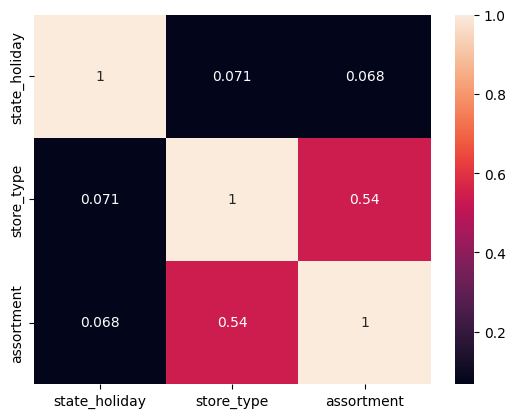

In [239]:
sns.heatmap(cramer_v_tab, annot=True);

Podemos ver que store_type tem uma boa correlação com assortment. Quanto maior o tipo da loja mais variedades de produtos eu posso ter. 

# PASSO 05 - PREPARAÇÃO DOS DADOS

In [240]:
df_5 = df_4.copy()

## 5.1 - Normalização

Nesse dataset não temos features com distribuição normal, logo, não vamos forçar uma normalização.

## 5.2 - Rescaling

In [241]:
df_5.dtypes

store                                    int64
day_of_week                              int64
date                            datetime64[ns]
sales                                    int64
customers                                int64
open                                     int64
promo                                    int64
state_holiday                           object
school_holiday                           int64
store_type                              object
assortment                              object
competition_distance                   float64
competition_open_since_month             int32
competition_open_since_year              int32
promo2                                   int64
promo2_since_week                        int64
promo2_since_year                        int64
promo_interval                          object
month_map                               object
is_promo                                 int64
year                                     int32
month        

In [242]:
df_5['competition_time_month'] = df_5['competition_time_month'].astype('int64')
df_5['promo_time_week'] = df_5['promo_time_week'].astype('int64')
df_5['week_of_year'] = df_5['week_of_year'].astype('int64')
df_5['year'] = df_5['year'].astype('int64')
df_5['month'] = df_5['month'].astype('int64')
df_5['day'] = df_5['day'].astype('int64')

rescaling = df_5.select_dtypes(include=['int64', 'float64'])
rescaling.head()

,store,day_of_week,sales,customers,open,promo,school_holiday,competition_distance,promo2,promo2_since_week,promo2_since_year,is_promo,year,month,day,week_of_year,competition_time_month,promo_time_week
0,1,5,5263,555,1,1,1,1270.0,0,31,2015,0,2015,7,31,31,84,0
1,2,5,6064,625,1,1,1,570.0,1,13,2010,1,2015,7,31,31,94,279
2,3,5,8314,821,1,1,1,14130.0,1,14,2011,1,2015,7,31,31,105,226
3,4,5,13995,1498,1,1,1,620.0,0,31,2015,0,2015,7,31,31,71,0
4,5,5,4822,559,1,1,1,29910.0,0,31,2015,0,2015,7,31,31,4,0


Vamos aplicar o Rescaling nas seguintes variáveis:
- competition_distance (Robust Scaler)
- competition_time_month (Robust Scaler)
- promo_time_week (Min-Max Scaler)
- year (Min-Max Scaler)

As features que tiverem outliers muito relevantes vou aplicar o Robust Scaler as que não tiverem faço Min-Max Scaler

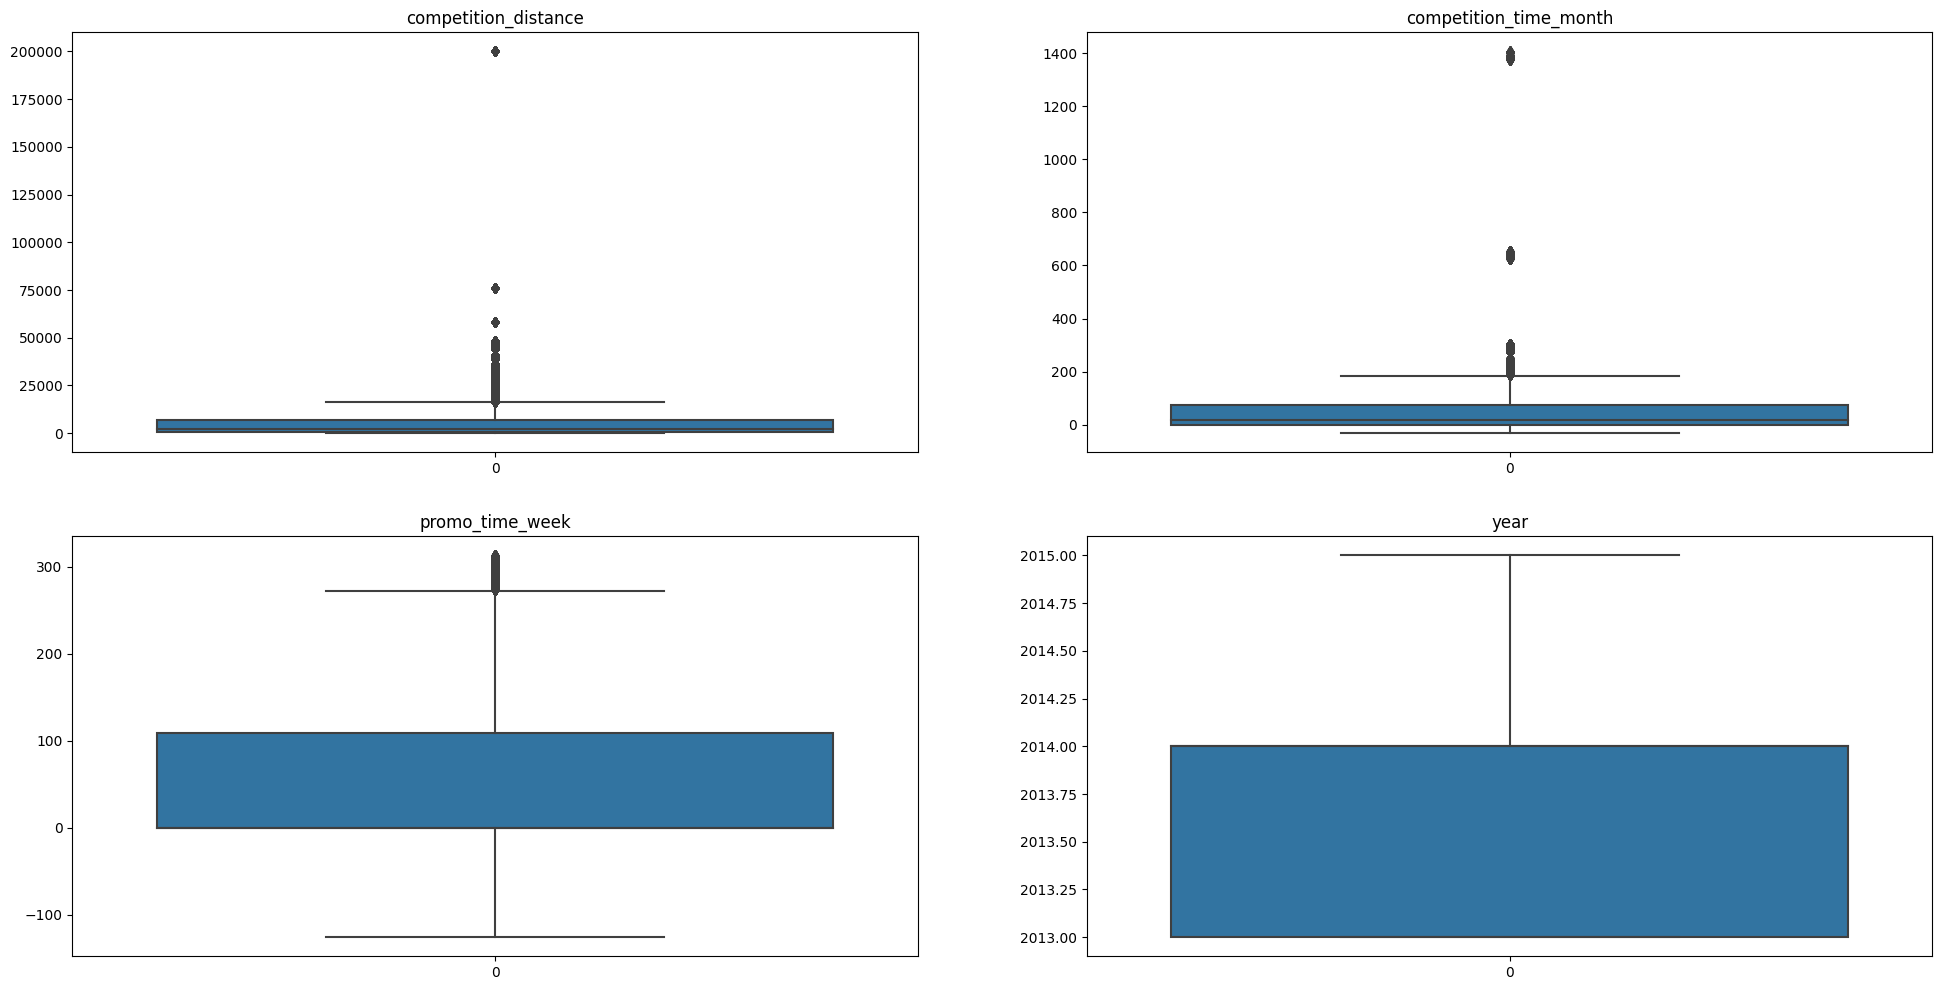

In [243]:
plt.figure(figsize=(24,12))

plt.subplot(2, 2, 1)
sns.boxplot(df_5['competition_distance'], );
plt.title('competition_distance');

plt.subplot(2, 2, 2)
sns.boxplot(df_5['competition_time_month']);
plt.title('competition_time_month');

plt.subplot(2, 2, 3)
sns.boxplot(df_5['promo_time_week']);
plt.title('promo_time_week');

plt.subplot(2, 2, 4)
sns.boxplot(df_5['year']);
plt.title('year');


### 5.2.1 - Min-Max Scaler

Infelizmente o Min-Max Scaler é muito sensível a outliers devido a sua fórmula. Logo, vamos aplicar o Min-Max Scale somente em features que não possuem outliers muito "fortes".


In [244]:
mms = MinMaxScaler()

# promo_time_week
df_5['promo_time_week'] = mms.fit_transform(df_5[['promo_time_week']].values)
# joblib.dump(mms, 'C:\\Users\\rapha\\venvs\\rossmann_store_sales\\parameter\\promo_time_week_scaler.joblib')

# year
df_5['year'] = mms.fit_transform(df_5[['year']].values)
# joblib.dump(mms, 'C:\\Users\\rapha\\venvs\\rossmann_store_sales\\parameter\\year_scaler.joblib')

### 5.2.2 - Robust Scaler

Usa o intervalo interquartil em vez de subtrair o valor Máximo e Mínimo da feature.


In [245]:
rs = RobustScaler()

# competition_distance
df_5['competition_distance'] = rs.fit_transform(df_5[['competition_distance']].values)
# joblib.dump(rs, 'C:\\Users\\rapha\\venvs\\rossmann_store_sales\\parameter\\competition_distance_scaler.joblib')

# competition_time_month
df_5['competition_time_month'] = rs.fit_transform(df_5[['competition_time_month']].values)
# joblib.dump(rs, 'C:\\Users\\rapha\\venvs\\rossmann_store_sales\\parameter\\competition_time_month_scaler.joblib')



### 5.2.3 - Features depois do Rescaling

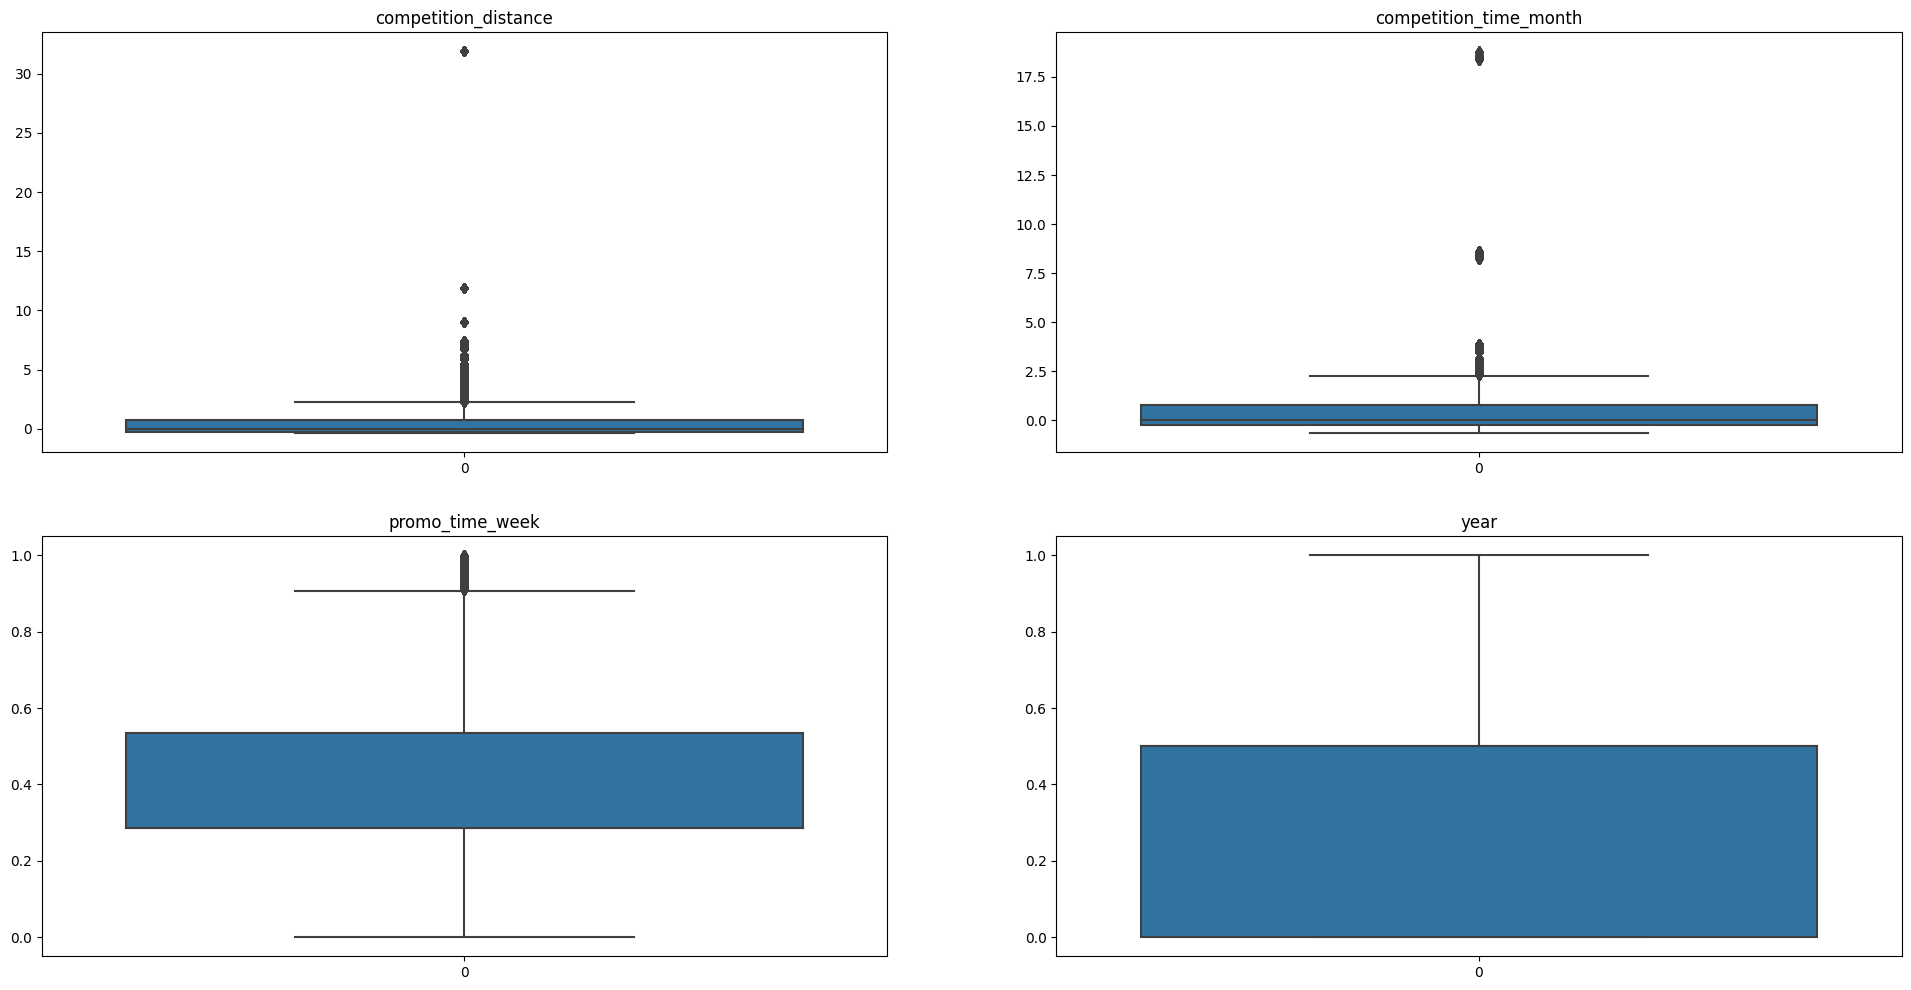

In [246]:
plt.figure(figsize=(24,12))

plt.subplot(2, 2, 1)
sns.boxplot(df_5['competition_distance'], );
plt.title('competition_distance');

plt.subplot(2, 2, 2)
sns.boxplot(df_5['competition_time_month']);
plt.title('competition_time_month');

plt.subplot(2, 2, 3)
sns.boxplot(df_5['promo_time_week']);
plt.title('promo_time_week');

plt.subplot(2, 2, 4)
sns.boxplot(df_5['year']);
plt.title('year');

Dados em uma nova escala (mesmo range). Agora temos os mesmo dados em um novo range, com as medidas equivalentes para aplicar no modelo.

## 5.3 - Transformação

### 5.3.1 - Encoding

In [247]:
df_5.select_dtypes(include='object')

,state_holiday,store_type,assortment,promo_interval,month_map,year_week
0,regular_day,c,basic,0,Jul,2015-30
1,regular_day,a,basic,"Jan,Apr,Jul,Oct",Jul,2015-30
2,regular_day,a,basic,"Jan,Apr,Jul,Oct",Jul,2015-30
3,regular_day,c,extended,0,Jul,2015-30
4,regular_day,a,basic,0,Jul,2015-30
...,...,...,...,...,...,...
1016776,public_holiday,b,basic,0,Jan,2013-00
1016827,public_holiday,b,extra,0,Jan,2013-00
1016863,public_holiday,b,extra,"Jan,Apr,Jul,Oct",Jan,2013-00
1017042,public_holiday,b,extra,0,Jan,2013-00


In [248]:
# state_holiday - One Hot Encoding
# Como o feriado é um "estado" que a loja fica e depois volta ao regular, vou aplicar o One Hot Encoding
df_5 = pd.get_dummies(df_5, prefix=['state_holiday'], columns=['state_holiday'])


# store_type - Label Encoding
# Não tem uma ordem certa é a,b ou c, não sabemos se tem uma relação entre elas, vou aplicar o Label Encoding
le = LabelEncoder()
df_5['store_type'] = le.fit_transform(df_5['store_type'])
# joblib.dump(le, 'C:\\Users\\rapha\\venvs\\rossmann_store_sales\\parameter\\store_type_scaler.joblib')


# assortment
# Nessa feature existe um tipo de ordem basic < extended < extra
assortment_dict = {'basic': 1,
                   'extra': 2,
                   'extended': 3}
df_5['assortment'] = df_5['assortment'].map(assortment_dict)

In [249]:
df_5.head().T

,0,1,2,3,4
store,1,2,3,4,5
day_of_week,5,5,5,5,5
date,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00,2015-07-31 00:00:00
sales,5263,6064,8314,13995,4822
customers,555,625,821,1498,559
open,1,1,1,1,1
promo,1,1,1,1,1
school_holiday,1,1,1,1,1
store_type,2,0,0,2,0
assortment,1,1,1,3,1


### 5.3.2 - Transformação de Variável Resposta (Target)

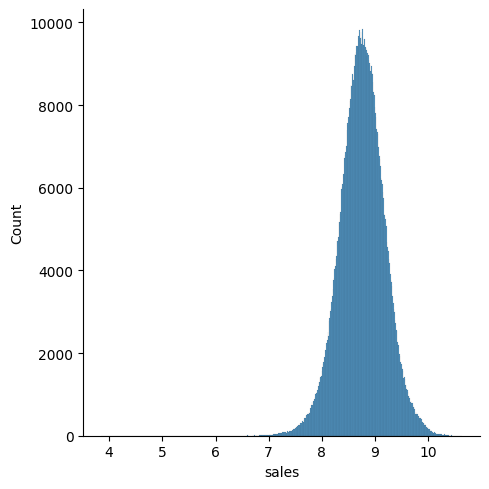

In [250]:
df_5['sales'] = np.log1p(df_5['sales'])
sns.displot(df_5['sales'])

### 5.3.3 - Transformação de Natureza Cíclica

Vamos aplicar a Transformação nas seguintes variáveis:
- day_of_week
- month
- day
- week_of_year

In [251]:
# month
df_5['month_sin'] = df_5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
df_5['month_cos'] = df_5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

# day
df_5['day_sin'] = df_5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
df_5['day_cos'] = df_5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

# week_of_year
df_5['week_of_year_sin'] = df_5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
df_5['week_of_year_cos'] = df_5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

# day_of_week
df_5['day_of_week_sin'] = df_5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
df_5['day_of_week_cos'] = df_5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

In [252]:
df_5.head()

,store,day_of_week,date,sales,customers,open,promo,school_holiday,store_type,assortment,...,state_holiday_public_holiday,state_holiday_regular_day,month_sin,month_cos,day_sin,day_cos,week_of_year_sin,week_of_year_cos,day_of_week_sin,day_of_week_cos
0,1,5,2015-07-31,8.568646,555,1,1,1,2,1,...,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
1,2,5,2015-07-31,8.710290,625,1,1,1,0,1,...,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
2,3,5,2015-07-31,9.025816,821,1,1,1,0,1,...,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
3,4,5,2015-07-31,9.546527,1498,1,1,1,2,3,...,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521
4,5,5,2015-07-31,8.481151,559,1,1,1,0,1,...,False,True,-0.5,-0.866025,0.207912,0.978148,-0.568065,-0.822984,-0.974928,-0.222521


# PASSO 06 - SELEÇÃO DE FEATURES

In [253]:
df_6 = df_5.copy()

Implementação do Algoritmo Boruta para selecionar features relevantes para o modelo.

## 6.1 - Dividir Dataframe em Treino e Teste

In [254]:
# Excluir as features originais que fiz a derivação em outras features no PASSO 05
cols_drop_2 = ['month', 'day', 'week_of_year', 'day_of_week', 'promo_since', 'competition_since', 'year_week']
df_6 = df_6.drop(cols_drop_2, axis=1)

Como a proposta do estudo é prever as próximas 6 semanas de venda das lojas, vou separar as últimas 6 semanas do dataset para Teste do algoritmo
e separar do primeiro dia de vendas até esse ponto antes das 6 últimas semanas do dataset para treino do algoritmo


In [255]:
print(df_6[['store', 'date']].groupby('store').min().reset_index())
print(df_6[['store', 'date']].groupby('store').max().reset_index())

      store       date
0         1 2013-01-02
1         2 2013-01-02
2         3 2013-01-02
3         4 2013-01-02
4         5 2013-01-02
...     ...        ...
1110   1111 2013-01-02
1111   1112 2013-01-02
1112   1113 2013-01-02
1113   1114 2013-01-02
1114   1115 2013-01-02

[1115 rows x 2 columns]
      store       date
0         1 2015-07-31
1         2 2015-07-31
2         3 2015-07-31
3         4 2015-07-31
4         5 2015-07-31
...     ...        ...
1110   1111 2015-07-31
1111   1112 2015-07-31
1112   1113 2015-07-31
1113   1114 2015-07-31
1114   1115 2015-07-31

[1115 rows x 2 columns]


In [256]:
# Descobrindo as últimas 6 semanas
df_6[['store', 'date']].groupby('store').max().reset_index()['date'][0] - datetime.timedelta(days=6*7)

Timestamp('2015-06-19 00:00:00')

- **Conjunto de TREINO:** *2013-01-02 até 2015-06-18*
- **Conjunto de TESTE:** *2015-06-19 até 2015-07-31*

In [257]:
# Dataset de TREINO
X_train = df_6[df_6['date'] < '2015-06-19']
y_train = X_train['sales']

# Dataset de TESTE
X_test = df_6[df_6['date'] >= '2015-06-19']
y_test = X_test['sales']

print('Data Min do Dataset de Treino: {}'.format(X_train['date'].min()))
print('Data Max do Dataset de Treino: {}'.format(X_train['date'].max()))

print('\nData Min do Dataset de Teste: {}'.format(X_test['date'].min()))
print('Data Max do Dataset de Teste: {}'.format(X_test['date'].max()))

Data Min do Dataset de Treino: 2013-01-01 00:00:00
Data Max do Dataset de Treino: 2015-06-18 00:00:00

Data Min do Dataset de Teste: 2015-06-19 00:00:00
Data Max do Dataset de Teste: 2015-07-31 00:00:00


## 6.2 - Aplicação do Boruta

In [258]:
# # Definir Dataset treino e teste pro Boruta
# X_train_n = X_train.drop(['date', 'sales', 'promo_interval', 'month_map'], axis=1).values # Pegando só os valores, o boruta não funciona com dataset
# # Removi 'promo_interval', 'month_map' pois o Boruta não estava funcionando com essas duas variáveis revido o tipo delas.
# y_train_n = y_train.values.ravel() # Colocando os valores em um vetor

# # Definir RandomForestRegressor
# rf = RandomForestRegressor(n_jobs=-1)

# # Definir Boruta
# boruta = BorutaPy(rf, n_estimators='auto', verbose=2, random_state=42).fit(X_train_n, y_train_n)

In [259]:
# # Melhores Features segundo o Boruta (Feature Select)
# cols_selected = list(boruta.support_)

# # Melhores Features
# X_train_fs = X_train.drop(['date', 'sales', 'promo_interval', 'month_map'], axis=1)
# cols_selected_boruta = X_train_fs.iloc[:, cols_selected].columns.to_list()

# # Features não selecionadas
# cols_not_selected_boruta = list(np.setdiff1d(X_train_fs.columns, cols_selected_boruta))

O Boruta estava conflitando com a versão atual do NumPy que estava usando, para conseguir fazer o downgrade no NumPy precisei fazer um downgrad na versão do Python que estava utilizando. Para ai o Boruta funcionar.

- Python 3.11.2 para 3.10.0
- NumPy 1.26.0 para 1.23.1

## 6.3 - Análise e Seleção de Features

In [260]:
# cols_selected_boruta

In [261]:
print(tabulate( tab, headers='firstrow' ))

Hipoteses    Conclusao    Relevancia
-----------  -----------  ------------
H1           Falsa        Baixa
H2           Falsa        Media
H3           Falsa        Media
H1           Falsa        Baixa
H2           -            -
H3           Falsa        Baixa
H1           Falsa        Media
H2           Falsa        Alta
H3           Falsa        Alta
H4           Verdadeira   Alta
H5           Verdadeira   Alta
H6           Verdadeira   Baixa


In [262]:
# cols_not_selected_boruta

Agora preciso comparar as features que o Boruta considerou como relevantes com as variáveis que eu acho que são relevantes para o modelo a partir da Análise Exploratória de Dados no PASSO 04.

De Todas As Features que classifiquei com relevância alta para o modelo o Boruta concordou (day, day_of_week, month), apenas a feature 'year' que o boruta não concorda, desta forma, deixarei a feature 'year' de fora do modelo nesse ciclo.

In [339]:
# Vou adicionar os pares Sen e Cos de features que o Boruta não considerou relevante.
cols_selected_boruta = [
    'store',
    'promo',
    'store_type',
    'assortment',
    'competition_distance',
    'competition_open_since_month',
    'competition_open_since_year',
    'promo2',
    'promo2_since_week',
    'promo2_since_year',
    'competition_time_month',
    'promo_time_week',
    'month_cos',
    'month_sin',
    'day_cos',
    'day_sin',
    'week_of_year_cos',
    'week_of_year_sin',
    'day_of_week_sin',
    'day_of_week_cos']

# PASSO 07 - MODELOS DE MACHINE LEARNING

In [340]:
x_train = X_train[cols_selected_boruta]
x_test = X_test[cols_selected_boruta]

In [341]:
# Deixei as variáveis Date e Sales de fora, preciso por de volta
# Pois o Date usamos para separar o dataset (vamos usar de novo) e sales é a Target

feat_to_add = ['date', 'sales']
cols_selected_boruta.extend(feat_to_add)  

x_training = X_train[cols_selected_boruta]
x_training.head()

,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,...,month_cos,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos,date,sales
47945,1,1,2,1,-0.170968,9,2008,0,25,2015,...,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.443762
47946,2,1,0,1,-0.283871,11,2007,1,13,2010,...,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.547722
47947,3,1,0,1,1.903226,12,2006,1,14,2011,...,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.927712
47948,4,1,2,3,-0.275806,9,2009,0,25,2015,...,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,9.091669
47949,5,1,0,1,4.448387,4,2015,0,25,2015,...,-1.0,1.224647e-16,-0.809017,-0.587785,-0.992709,0.120537,-0.433884,-0.900969,2015-06-18,8.502080


## 7.1 - Modelo de Média (Average Model)

In [342]:
aux_average_model_1 = x_test.copy()
aux_average_model_1['sales'] = y_test.copy()

# Prediction
aux_average_model_2 = aux_average_model_1[['store', 'sales']].groupby('store').mean().reset_index().rename(columns={'sales': 'predictions'})
aux_average_model_1 = pd.merge(aux_average_model_1, aux_average_model_2, how='left', on='store')
y_hat_baseline = aux_average_model_1['predictions']

# Performance
baseline_result = ml_error('Average Model', np.expm1(y_test), np.expm1(y_hat_baseline))
baseline_result

,Model Name,MAE,MAPE,RMSE
0,Average Model,1354.800353,0.2064,1835.135542


## 7.2 - Regressão Linear (Linear Regression)

In [267]:
# Model
lr = LinearRegression().fit(x_train, y_train)

# Prediction
y_hat_lr = lr.predict(x_test)

# Performance
lr_result = ml_error('Linear Regression', np.expm1(y_test), np.expm1(y_hat_lr))
lr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression,1344.347775,0.183431,3371.671836


O RMSE do modelo de Regressão Linear MUITO maior que do modelo de média, ou seja, o erro da regressão linear está muito maior, isso me diz duas coisas:
- que o modelo de média é bem melhor que o modelo de regressão linear
- que os dados tem um comportamento complexo, não linear, o que indica que modelos lineares não servem para revolver o problema

### 7.2.1 - Linear Regression - Cross-Validation

In [268]:
lr_result_cv = cross_validation(x_training, 5, 'Linear Regression', LinearRegression(), verbose=False)
lr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression,1440.51 +/- 231.33,0.19 +/- 0.01,3536.63 +/- 703.2


## 7.3 - Regressão Linear Regularizada (Linear Regression Regularized) - Lasso

In [269]:
# Model
lrr = Lasso(alpha=0.01).fit(x_train, y_train)

# Prediction
y_hat_lrr = lrr.predict(x_test)

# Performance
lrr_result = ml_error('Linear Regression Regularized - Lasso', np.expm1(y_test), np.expm1(y_hat_lrr))
lrr_result

,Model Name,MAE,MAPE,RMSE
0,Linear Regression Regularized - Lasso,1413.378546,0.187075,3410.484851


Mesmo caswo do RMSE da Regressão Linear. Os dados que estamos trabalhando não são Lineares.

### 7.3.1 - Linear Regression Regularized - Lasso - Cross-Validation

In [270]:
lrr_result_cv = cross_validation(x_training, 5, 'Linear Regression Regularized', Lasso(alpha=0.01), verbose=False)
lrr_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Linear Regression Regularized,1516.15 +/- 257.71,0.19 +/- 0.01,3541.76 +/- 732.89


## 7.4 - Random Forest Regressor

In [271]:
# # DEMORA MUITO PARA RODAR

# # Model
# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train) # O ideal é aumentar o n_estimators

# # Prediction
# y_hat_rf = rf.predict(x_test)

# # Performance
# rf_result = ml_error('Random Forest Regressor', np.expm1(y_test), np.expm1(y_hat_rf))
# rf_result

### 7.4.1 - Random Forest Regressor - Cross-Validation

In [272]:
# # DEMORA MUITO PARA RODAR. Demorou 2h33min para rodar

# rf = RandomForestRegressor(n_estimators=100, n_jobs=-1, random_state=42).fit(x_train, y_train)
# rf_result_cv = cross_validation(x_training, 5, 'Random Forest Regressor', rf, verbose=True)
# rf_result_cv

In [273]:
# # Suponha que 'modelo' seja o objeto do seu modelo treinado
# joblib.dump(rf_result_cv, 'random_forest_regressor_cv.joblib')

In [274]:
rf_result_cv = joblib.load('random_forest_regressor_cv.joblib')
rf_result_cv

,Model Name,MAE CV,MAPE CV,RMSE CV
0,Random Forest Regressor,405.42 +/- 97.84,0.05 +/- 0.01,591.83 +/- 145.34


## 7.5 - XGBoost Regressor

In [343]:
# Model
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    eta=0.01,
    max_depth=10,
    subsample=0.7,
    colsample_bytree= 0.9
).fit(x_train, y_train)

# Prediction
y_hat_xgb = model_xgb.predict(x_test)

# Performance
xgb_result = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(y_hat_xgb))
xgb_result

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,1684.652323,0.249929,2462.912382


### 7.5.1 - XGBoost Regressor - Cross-Validation

In [276]:
model_xgb = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    eta=0.01,
    max_depth=10,
    subsample=0.7,
    colsample_bytree= 0.9
).fit(x_train, y_train)

xgb_result_cv = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=True)
xgb_result_cv


K-fold Number: 5

K-fold Number: 4

K-fold Number: 3

K-fold Number: 2

K-fold Number: 1


,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1300.41 +/- 260.86,0.16 +/- 0.01,1941.24 +/- 389.27


## 7.6 - Comparação de Performance do Modelos

### 7.6.1 - Single Performance

In [277]:
# modelling_result = pd.concat([baseline_result, lr_result, lrr_result, rf_result, xgb_result])
# modelling_result.sort_values('RMSE')

### 7.6.2 - Real Performance - Cross-validation

In [278]:
modelling_result = pd.concat([lr_result_cv, lrr_result_cv, rf_result_cv, xgb_result_cv])
modelling_result.sort_values('RMSE CV')

,Model Name,MAE CV,MAPE CV,RMSE CV
0,XGBoost Regressor,1300.41 +/- 260.86,0.16 +/- 0.01,1941.24 +/- 389.27
0,Linear Regression,1440.51 +/- 231.33,0.19 +/- 0.01,3536.63 +/- 703.2
0,Linear Regression Regularized,1516.15 +/- 257.71,0.19 +/- 0.01,3541.76 +/- 732.89
0,Random Forest Regressor,405.42 +/- 97.84,0.05 +/- 0.01,591.83 +/- 145.34


Como podemos ver a Random Forest é o que tem o melhor desempenho, mas por motivos de estudo e limitação da minha máquina vou seguir com o XGBoost para o modelo do projeto por ser mais leve e mais rápido também.

# PASSO 08 - HIPERPARÂMETROS E FINE TUNING (MODELO FINAL)

Vou aplicar o **Random Search** devido a sua velocidade, apesar da aleatoriedade. Em um próximo ciclo desse projeto posso pensar em mudar a estratégia de Fine Tuning.

## 8.1 - Implementando o Random Search

In [279]:
# # DEMORA MUITO para executar esse código

# param = {
#     'n_estimators': [1500, 1700, 2500, 3000, 3500],
#     'eta': [0.01, 0.03],
#     'max_depth':[3, 5, 9],
#     'subsample': [0.1, 0.5, 0.7],
#     'colsample_bytree':[0.3, 0.7, 0.9],
#     'min_child_weight': [3, 8, 15]
# }

# MAX_EVAL = 5

# final_xgb_rs_result = pd.DataFrame()

# for i in range(MAX_EVAL):
#     # Choose values for parameters randomly
#     hp = {k: random.sample(v, 1)[0] for k, v in param.items()}
#     print(hp)
#     # Model
#     model_xgb = xgb.XGBRegressor(
#         objective='reg:squarederror',
#         n_estimators=hp['n_estimators'],
#         eta=hp['eta'],
#         max_depth=hp['max_depth'],
#         subsample=hp['subsample'],
#         colsample_bytee= hp['colsample_bytree'],
#         min_child_weight=hp['min_child_weight']
#     )

#     # Performance
#     xgb_rs_result = cross_validation(x_training, 5, 'XGBoost Regressor', model_xgb, verbose=False)
#     final_xgb_rs_result = pd.concat([final_xgb_rs_result, xgb_rs_result])

# final_xgb_rs_result

## 8.2 - Modelo Final Tunado

In [344]:
param_tuned = {
    'n_estimators':3000,
    'eta': 0.03,
    'max_depth': 5,
    'subsample': 0.7,
    'colsample_bytree': 0.7,
    'min_child_weight': 3
}

# Model Tuned
model_xgb_tuned = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=param_tuned['n_estimators'],
    eta=param_tuned['eta'],
    max_depth=param_tuned['max_depth'],
    subsample=param_tuned['subsample'],
    colsample_bytee= param_tuned['colsample_bytree'],
    min_child_weight=param_tuned['min_child_weight']
).fit(x_train, y_train)

# Prediction
y_hat_xgb_tuned = model_xgb_tuned.predict(x_test)

# Performance
xgb_result_tuned = ml_error('XGBoost Regressor', np.expm1(y_test), np.expm1(y_hat_xgb_tuned))
xgb_result_tuned

,Model Name,MAE,MAPE,RMSE
0,XGBoost Regressor,768.205763,0.114925,1111.929114


In [345]:
# joblib.dump(model_xgb_tuned, 'C:/Users/rapha/venvs/rossmann_store_sales/model/model_rossmann.joblib')
model_xgb_tuned = joblib.load('C:/Users/rapha/venvs/rossmann_store_sales/model/model_rossmann.joblib')

In [282]:
# Vendo o resultado do MPE
mpe = mean_percentage_error(np.expm1(y_test), np.expm1(y_hat_xgb_tuned))
mpe = '{:.10f}'.format(mpe)
mpe
# O valor é negativo porque o modelo está superestimando os valores das vendas (Target)
# O valor predito tende a ser maior que o Valor Real

'-0.0000212983'

# PASSO 09 - INTERPRETAÇÃO E TRADUÇÃO DOS ERROS

In [346]:
df_9 = X_test[cols_selected_boruta]

In [347]:
# Preciso fazer um Rescale na coluna 'Sales'
# No passo 5.3.2 fiz uma transformação de Natureza na Target. Apliquei uma transformação logarítmica
# Agora precisamos voltar o erro na escala original para calcular o erro na mesma escala que temos os dados originais
df_9['sales'] = np.expm1(df_9['sales'])
df_9['predictions'] = np.expm1(y_hat_xgb_tuned)
df_9.head()


,store,promo,store_type,assortment,competition_distance,competition_open_since_month,competition_open_since_year,promo2,promo2_since_week,promo2_since_year,...,month_sin,day_cos,day_sin,week_of_year_cos,week_of_year_sin,day_of_week_sin,day_of_week_cos,date,sales,predictions
0,1,1,2,1,-0.170968,9,2008,0,31,2015,...,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,5263.0,6017.485352
1,2,1,0,1,-0.283871,11,2007,1,13,2010,...,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,6064.0,6066.881836
2,3,1,0,1,1.903226,12,2006,1,14,2011,...,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,8314.0,9591.414062
3,4,1,2,3,-0.275806,9,2009,0,31,2015,...,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,13995.0,11404.850586
4,5,1,0,1,4.448387,4,2015,0,31,2015,...,-0.5,0.978148,0.207912,-0.822984,-0.568065,-0.974928,-0.222521,2015-07-31,4822.0,6292.283203


## 9.1 - Desempenho dos Negócios

In [348]:
# Sum of predictions - quero saber quanto de dinheiro vai entrar usando meu modelo

# Previsão de cada loja - O Problema inicial do CFO é saber quanto de budget que ele vai separar para cada loja
df_91 = df_9[['store', 'predictions']].groupby('store').sum().reset_index()

# MAE and MAPE - Métricas para reportar o valor de negócio para o CFO
df_9_mae = df_9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAE'})
df_9_mape = df_9[['store', 'sales', 'predictions']].groupby('store').apply(lambda x: mean_absolute_percentage_error(x['sales'], x['predictions'])).reset_index().rename(columns={0:'MAPE'})

# Merge
df_mae_mape = pd.merge(df_9_mae, df_9_mape, how='inner', on='store')
df_92 = pd.merge(df_91, df_mae_mape, how='inner', on='store')


In [349]:
df_92.head()

,store,predictions,MAE,MAPE
0,1,174855.921875,417.341777,0.095316
1,2,181285.281250,466.942205,0.094399
2,3,267610.656250,657.975520,0.090656
3,4,342736.312500,851.972643,0.081183
4,5,169408.250000,352.544869,0.078800


A Coluna 'predictions' são as previsões de vendas para as próximas 6 semanas, que o modelo fez.

In [350]:
# Scenarios
df_92['worst_scenario'] = df_92['predictions'] - df_92['MAE']
df_92['best_scenario'] = df_92['predictions'] + df_92['MAE']

# Order columns
df_92 = df_92[['store', 'worst_scenario','predictions', 'best_scenario', 'MAE', 'MAPE']]

df_92.sample(10)

,store,worst_scenario,predictions,best_scenario,MAE,MAPE
433,434,367466.450578,368634.843750,369803.236922,1168.393172,0.113915
1000,1001,198649.166860,199356.406250,200063.645640,707.239390,0.118842
215,216,271086.652357,271867.531250,272648.410143,780.878893,0.117549
836,837,163761.286133,164317.109375,164872.932617,555.823242,0.147033
366,367,214236.103173,214854.218750,215472.334327,618.115577,0.122315
807,808,261040.768627,261803.828125,262566.887623,763.059498,0.105986
571,572,265113.664010,265856.187500,266598.710990,742.523490,0.109164
583,584,181857.267004,182373.515625,182889.764246,516.248621,0.103958
405,406,244335.591612,245151.468750,245967.345888,815.877138,0.106901
363,364,176405.148886,177003.562500,177601.976114,598.413614,0.110771


In [351]:
df_92.sort_values('MAPE', ascending=False).head(10)

,store,worst_scenario,predictions,best_scenario,MAE,MAPE
291,292,104011.819966,107402.531250,110793.242534,3390.711284,0.607763
908,909,211669.532609,219691.250000,227712.967391,8021.717391,0.526101
594,595,296539.096059,302662.093750,308785.091441,6122.997691,0.423033
268,269,370360.827808,372680.656250,375000.484692,2319.828442,0.334974
875,876,189749.800866,193811.062500,197872.324134,4061.261634,0.318849
901,902,190723.204300,191912.515625,193101.826950,1189.311325,0.297070
785,786,142001.290877,142743.625000,143485.959123,742.334123,0.284874
955,956,136826.532754,137529.375000,138232.217246,702.842246,0.278987
169,170,190210.557545,191295.609375,192380.661205,1085.051830,0.268191
674,675,152997.806047,153802.000000,154606.193953,804.193953,0.258032


Com essas informações o CFO consegue saber o budget de cada loja para cada cenário, se ele achar que o MAPE está alto para uma determinada loja ele pode assumir o valor do 'worst_scenario', se ele ele acha que o valor do MAPE está baixo pode escolher assumir o 'predictions' ou 'best_scenario' de budget para a loja nas próximas 6 semanas.

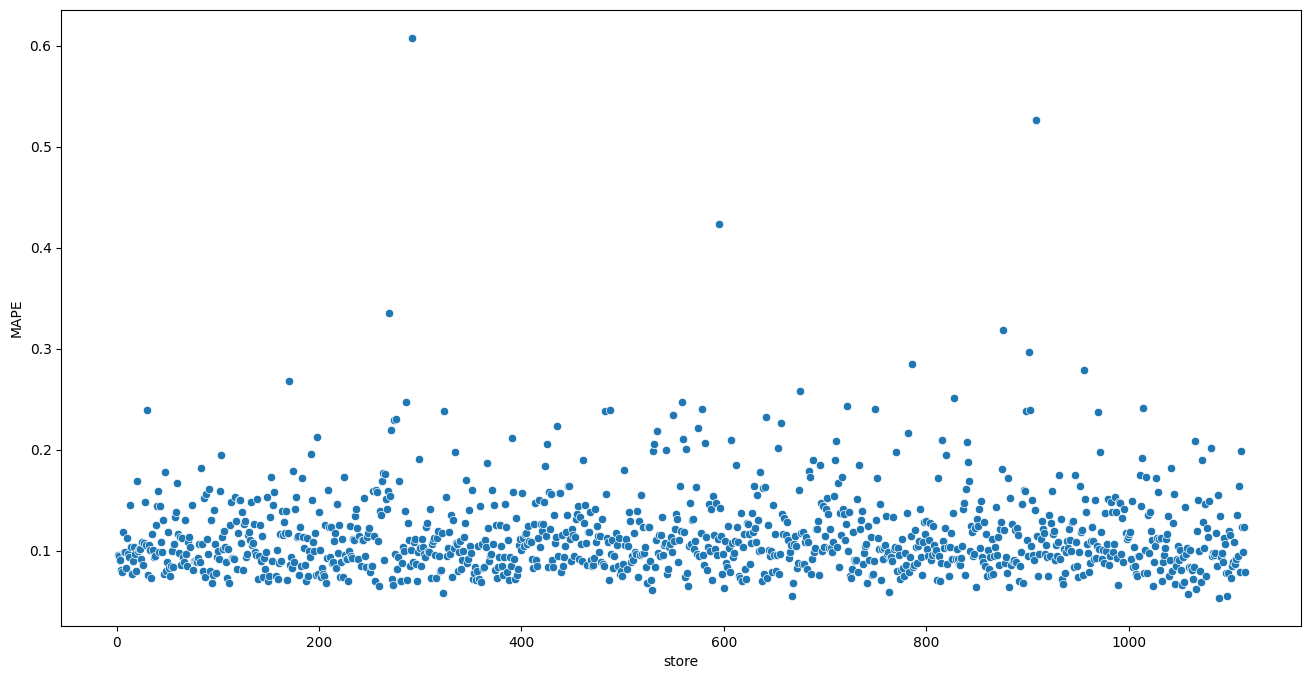

In [352]:
# Visão geral da porcentagem de erro das lojas
plt.figure(figsize=(16, 8))
sns.scatterplot(data=df_92, x='store', y='MAPE');

## 9.2 - Performance Total

In [353]:
df_93 = df_92[['predictions', 'worst_scenario', 'best_scenario']].apply(lambda x: np.sum(x), axis=0).reset_index().rename(columns={'index': 'Scenario', 0: 'Values'})
df_93['Values'] = df_93['Values'].map('R${:,.2f}'.format)
df_93

,Scenario,Values
0,predictions,"R$287,082,816.00"
1,worst_scenario,"R$286,223,080.98"
2,best_scenario,"R$287,942,564.25"


Predição de venda das lojas nas próximas 6 semanas junto com o pior e melhor cenário de vendas.

## 9.3 - Performance Machine Learning

In [354]:
df_9['error'] = df_9['sales'] - df_9['predictions']
df_9['error_rate'] = df_9['predictions']/df_9['sales'] # Porcentagem das predições em relações as vendas. Se igual a 1 é a venda perfeita

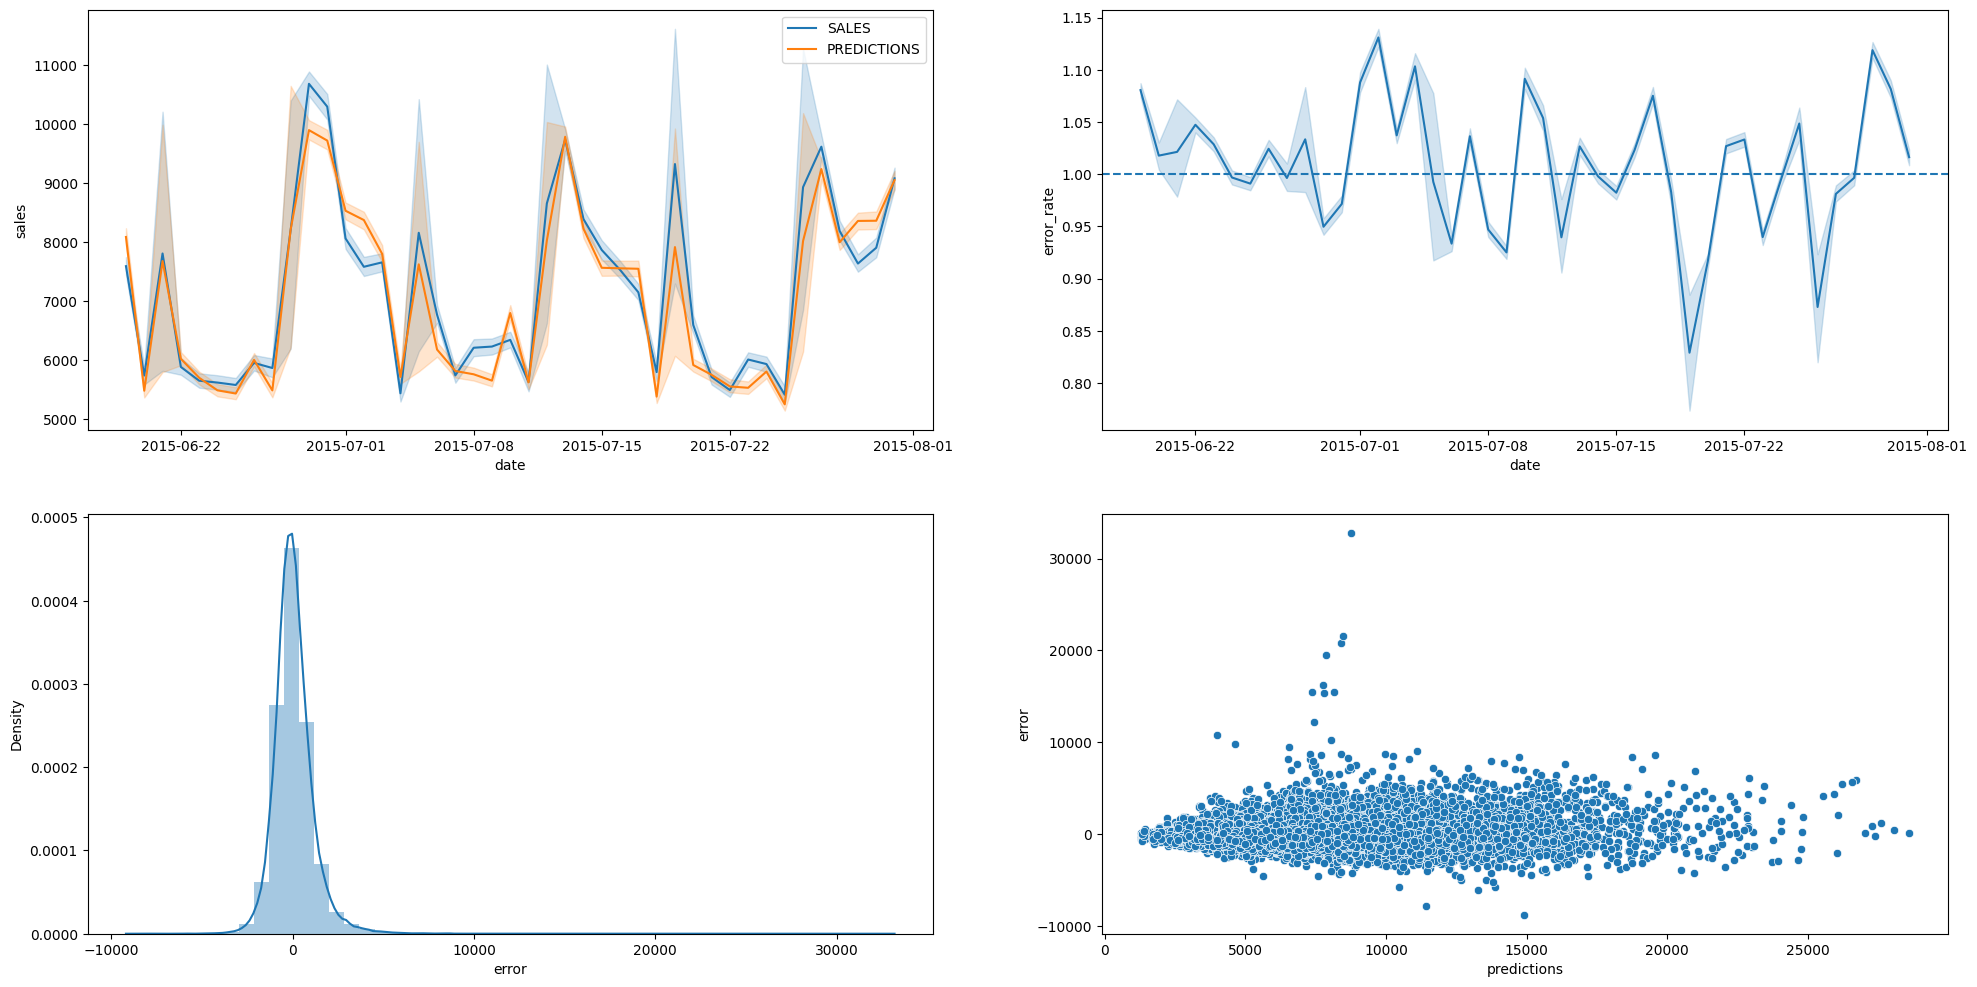

In [355]:
plt.figure(figsize=(24, 12))

plt.subplot(2, 2, 1)
sns.lineplot(data=df_9, x='date', y='sales', label='SALES');
sns.lineplot(data=df_9, x='date', y='predictions', label='PREDICTIONS');

plt.subplot(2, 2, 2)
sns.lineplot(data=df_9, x='date', y='error_rate');
plt.axhline(1, linestyle='--')

plt.subplot(2, 2, 3)
sns.distplot(df_9['error']);

plt.subplot(2, 2, 4)
sns.scatterplot(data= df_9, x='predictions', y='error');

# PASSO 10 - DEPLOY DO MODELO EM PRODUÇÃO

## 10.1 - Rossmann Class

In [ ]:
import joblib
import inflection
import pandas as pd
import numpy as np
import math
import datetime

# Classe com as Limpezas, Transformações e Encoding
class Rossmann(object):
    def __init__(self):
        self.competition_distance_scaler = joblib.load('C:/Users/rapha/venvs/rossmann_store_sales/parameter/competition_distance_scaler.joblib')
        self.competition_time_month_scaler = joblib.load('C:/Users/rapha/venvs/rossmann_store_sales/parameter/competition_time_month_scaler.joblib')
        self.promo_time_week_scaler = joblib.load('C:/Users/rapha/venvs/rossmann_store_sales/parameter/promo_time_week_scaler.joblib')
        self.store_type_scaler = joblib.load('C:/Users/rapha/venvs/rossmann_store_sales/parameter/store_type_scaler.joblib')
        self.year_scaler = joblib.load('C:/Users/rapha/venvs/rossmann_store_sales/parameter/year_scaler.joblib')
        

    def data_cleaning(self, df_1):

        ## 1.1 - Renomear colunas
        cols_old = ['Store', 'DayOfWeek', 'Date', 'Open', 'Promo', 'StateHoliday', 'SchoolHoliday', 'StoreType',
                    'Assortment', 'CompetitionDistance', 'CompetitionOpenSinceMonth', 'CompetitionOpenSinceYear', 'Promo2', 'Promo2SinceWeek',
                    'Promo2SinceYear', 'PromoInterval']
        
        snake_case = lambda x: inflection.underscore(x)

        cols_new = list(map(snake_case, cols_old))

        # Rename
        df_1.columns = cols_new

        # Data Types
        df_1['date'] = pd.to_datetime(df_1['date'])

        # Fillout NA
        df_1['competition_distance'] = df_1['competition_distance'].apply(lambda x: 200000.0 if math.isnan(x) else x)

        df_1['competition_open_since_month'] = df_1.apply(lambda x: x['date'].month if math.isnan(x['competition_open_since_month']) else x['competition_open_since_month'], axis=1)

        df_1['competition_open_since_year'] = df_1.apply(lambda x: x['date'].year if math.isnan(x['competition_open_since_year']) else x['competition_open_since_year'], axis=1)
        
        df_1['promo2_since_week'] = df_1.apply(lambda x: x['date'].week if math.isnan(x['promo2_since_week']) else x['promo2_since_week'], axis=1)
        
        df_1['promo2_since_year'] = df_1.apply(lambda x: x['date'].year if math.isnan(x['promo2_since_year']) else x['promo2_since_year'], axis=1)

        df_1['promo_interval'].fillna(0, inplace=True)

        month_map = {
            1:'Jan',
            2:'Feb',
            3:'Mar',
            4:'Apr',
            5:'May',
            6:'Jun',
            7:'Jul',
            8:'Aug',
            9:'Sept',
            10:'Oct',
            11:'Nov',
            12:'Dec'
        }

        df_1['month_map'] = df_1['date'].dt.month.map(month_map)

        df_1['is_promo'] = df_1[['promo_interval', 'month_map']].apply(lambda x: 0 if x['promo_interval'] == 0 else 1 if x['month_map'] in x['promo_interval'].split(',') else 0, axis=1)

        # Change Data Type
        df_1['competition_open_since_month'] = df_1['competition_open_since_month'].astype('int64')
        df_1['competition_open_since_year'] = df_1['competition_open_since_year'].astype('int64')

        df_1['promo2_since_week'] = df_1['promo2_since_week'].astype('int64')
        df_1['promo2_since_year'] = df_1['promo2_since_year'].astype('int64')

        return df_1
    

    def feature_engineering(self, df_2):
        # year
        df_2['year']= df_2['date'].dt.year

        # mounth
        df_2['month']= df_2['date'].dt.month

        # day
        df_2['day']= df_2['date'].dt.day

        # week of year
        df_2['week_of_year']= df_2['date'].dt.isocalendar().week

        # year week
        df_2['year_week']= df_2['date'].dt.strftime('%Y-%W')

        df_2['competition_open_since_year'] = df_2['competition_open_since_year'].astype(int)
        df_2['competition_open_since_month'] = df_2['competition_open_since_month'].astype(int)

        df_2['competition_since'] = df_2.apply(lambda x: datetime.datetime(year=x['competition_open_since_year'], month=x['competition_open_since_month'], day=1), axis=1)
        df_2['competition_time_month'] = ((df_2['date'] - df_2['competition_since'])/30).apply(lambda x: x.days).astype(int)

        df_2['promo_since'] = df_2['promo2_since_year'].astype(str) + '-' + df_2['promo2_since_week'].astype(str)
        df_2['promo_since'] = df_2['promo_since'].apply(lambda x: datetime.datetime.strptime(x + '-1', '%Y-%W-%w') - pd.Timedelta(days=7))

        df_2['promo_time_week'] = ((df_2['date'] - df_2['promo_since'])/7).apply(lambda x: x.days).astype(int)

        df_2['assortment'] = df_2['assortment'].apply(lambda x: 'basic' if x == 'a' else 'extra' if x == 'b' else 'extended')

        df_2['state_holiday'] = df_2['state_holiday'].apply(lambda x: 'public_holiday' if x == 'a' else  'easter_holiday' if x == 'b' else 'christmas' if x == 'c' else 'regular_day')

        # Filtragem de linhas
        df_2 = df_2[df_2['open'] != 0]

        # Seleção de colunas
        cols_drop = ['open', 'promo_interval', 'month_map']
        df_2 = df_2.drop(cols_drop, axis=1)

        return df_2
    

    def data_preparation(self, df_5):
        df_5['competition_time_month'] = df_5['competition_time_month'].astype('int64')
        df_5['promo_time_week'] = df_5['promo_time_week'].astype('int64')
        df_5['week_of_year'] = df_5['week_of_year'].astype('int64')
        df_5['year'] = df_5['year'].astype('int64')
        df_5['month'] = df_5['month'].astype('int64')
        df_5['day'] = df_5['day'].astype('int64')

        # promo_time_week
        df_5['promo_time_week'] = self.promo_time_week_scaler.fit_transform(df_5[['promo_time_week']].values)
        # year
        df_5['year'] = self.year_scaler.fit_transform(df_5[['year']].values)
        # competition_distance
        df_5['competition_distance'] = self.competition_distance_scaler.fit_transform(df_5[['competition_distance']].values)
        # competition_time_month
        df_5['competition_time_month'] = self.competition_time_month_scaler.fit_transform(df_5[['competition_time_month']].values)

        # state_holiday - One Hot Encoding
        df_5 = pd.get_dummies(df_5, prefix=['state_holiday'], columns=['state_holiday'])

        # store_type - Label Encoding
        df_5['store_type'] = self.store_type_scaler.fit_transform(df_5['store_type'])

        # assortment
        # Nessa feature existe um tipo de ordem basic < extended < extra
        assortment_dict = {'basic': 1, 'extra': 2, 'extended': 3}
        df_5['assortment'] = df_5['assortment'].map(assortment_dict)

        # month
        df_5['month_sin'] = df_5['month'].apply(lambda x: np.sin(x * (2. * np.pi/12)))
        df_5['month_cos'] = df_5['month'].apply(lambda x: np.cos(x * (2. * np.pi/12)))

        # day
        df_5['day_sin'] = df_5['day'].apply(lambda x: np.sin(x * (2. * np.pi/30)))
        df_5['day_cos'] = df_5['day'].apply(lambda x: np.cos(x * (2. * np.pi/30)))

        # week_of_year
        df_5['week_of_year_sin'] = df_5['week_of_year'].apply(lambda x: np.sin(x * (2. * np.pi/52)))
        df_5['week_of_year_cos'] = df_5['week_of_year'].apply(lambda x: np.cos(x * (2. * np.pi/52)))

        # day_of_week
        df_5['day_of_week_sin'] = df_5['day_of_week'].apply(lambda x: np.sin(x * (2. * np.pi/7)))
        df_5['day_of_week_cos'] = df_5['day_of_week'].apply(lambda x: np.cos(x * (2. * np.pi/7)))

        cols_selected = ['store', 'promo', 'store_type', 'assortment', 'competition_distance', 'competition_open_since_month',
                        'competition_open_since_year', 'promo2', 'promo2_since_week', 'promo2_since_year', 'competition_time_month', 'promo_time_week',
                        'month_cos', 'month_sin', 'day_cos', 'day_sin', 'week_of_year_cos', 'week_of_year_sin', 'day_of_week_sin', 'day_of_week_cos']
        
        return df_5[cols_selected]
    
    
    def get_prediction(self, model, original_data, test_data):
        # prediction
        pred = model.predict(test_data)
        
        # join pred into the original data
        original_data['prediction'] = np.expm1(pred)
        
        return original_data.to_json(orient='records', date_format='iso')




## 10.2 - API Handler

In [ ]:
import joblib
import pandas as pd
from flask import Flask, request, Response
from rossmann.Rossmann import Rossmann

# loading model
model = joblib.load('C:/Users/rapha/venvs/rossmann_store_sales/model/model_rossmann.joblib')

# initialize API
app = Flask( __name__ )
@app.route('/rossmann/predict', methods=['POST'])

def rossmann_predict():
    test_json = request.get_json()

    if test_json: # there is data
        if isinstance(test_json, dict): # unique example
            test_raw = pd.DataFrame(test_json, index=[0])
        else: # multiple example
            test_raw = pd.DataFrame(test_json, columns=test_json[0].keys())

        # Instantiate Rossmann class
        pipeline = Rossmann()

        # data cleaning
        df_1 = pipeline.data_cleaning(test_raw)

        # feature engineering
        df_2 = pipeline.feature_engineering(df_1)

        # data preparation
        df_3 = pipeline.data_preparation(df_2)

        # prediction
        df_response = pipeline.get_prediction(model, test_raw, df_3)
        return df_response
    
    else:
        return Response('{}', status=200, mimetype='application/json')

if __name__ == '__main__':
    app.run( '0.0.0.0' ) # Local na minha máquina


## 10.3 - API Tester

In [375]:
# loading test dataset
df_10 = pd.read_csv('C:/Users/rapha/venvs/rossmann_store_sales/dataset/test.csv')

In [380]:
# merge test dataset + store
df_test = pd.merge(df_10, df_store_raw, how='left', on='Store')

# choose store for prediction
df_test = df_test[df_test['Store'].isin( [20, 22] )]

# remove closed days
df_test = df_test[df_test['Open'] != 0]
df_test = df_test[~df_test['Open'].isnull()]
df_test = df_test.drop('Id', axis=1)

In [381]:
import json

# convert Dataframe to json
data = json.dumps(df_test.to_dict(orient='records'))

In [386]:
import requests

# API Call
url = 'http://127.0.0.1:5000/rossmann/predict'
# url = 'https://rossmann-app-3c79090db4d6.herokuapp.com/rossmann/predict' ## url que usei do heroku para testar api em produção
header = {'Content-type': 'application/json'}
data = data

r = requests.post(url, data=data, headers=header)
print('Status Code {}'.format(r.status_code))

Status Code 503


In [383]:
d1 = pd.DataFrame(r.json(), columns=r.json()[0].keys())
d1.head()

JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [363]:
d2 = d1[['store', 'prediction']].groupby( 'store' ).sum().reset_index()

for i in range( len( d2 ) ):
    print( 'Store Number {} will sell R${:,.2f} in the next 6 weeks'.format(d2.loc[i, 'store'],d2.loc[i, 'prediction'] ))


Store Number 20 will sell R$314,185.59 in the next 6 weeks
Store Number 22 will sell R$237,589.20 in the next 6 weeks
Store Number 23 will sell R$240,451.19 in the next 6 weeks
